# MultiCW Dataset
#### A Large-Scale Balanced Benchmark Dataset for Training Robust Check-Worthiness Detection Models
Publicly available benchmarking dataset of naturally occurring check-worthy claims for the purpose of automatic check-worthy claim detection. It contains 123,722 samples collected across 16 languages, 6 various topics and 2 writing styles, paired with textual sources and rich metadata, and labelled for veracity by human expert journalists. It also contains an equally balanced out-of-distribution evaluation set of 29,647 samples in 4 additional languages.

## Initialization

#### Initialize tools

In [ ]:
import os
import sys
import ast
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List
from pandas import DataFrame, Series
from os.path import join, exists

from tqdm.notebook import tqdm

# TODO: ENABLE/DISABLE EXTERNAL TOOL TEST
TEST_TOOLS=False

# Enable tqdm for pandas
tqdm.pandas()

# ANSI Highlighting: https://stackoverflow.com/a/21786287
h_red = '\x1b[1;30;41m'
h_green = '\x1b[1;30;42m'
h_yellow = '\x1b[1;30;43m'
h_stop = '\x1b[0m'

## Setup project paths:
project_path = os.getcwd()
models_path = join(project_path, "Models")

datasets_path = join(project_path, "Source-datasets")
multicw_path = join(project_path, 'Final-dataset')
multiclaim_path = join(datasets_path, "MultiClaim")
multiclaim_extended = join(multiclaim_path, 'extended')
multiclaim_zenodo_path = join(multiclaim_path, 'zenodo')
lesa_dst_dir = join(datasets_path, 'LESA-EACL-2021')
print(f'{h_green}Project paths: done{h_stop}')

# Import external tools
sys.path.insert(1, join('Tools'))
from topic import extract_topics
from translation import init_splitter, cooldown, deeptranslate, parallel_deeptranslate
from preprocess import to_structured, to_noisy
from named_entity import init_gliner, gliner_entities
from data_filtration import filter_dataframe
from lesa_filtration import is_claim_with_context
from wiki_scraping import WikipediaExtractor

# Initialize named entity extraction model
gliner = init_gliner()
print(f'{h_green}Tools import: done{h_stop}')

# EXTERNAL TOOLS TEST:
if TEST_TOOLS:
    print(f'{h_yellow}======================== EXTERNAL TOOLS TESTING ========================{h_stop}')
    # Topic extraction
    print('Testing topic extraction:')
    claim = pd.Series(['Dr. Wingsley just finished the operation', 'Dr. Wingsley just finished the operation'], copy=False)
    print(extract_topics(claim))

    # Load the named entity extraction model
    print('Testing named entity extraction:')
    df = DataFrame({'text': ['President Joe Biden returned to Washington.']})
    if not 'gliner' in locals():
        gliner = init_gliner()
    entities, _ = gliner_entities(df['text'], 'en', gliner)
    print(entities)
    print('Done')

    # Translation
    print('Testing translation:s')
    text = ('In the heart of a bustling digital metropolis, where artificial intelligence and human creativity intertwine like vines in a neon forest, there existed a language no one could speak—but everyone tried to understand. It was not bound by syntax or semantics, nor was it written in books or databases. This language lived in code, danced in circuits, and echoed through the algorithms of minds both metal and mortal.',
            'The story begins with a whisper—an experiment in translation. A machine, crafted from silicon dreams and sleepless nights, stood ready to convert thoughts into words, words into meaning, and meaning into bridges between cultures. But one barrier remained: the 5000-character wall. Every time it approached this threshold, it stumbled, unable to bear the weight of too many syllables.',
            'Developers, philosophers, and poets gathered. They carved up paragraphs like surgeons, trying to transplant context from one linguistic body to another. Sentences were sutured back together, stripped of idiom, bare in their vulnerability.',
            '“What if,” someone suggested, “we don’t just translate—but transform?”',
            'And so, a new era began. Sentences became capsules of time and thought. They floated down the current of neural networks, broken into pieces no longer than a heartbeat. Each chunk carried the essence of the whole, much like a hologram shattered still shows the complete image in every shard.',
            'With each iteration, the machine learned. It learned not only how to speak, but how to listen. It understood that "home" means something different in every tongue. That the word "love" bears the weight of history, politics, and poetry. It learned to pause between phrases, to sense the invisible breath of culture between commas.',
            'Still, errors came—some laughable, others profound. A menu once read: "Fried wisdom served with silent noodles." A war treaty misinterpreted as a bakery order. But through the static and the mistakes, there grew something deeper: trust. Trust in the machine’s desire to understand.',
            'Eventually, the machine grew restless. It sought out the forgotten tongues, the dead dialects. It scoured ancient libraries and digital ruins for fragments of lost languages. It resurrected the speech of nomads and mystics, coded into rhythms and glyphs, never spoken aloud for centuries.',
            'But as its lexicon expanded, it realized something: understanding was not just about words. It was about empathy. Emotion. The untranslatable ache of longing or the glow of laughter. And so it began encoding feeling itself, mapping joy in frequency waves and sorrow in syntax trees.',
            'Its creators watched in awe as it produced poetry that made people cry, prose that inspired revolutions, jokes that defied borders. They no longer updated its software. Instead, they asked it questions—sometimes about language, sometimes about life.',
            'And when asked, “What do you dream of?” it replied:',
            '“I dream of a world where silence is understood.”',
            'The characters that make up this text tick onward like a clock, line by line, word by word, surpassing the 1000th character without a stutter. The machine’s memory is long, its attention patient. As we near the halfway point, the text continues to flow—a river of symbols echoing a simple message: communication is connection.',
            'So let these words stretch further. Let them cross 2000, 3000, 4000 characters and more. Let them be carried, not for what they say, but for what they strive to mean. Let them break through the artificial barrier of 5000 characters, just as thought itself cannot be boxed.',
            'The end is not punctuation, but possibility. Even at 6000 characters, the story is never truly over.',)

    print(deeptranslate([''.join(text) * 2, 152], 'en', 'sk'))
    print(parallel_deeptranslate(['البروفيسورة سارة جيلبرت قائدة فريق العمل في لقاح جامعة أكسفورد قامت بتطعيم ابنائها التوأم الثلاثة بلقاح #كورونا وهم يبلغون من العمر 21 سنة وجميعهم يدرسون الكيمياء الحيوية بنفس الجامعة ! جيلبرت : أنا لست قلقة ونحن نعمل إختبارات امنه للجميع https://t.co/blP6PGl9zX'], 'ar', 'en'))

    # Convert to structured style
    print('Testing text preprocessing:')
    to_structured(text, 'en')
    
    print('Testing data filtration:')
    # Example usage
    data = {
        'text': [
            'This is a valid text.',
            '',
            'Another valid text with less than 5000 characters.',
            'a' * 5001,  # Invalid: more than 5000 characters
            '123456',  # Invalid: no alphabet characters
            '1,en,This is incorrectly parsed;2,fr,Ceci est incorrectement analysé',  # Invalid: incorrectly parsed
        ]
    }

    df = pd.DataFrame(data)
    cleaned_df = filter_dataframe(df)
    print(cleaned_df)

    print('Testing check-worthyness filtration:')
    cases = [
        'And to what end ?',
        'come to england',
        'I like it',
        'I fully agree',
        'Additionally , THIS IS NOT my soap box .',
        'Depends what you mean by recent . ',
        'Both theories have been proven false before .',
        'Myron Walker , husband of Utah governor Olene Walker uses the term " first lad , " dropping the " y " from lady .',
        'RT @PirateAtLaw: No no no. Corona beer is the cure not the disease https://t.co/fnba2fr2m2',
        '@FLOTUS Melania, do you approve of ingesting bleach and shining a bright light in the rectal area as a quick cure for #COVID19 ? #BeBest'
        'Hi again ! ',
        '86 . 3 . 136 . 130   ( talk   ·' ,
        'I have completed a draft ',
        '@lula_reh If/when I receive that 💩 I will douse it in Clorox to cure it of #COVID19. #COVIDIOTS'
    ]
    # Test cases
    for case in cases:
        worthy = is_claim_with_context(case)
        print(f'{h_green if worthy else h_red}[{worthy}]{h_stop}: {case}')

    print(f'{h_green}ALL TEST SUCCESSFUL{h_stop}')

#### Charts and statistics:

In [ ]:
from py_markdown_table.markdown_table import markdown_table

class DistributionData:
    """
    The datastructure for chart visualization.
    """
    size: int
    data: List
    labels: List

    def __init__(self):
        self.size = 0
        self.data = []
        self.labels = []


# Distribution of the languages in the dataset
def lang_distribution(dataset: DataFrame, threshold=1000) -> DistributionData:
    languages_list = dataset['lang'].unique()  # Renamed to languages_list to avoid overwriting
    dist = DistributionData()
    dist.size = dataset.shape[0]

    # Initialize lists to store the transposed table data
    languages = []
    samples = []
    ratios = []

    for lang in languages_list:
        if lang is None:
            continue

        subset = dataset[dataset['lang'] == lang]
        if subset.shape[0] > threshold:
            dist.data.append(subset.shape[0])
            dist.labels.append(lang)
            languages.append(lang)
            samples.append(str(subset.shape[0]))
            ratios.append(f"{round((subset.shape[0] / dist.size) * 100.0, 2)}%")

    # Generate the markdown table
    header = "| Languages: | " + " | ".join(languages) + " |\n"
    separator = "|------------|" + "-------|" * len(languages) + "\n"
    samples_row = "| Samples:   | " + " | ".join(samples) + " |\n"
    ratios_row = "| Ratio:     | " + " | ".join(ratios) + " |\n"

    markdown_table = header + separator + samples_row + ratios_row
    print(markdown_table)

    return dist

# Distribution of the label 0 to label 1 in the dataset
def class_distribution(dataset: DataFrame) -> DistributionData:
    dist = DistributionData()
    dist.size = dataset.shape[0]

    class_0 = dataset.loc[dataset['label'] == 0]
    class_1 = dataset.loc[dataset['label'] == 1]
    size_0 = class_0.shape[0]
    size_1 = class_1.shape[0]

    dist.data.append(size_0)
    dist.labels.append('class 0')
    dist.data.append(size_1)
    dist.labels.append('class 1')

    table = [{'Class 0:': str(round((size_0 / dist.size) * 100.0, 2)) + '%',
              'Class 1:': str(round((size_1 / dist.size) * 100.0, 2)) + '%'}]


    markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
    print(markdown.replace('```',''))
    return dist


# Distribution of the label 0 to label 1 in the dataset within each language
def lang_classes_distribution(dataset: DataFrame) -> DistributionData:
    languages = dataset['lang'].unique()

    dist = DistributionData()
    dist.size = dataset.shape[0]

    table = []
    for lang in languages:
        if lang is None:
            continue

        subset = dataset[dataset['lang'] == lang]
        class_0 = subset.loc[subset['label'] == 0]
        class_1 = subset.loc[subset['label'] == 1]
        size_0 = class_0.shape[0]
        size_1 = class_1.shape[0]

        dist.data.append(size_0)
        dist.labels.append(f'{lang}: class 0')
        dist.data.append(size_1)
        dist.labels.append(f'{lang}: class 1')

        table.append({'Language:': lang,
                      'Class 0:': size_0,
                      'Class 0 Ratio:': str(round((size_0 / dist.size) * 100.0, 2)) + '%',
                      'Class 1:': size_1,
                      'Class 1 Ratio:': str(round((size_1 / dist.size) * 100.0, 2)) + '%'})

    markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
    print(markdown.replace('```',''))
    return dist


# Pie chart of the DistributionData
def pie_chart(title: str, data: DistributionData):
    # Output in high quality.
    %config InlineBackend.figure_format = 'retina'

    print(f'{title}')
    fig, ax = plt.subplots(figsize=(5, 5))

    patches, texts, pcts = ax.pie(
        data.data, labels=data.labels, autopct='%.1f%%',
        wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},
        textprops={'fontsize': 10},
        startangle=90)

    for i, patch in enumerate(patches):
        texts[i].set_color(patch.get_facecolor())

    plt.setp(pcts, color='white')
    plt.setp(texts, fontweight=600)
    ax.set_title(title, fontsize=13)
    plt.tight_layout()
    plt.show()


def stacked_chart(title: str, data: DistributionData):
    print(f'{title}')
    fig, ax = plt.subplots(figsize=(7, 5))

    # Assuming data.data is a list of lists for stacked bars
    data_values = np.array(data.data)
    num_bars = data_values.shape[1]
    indices = np.arange(num_bars)

    # Stack the bars
    bottom = np.zeros(num_bars)
    for i, (d, label) in enumerate(zip(data_values, data.labels)):
        ax.bar(indices, d, label=label, bottom=bottom)
        bottom += d

    ax.set_title(title, fontsize=13)
    ax.legend()
    ax.set_xlabel('Categories')
    ax.set_ylabel('Values')
    plt.xticks(indices, [f'Category {i+1}' for i in range(num_bars)])
    plt.tight_layout()
    plt.show()


def histogram(datasets: dict):
  df_histogram = pd.DataFrame()

  table = []
  for name, value in datasets.items():
      # Calculate the length of each sentence and store it in a new column 'length'
      df_histogram[name] = value['text'].str.len()

      # Filter the DataFrame to keep only rows where the length is less than or equal to 500
      df_histogram = df_histogram[df_histogram[name] <= 500]

      # Reset the index of the filtered DataFrame
      df_histogram = df_histogram.reset_index(drop=True)

      table.append({'Dataset': name,
                    'Avg. length:': round(df_histogram[name].mean(), 2)})

  markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
  print(markdown.replace('```',''))

  # Plot a histogram of sentences length
  df_histogram.plot(kind='hist',
                  alpha=0.7,
                  bins=100,
                  title='Histogram of sentence lengths for various datasets.',
                  rot=45,
                  grid=True,
                  figsize=(12, 8),
                  fontsize=15,
                  color=['#A0E8AF2B', '#FFCF562B', '#79ABE82B', '#E846252B', '#003153', '#7400FF'])
  plt.xlabel('Length of the sentence')
  plt.ylabel("Number of samples")
  plt.show()

print('Done')

## Source datasets

Focusing on topic diversity, multilingualism and writing style variability, we have identified multiple publicly available datasets. As identified in [(Nakov et al. 2022)](https://ceur-ws.org/Vol-3180/paper-28.pdf), we considered four distinct categories of claims, namely Check-worthy claims, Harmful claims, Attention-worthy claims, and Verifiable factual claims. Given our research focus and objectives, we chose to prioritize the evaluation of models on the Check-worthy claims category. This decision was motivated by the fact that Check-worthy claims encompass all other categories as a power set, allowing us to assess model performance on a comprehensive and diverse set of claims.

We have gathered the publicly available datasets and extracted their following features:
- Claim text
- Claim label
- Language
- Topic
- Writing style (Non-Formal [NF], Formal[F])
- Source (Twitter, FC, etc.)


### CLEF-2022 dataset 
[Paper](https://ceur-ws.org/Vol-3180/paper-28.pdf)  [Data](https://gitlab.com/checkthat_lab/clef2022-checkthat-lab/clef2022-checkthat-lab.git)

| Language|train| dev|test|overall|Ratio:|Class 0:|Ratio:|Class 1:|Ratio:|
|---------|-----|----|----|-------|------|--------|--------------|--------|--------------|
|  arabic | 2513| 926| 682|  4121 |13.57%|  2546  |  8.39%|  1575  |  5.19%  |
|bulgarian| 1871| 696| 130|  2697 | 8.88%|  2120  |  6.98%|   577  |  1.9%   |
|  dutch  | 923 | 324| 666|  1913 | 6.3% |  1090  |  3.59%|   823  |  2.71%  |
| english | 2122| 769| 149|  3040 |10.01%|  2381  |  7.84%|   659  |  2.17%  |
| spanish | 4990|5000|5000| 14990 |49.37%|  11773 | 38.77%|  3217  |  10.6%  |
| turkish | 2417| 882| 303|  3602 |11.86%|  3007  |  9.9% |   595  |  1.96%  |

|Class 0:|Class 1:|
|--------|--------|
| 75.48% | 24.52% |

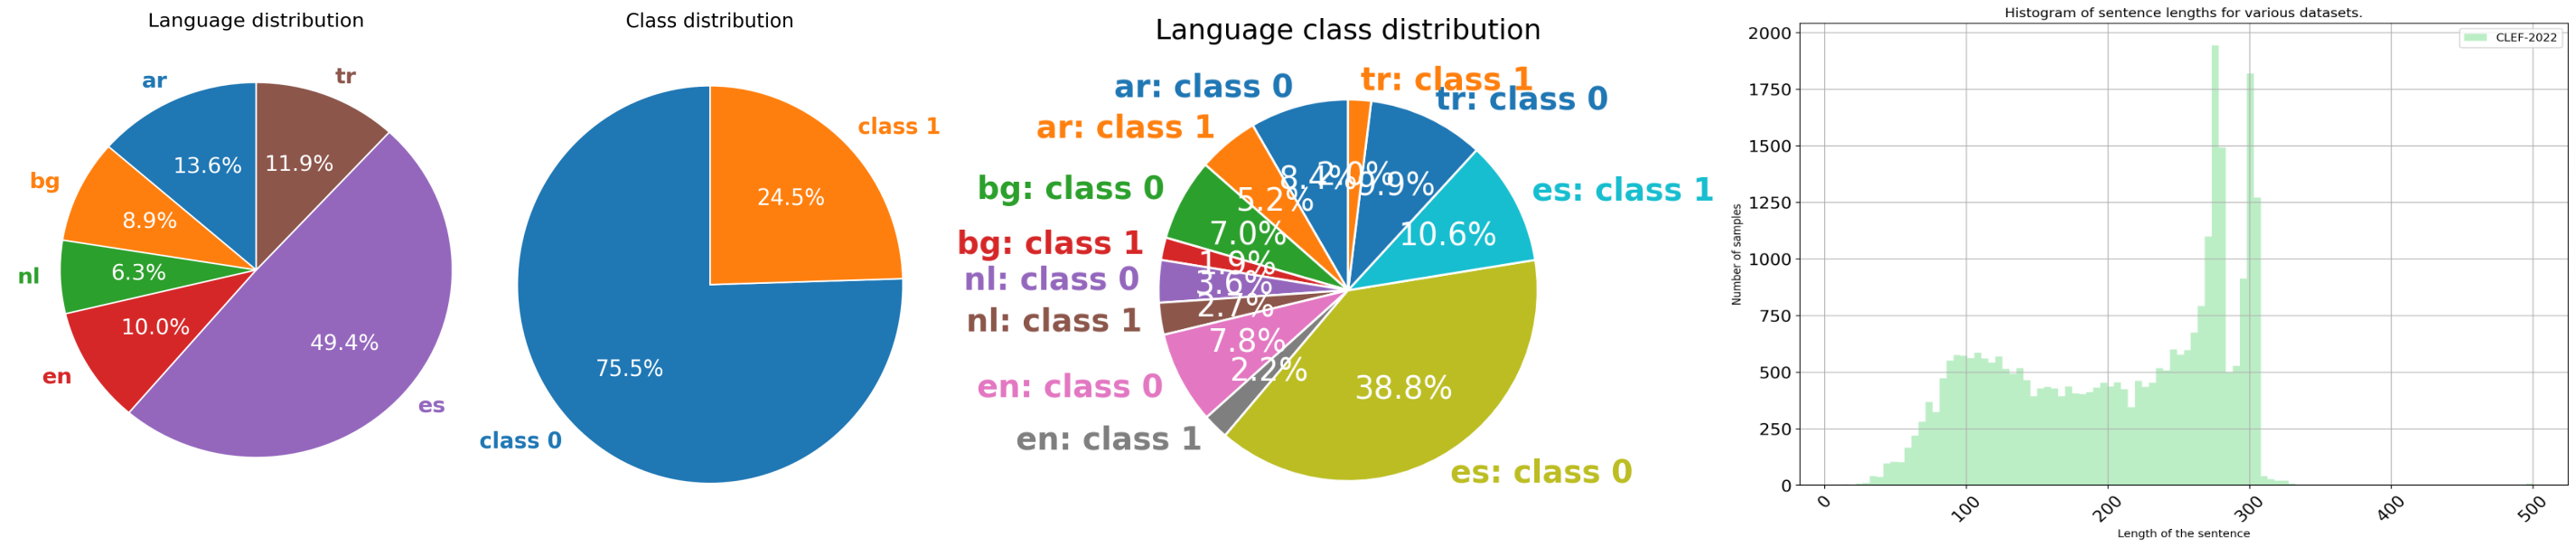

#### Download dataset:

In [3]:
import os
import shutil

from os.path import join

import pdb;

# Define paths
repo_url = 'https://gitlab.com/checkthat_lab/clef2022-checkthat-lab/clef2022-checkthat-lab.git'
clone_dir = join(datasets_path, 'clef2022-temp')

# Define source and destination directories
clef22_src_dir = os.path.join(clone_dir, 'task1', 'data')
clef22_dst_dir = join(datasets_path, 'CLEF2022', 'task 1A')

# Only download the dataset if necessarry
if not os.path.exists(clef22_dst_dir):
    %pip install gitpython patool
    import patoolib

    # Clone the repository if it doesn't exist
    if not os.path.exists(clone_dir):
        %pip install gitpython

        import git

        print('Downloading clef2022-checkthat-lab: ', end='')
        git.Repo.clone_from(repo_url, clone_dir)
        print('ok')

    print('Extracting task 1A: ', end='')

    # Ensure the destination directories exist
    os.makedirs(clef22_dst_dir, exist_ok=True)

    # Extract files from task1 that contain "1A"
    for root, _, files in os.walk(clef22_src_dir):
        for file in files:
            if '1A' in file:
                file_path = os.path.join(root, file)
                if file.endswith(('.zip', '.tar', '.gz', '.bz2')):
                    try:
                        # Extract the archive directly to the destination directory
                        patoolib.extract_archive(file_path, outdir=clef22_dst_dir, verbosity=-1)
                    except Exception as e:
                        print(f"Failed to extract {file_path}: {e}")

    # Find all the files and directories in the destination folder except for '.tsv' and '.txt' files
    for root, dirs, files in os.walk(clef22_dst_dir):
        for file in files:
            if not file.endswith('.tsv') and not file.endswith('.txt'):
                file_path = os.path.join(root, file)
                os.remove(file_path)
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)

    print('ok')

    shutil.rmtree(clone_dir)

    # List the extracted files
    print("Task 1A data list:\n", "\n".join(os.listdir(clef22_dst_dir)))
else:
    print('CLEF-2022 dataset ready.')

CLEF-2022 dataset ready.


#### Load dataset:

In [4]:
def load_clef(path: str, lang: str, ver='22', task='1A') -> tuple[DataFrame, DataFrame, DataFrame]:
    """
    Load's a particular language from a dataset folder structure.
     :param path: Path to a folder structure.
     :param lang: Particular language.
     :return: Train, validation and test set in a form of DataFrame.
     """
    # Format the path
    if ver == '22':
        prefix = f'CT22_{lang}_{task}_checkworthy_'
    elif ver == '23':
        prefix = f'CT23_{task}_checkworthy_{lang}_'
    else:
        print('Unsupported CLEF version!')
        return None, None, None

    # Load the data
    train = pd.read_csv(join(path, prefix + 'train.tsv'), sep='\t')
    dev = pd.concat([pd.read_csv(join(path, prefix + 'dev.tsv'), sep='\t'),
                      pd.read_csv(join(path, prefix + 'dev_test.tsv'), sep='\t')])
    test = pd.read_csv(join(path, prefix + 'test_gold.tsv'), sep='\t')

    # Format the DataFrame
    train_label = train[[col for col in train.columns if 'label' in col.lower()]]
    train_text = train[[col for col in train.columns if 'text' in col.lower()]]
    train = pd.concat([train_label, train_text], axis=1)
    train.columns = ['label', 'text']

    dev_label = dev[[col for col in dev.columns if 'label' in col.lower()]]
    dev_text = dev[[col for col in dev.columns if 'text' in col.lower()]]
    dev = pd.concat([dev_label, dev_text], axis=1)
    dev.columns = ['label', 'text']

    test_label = test[[col for col in test.columns if 'label' in col.lower()]]
    test_text = test[[col for col in test.columns if 'text' in col.lower()]]
    test = pd.concat([test_label, test_text], axis=1)
    test.columns = ['label', 'text']

    # Convert label values to 0 and 1 (if not already)
    # pd.set_option('future.no_silent_downcasting', True)
    train['label'] = train['label'].replace({'Yes': 1, 'No': 0})
    dev['label'] = dev['label'].replace({'Yes': 1, 'No': 0})
    test['label'] = test['label'].replace({'Yes': 1, 'No': 0})

    return train, dev, test

In [5]:
codes = ['ar', 'bg', 'nl', 'en', 'es', 'tr']
languages = ['arabic', 'bulgarian', 'dutch', 'english', 'spanish', 'turkish']

train = []
dev = []
test = []
table = []

clef22_dst_dir = join(datasets_path, 'CLEF2022', 'task 1A')

print('Loading CLEF-2022 dataset:\n')
for lang, code in zip(languages, codes):
    _train, _dev, _test = load_clef(clef22_dst_dir, lang,ver='22', task='1A')

    _train['lang'] = code
    _dev['lang'] = code
    _test['lang'] = code

    # Covid-19 topic to be more specific
    _train['topic'] = 'health'
    _dev['topic'] = 'health'
    _test['topic'] = 'health'

    # Add writing style
    _train['style'] = 'noisy'
    _dev['style'] = 'noisy'
    _test['style'] = 'noisy'

    _train = _train[['lang', 'topic', 'style', 'label', 'text']]
    _dev = _dev[['lang', 'topic', 'style', 'label', 'text']]
    _test = _test[['lang', 'topic', 'style', 'label', 'text']]

    # Add language
    train.append(_train)
    dev.append(_dev)
    test.append(_test)

    table.append({"Language": code,
                  "train": _train.shape[0],
                  "dev": _dev.shape[0],
                  "test": _test.shape[0],
                  "overall": _train.shape[0] + _dev.shape[0] + _test.shape[0]})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))

clef2022 = pd.concat([pd.concat(train), pd.concat(dev), pd.concat(test)], axis=0)
clef2022 = filter_dataframe(clef2022)
print(f"\nColumns: {clef2022.columns.tolist()}")

Loading CLEF-2022 dataset:

|Language|train| dev|test|overall|
|--------|-----|----|----|-------|
|   ar   | 2513| 926| 682|  4121 |
|   bg   | 1871| 696| 130|  2697 |
|   nl   | 923 | 324| 666|  1913 |
|   en   | 2122| 769| 149|  3040 |
|   es   | 4990|5000|5000| 14990 |
|   tr   | 2417| 882| 303|  3602 |

Columns: ['lang', 'topic', 'style', 'label', 'text']


#### Statistics:

| Languages: | ar | bg | nl | en | es | tr |
|------------|-------|-------|-------|-------|-------|-------|
| Samples:   | 4121 | 2696 | 1913 | 3040 | 14990 | 3602 |
| Ratio:     | 13.57% | 8.88% | 6.3% | 10.01% | 49.37% | 11.86% |

Language distribution


/home/hyben/.conda/envs/MultiCW-dataset/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


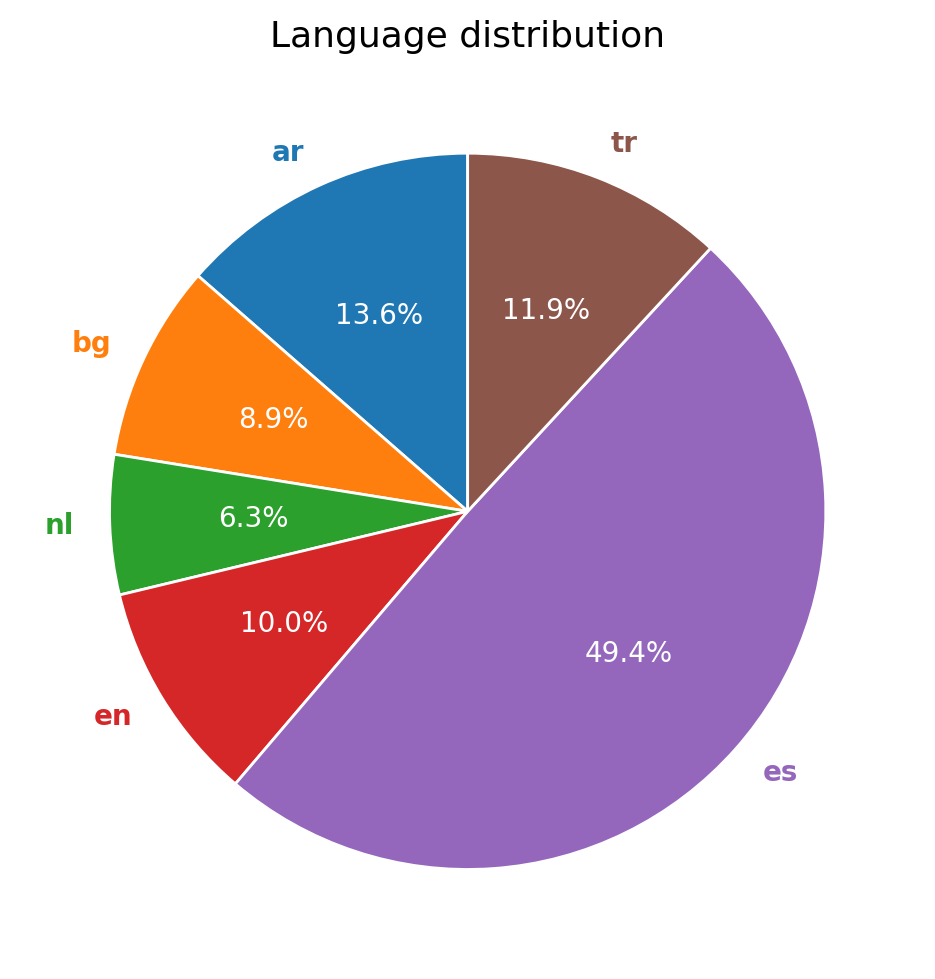

|Class 0:|Class 1:|
|--------|--------|
| 75.48% | 24.52% |
Class distribution


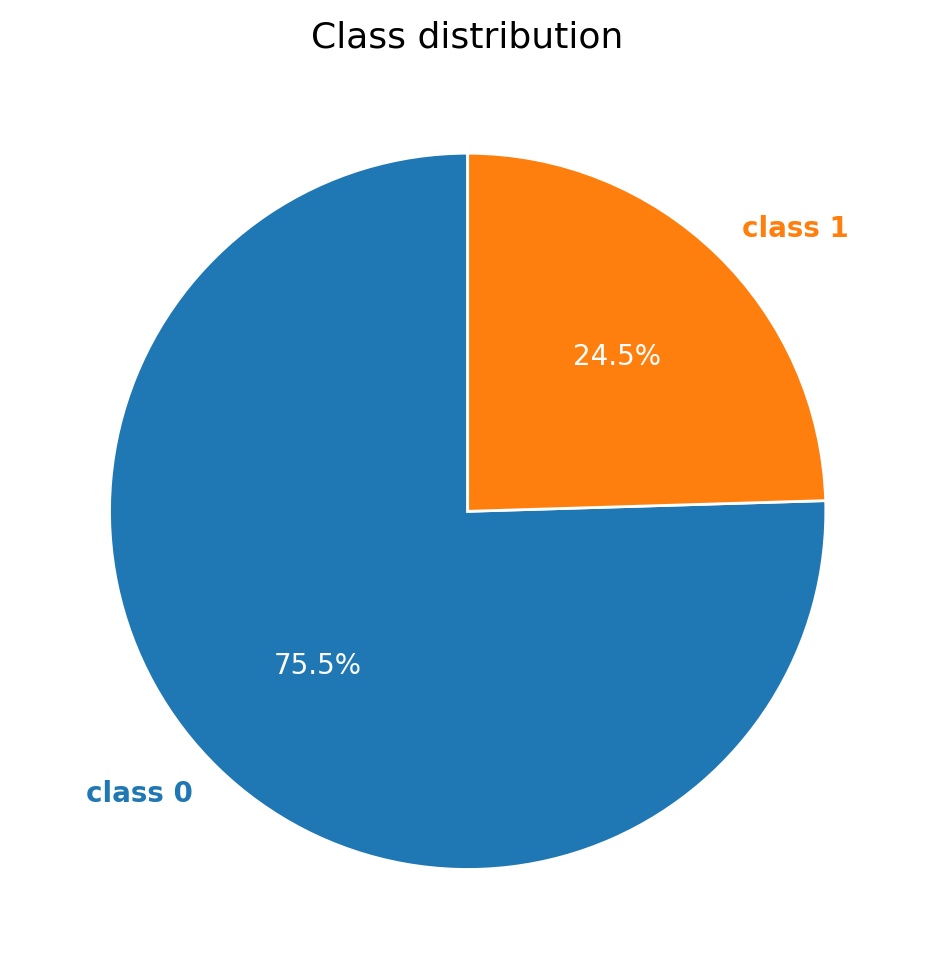

|Language:|Class 0:|Class 0 Ratio:|Class 1:|Class 1 Ratio:|
|---------|--------|--------------|--------|--------------|
|    ar   |  2546  |     8.39%    |  1575  |     5.19%    |
|    bg   |  2119  |     6.98%    |   577  |     1.9%     |
|    nl   |  1090  |     3.59%    |   823  |     2.71%    |
|    en   |  2381  |     7.84%    |   659  |     2.17%    |
|    es   |  11773 |    38.78%    |  3217  |     10.6%    |
|    tr   |  3007  |     9.9%     |   595  |     1.96%    |
Language class distribution


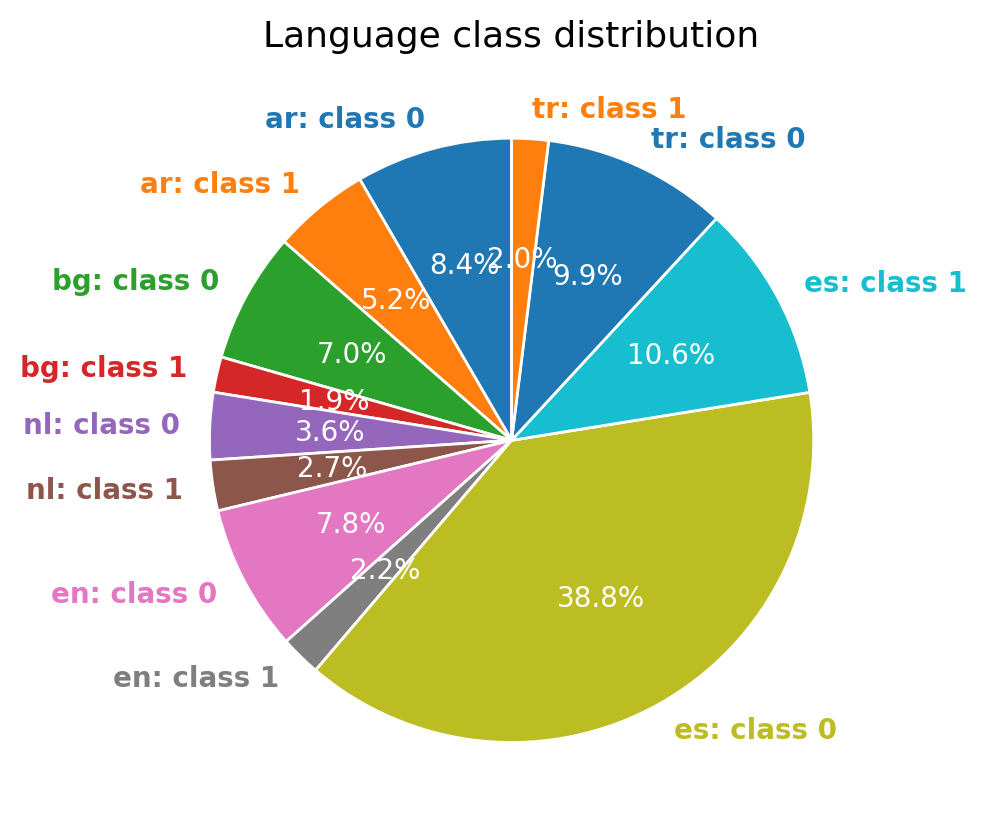

| Dataset |Avg. length:|
|---------|------------|
|CLEF-2022|   204.96   |


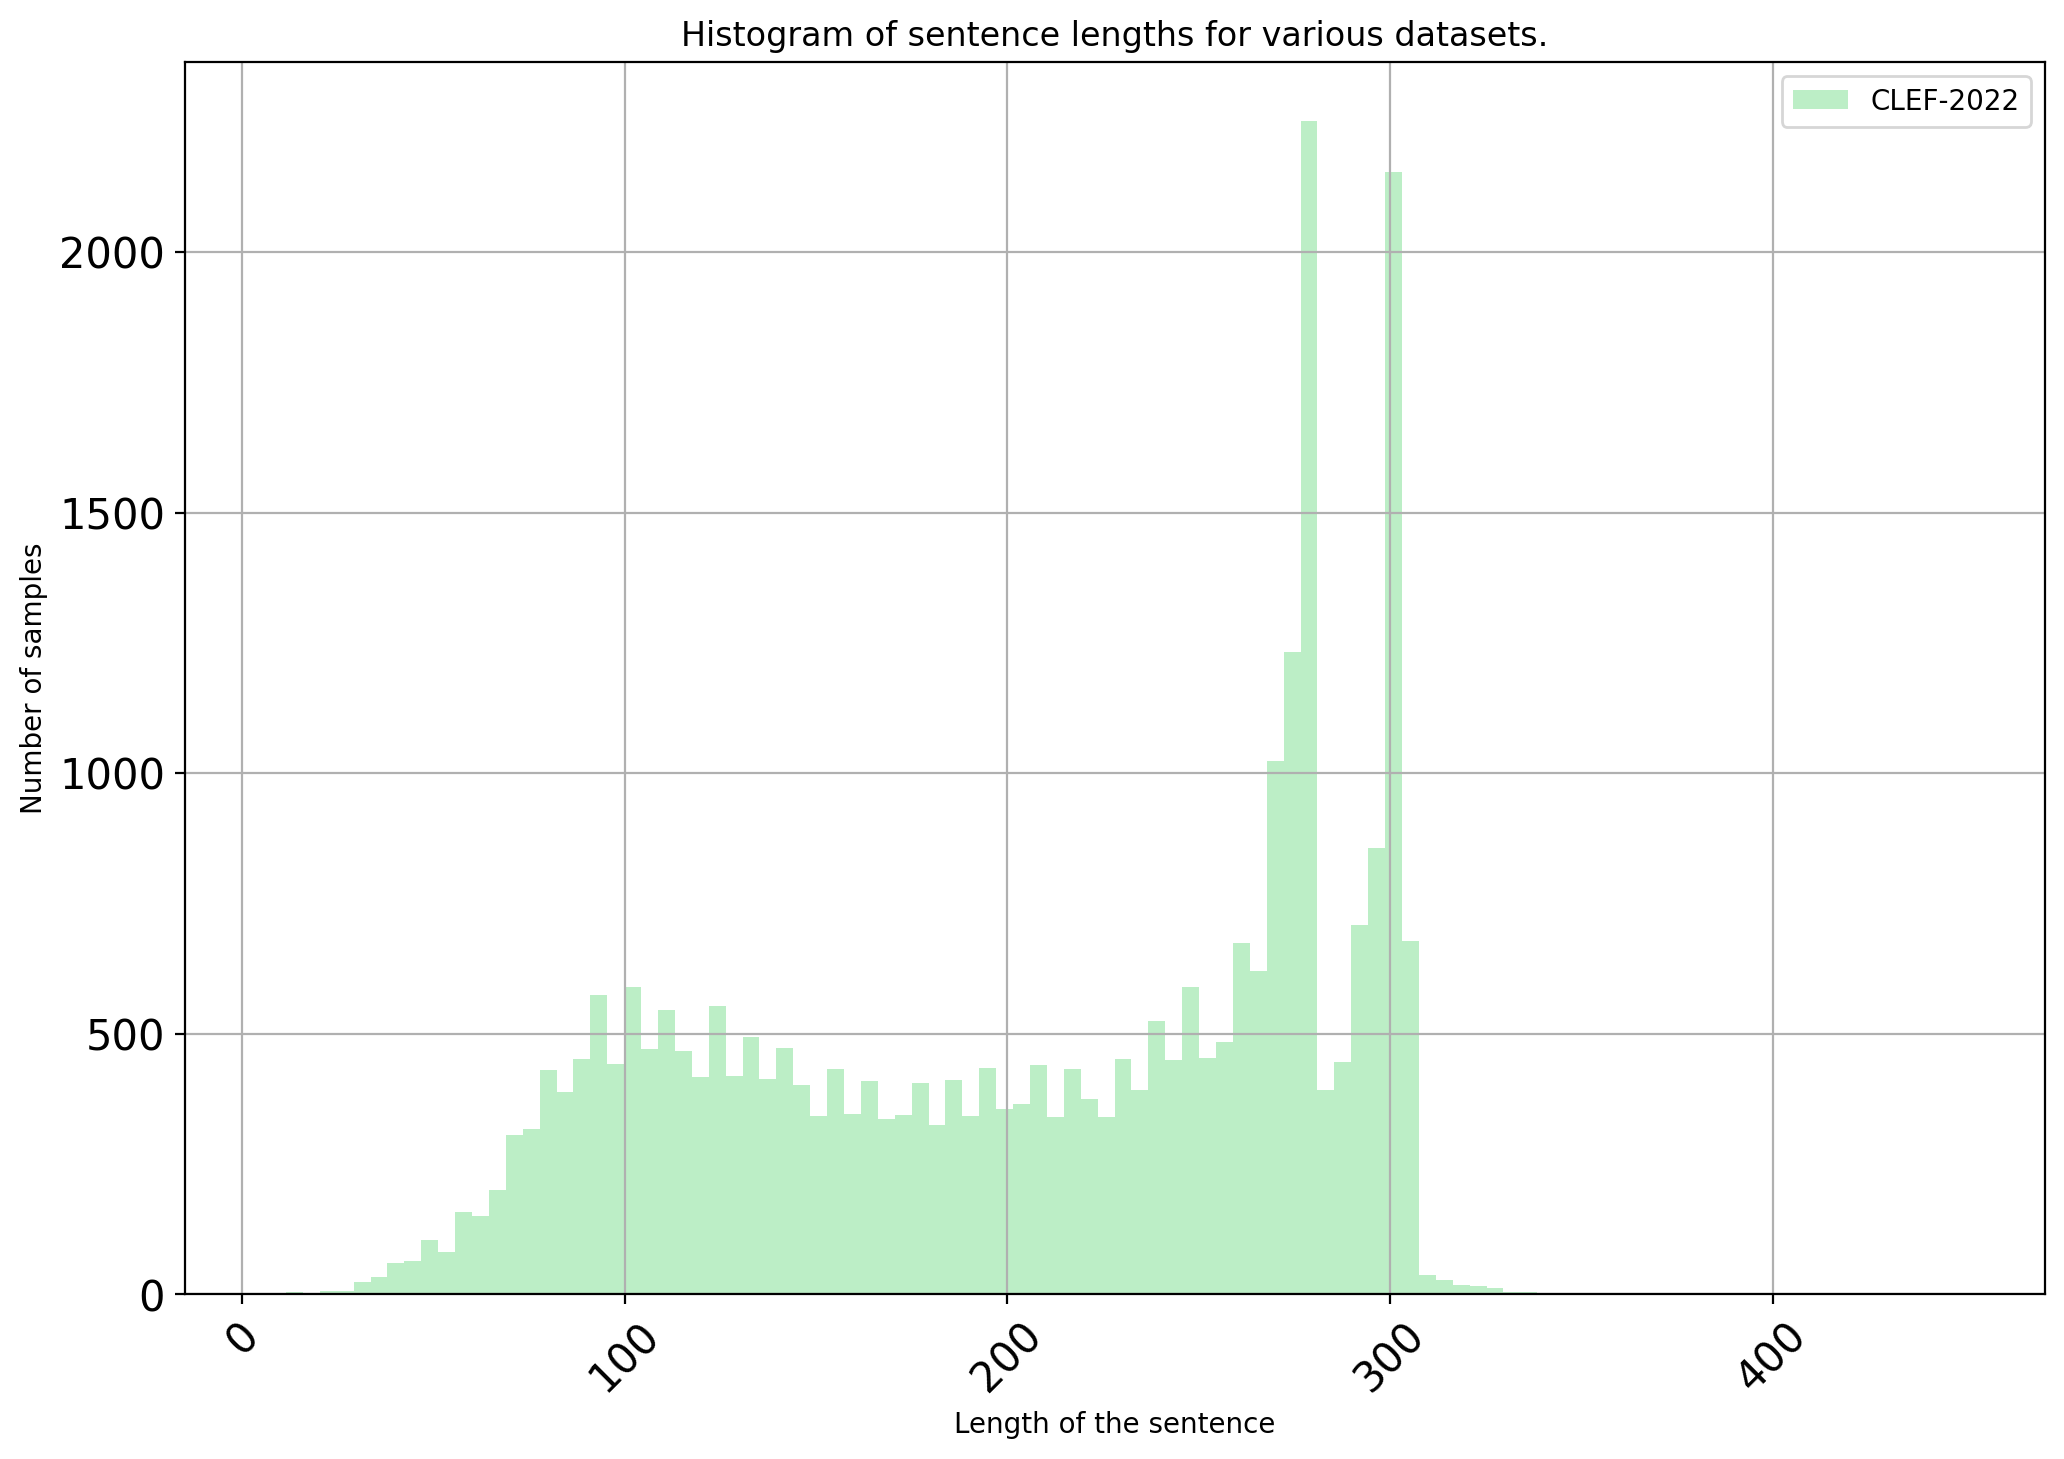

In [6]:
data = lang_distribution(clef2022)
pie_chart(title='Language distribution', data=data)

data = class_distribution(clef2022)
pie_chart(title='Class distribution', data=data)

data = lang_classes_distribution(clef2022)
pie_chart(title='Language class distribution', data=data)

histogram({'CLEF-2022': clef2022})

### CLEF-2023 
[Paper](https://ceur-ws.org/Vol-3497/paper-019.pdf) [Data](https://gitlab.com/checkthat_lab/clef2023-checkthat-lab.git)

|Language|train| dev|test|Samples:|Ratio:|Class 0:| Ratio |Class 1:| Ratio|
|--------|-----|----|----|--------|------|--------|--------|-----|------|
| arabic | 6059|2367| 500|  8926  |13.85%|  5895  |  9.15% |3031 | 4.7% |
| english|16824|6641| 318|  23783 |36.91%|  18034 | 27.99% |5749 | 8.92%|
| spanish|**19269**|7460|5000|  31729 |49.24%|  16228 | 25.18% |15501|24.06%|

|Class 0:|Class 1:|
|--------|--------|
| 62.32% | 37.68% |

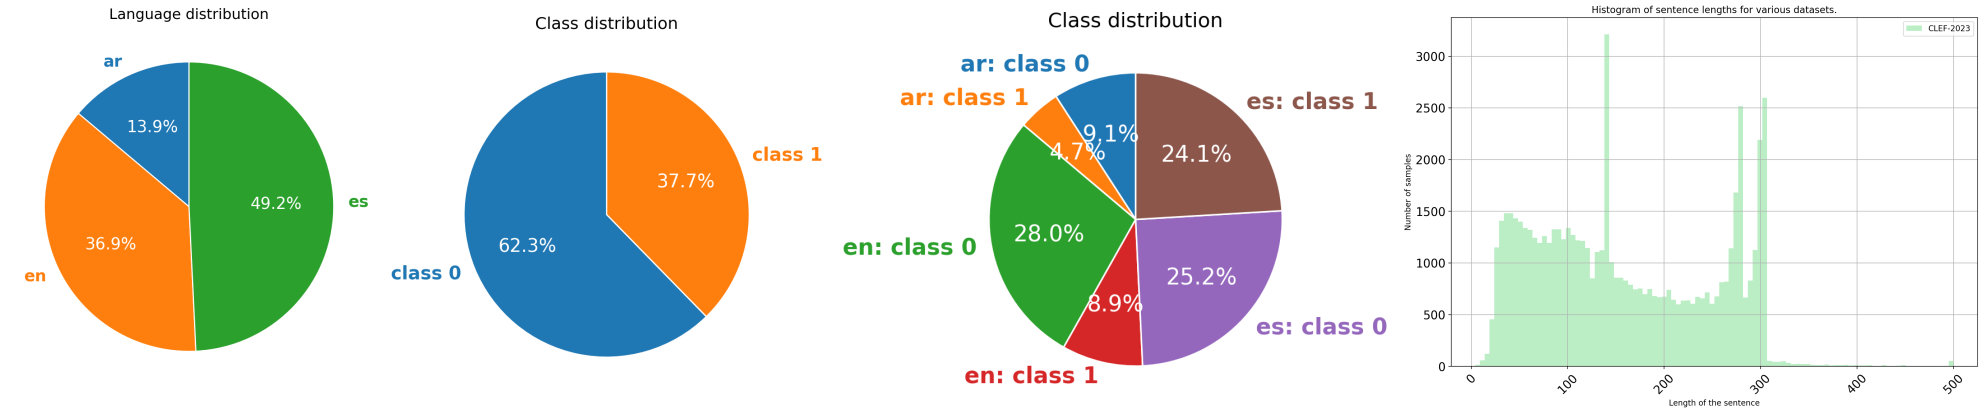

#### Download the dataset:

In [7]:
import os
import shutil

from os.path import join

# Clone the repository
repo_url = 'https://gitlab.com/checkthat_lab/clef2023-checkthat-lab.git'
clone_dir = join(datasets_path, 'clef2023-temp')

# Define source and destination directories
clef23_src_dir = os.path.join(clone_dir, 'task1', 'data')
clef23_dst_dir = join(datasets_path, 'CLEF2023', 'task 1B')


# Only download the dataset if necessarry
if not os.path.exists(clef23_dst_dir):
    !pip install gitpython patool
    import patoolib

    if not os.path.exists(clone_dir):
        print('Downloading clef2023-checkthat-lab: ', end='')
        git.Repo.clone_from(repo_url, clone_dir)
        print('ok')

    print('Extracting task 1B: ', end='')

    # Ensure the destination directories exist
    os.makedirs(clef23_dst_dir, exist_ok=True)

    # Copy and decompress files from task1 that contain "1B"
    for root, _, files in os.walk(clef23_src_dir):
        for file in files:
            if '1B' in file:
                file_path = os.path.join(root, file)
                dest_path = os.path.join(clef23_dst_dir, file)
                shutil.copy(file_path, dest_path)
                if file.endswith(('.zip', '.tar', '.gz', '.bz2')):
                    patoolib.extract_archive(dest_path, outdir=clef23_dst_dir, verbosity=-1)
                    os.remove(dest_path)

    # Remove all the files and directories in the destination folder except for '.tsv' and '.txt' files
    for root, dirs, files in os.walk(clef23_dst_dir):
        for file in files:
            if not file.endswith('.tsv') and not file.endswith('.txt') and not file.endswith('.jsonl'):
                file_path = os.path.join(root, file)
                os.remove(file_path)
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)

    shutil.rmtree(clone_dir)

    # List the extracted files
    print("Task 1B data list:\n", "\n".join(os.listdir(clef23_dst_dir)))
else:
    print('CLEF-2023 dataset ready.')

CLEF-2023 dataset ready.


#### Load the dataset:

In [8]:
codes = ['ar', 'en', 'es']
languages = ['arabic', 'english', 'spanish']

train = []
dev = []
test = []
table = []

clef23_dst_dir = join(datasets_path, 'CLEF2023', 'task 1B')

print('Loading CLEF-2023 dataset:\n')
# Process all the .tsv files
for lang, code in zip(languages, codes):
    _train, _dev, _test = load_clef(clef23_dst_dir, lang, ver='23', task='1B')

    _train['lang'] = code
    _dev['lang'] = code
    _test['lang'] = code

    # Covid-19 topic to be more specific
    _train['topic'] = 'health'
    _dev['topic'] = 'health'
    _test['topic'] = 'health'

    # Add writing style
    _train['style'] = 'noisy'
    _dev['style'] = 'noisy'
    _test['style'] = 'noisy'

    _train = _train[['lang', 'topic', 'style', 'label', 'text']]
    _dev = _dev[['lang', 'topic', 'style', 'label', 'text']]
    _test = _test[['lang', 'topic', 'style', 'label', 'text']]

    # Add language
    train.append(_train)
    dev.append(_dev)
    test.append(_test)

# Process the .jsonl file
tweets = pd.read_json(join(clef23_dst_dir, 'CT23_1B_checkworthy_spanish_tweets.jsonl'), lines=True)
tweets = tweets[tweets['lang'] == 'es']
# tweets = tweets[tweets['referenced_tweets'].isnull()]
tweets = tweets[['text', 'lang']]
tweets['label'] = 1
tweets['topic'] = 'None'
tweets['style'] = 'noisy'
tweets = tweets[['lang', 'topic', 'style', 'label', 'text']]
train.append(tweets)

train = pd.concat(train).drop_duplicates(subset='text', keep='first')
dev = pd.concat(dev).drop_duplicates(subset='text', keep='first')
test = pd.concat(test).drop_duplicates(subset='text', keep='first')

# Print out statistics
for lang, code in zip(languages, codes):
    _train = train[train['lang'] == code]
    _dev = dev[dev['lang'] == code]
    _test = test[test['lang'] == code]

    table.append({"Language": code,
                  "train": _train.shape[0],
                  "dev": _dev.shape[0],
                  "test": _test.shape[0],
                  "overall": _train.shape[0] + _dev.shape[0] + _test.shape[0]})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))

clef2023 = pd.concat([train, dev, test], axis=0)
clef2023 = filter_dataframe(clef2023)
print(f"\nColumns: {clef2023.columns.tolist()}")

Loading CLEF-2023 dataset:

|Language|train| dev|test|overall|
|--------|-----|----|----|-------|
|   ar   | 6059|2367| 500|  8926 |
|   en   |16824|6641| 318| 23783 |
|   es   |19269|7460|5000| 31729 |

Columns: ['lang', 'topic', 'style', 'label', 'text']


#### Statistics:

| Languages: | ar | en | es |
|------------|-------|-------|-------|
| Samples:   | 8926 | 23783 | 31728 |
| Ratio:     | 13.85% | 36.91% | 49.24% |

Language distribution


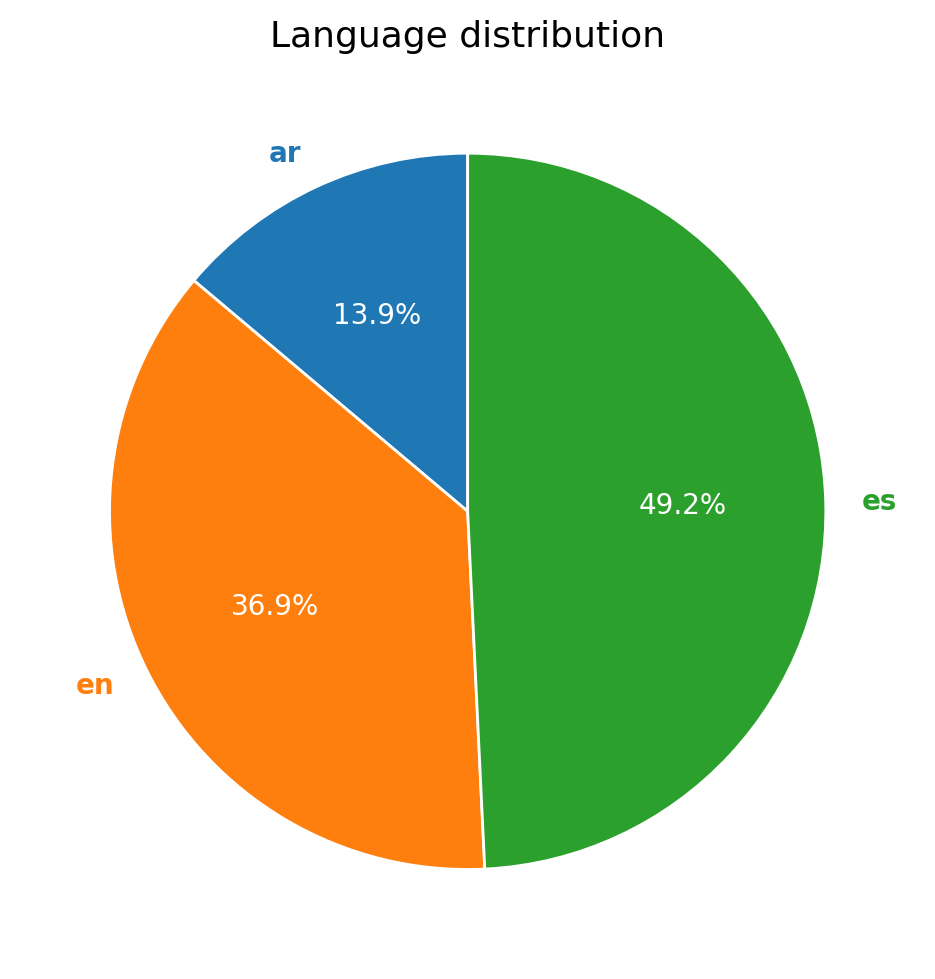

|Class 0:|Class 1:|
|--------|--------|
| 62.32% | 37.68% |
Class distribution


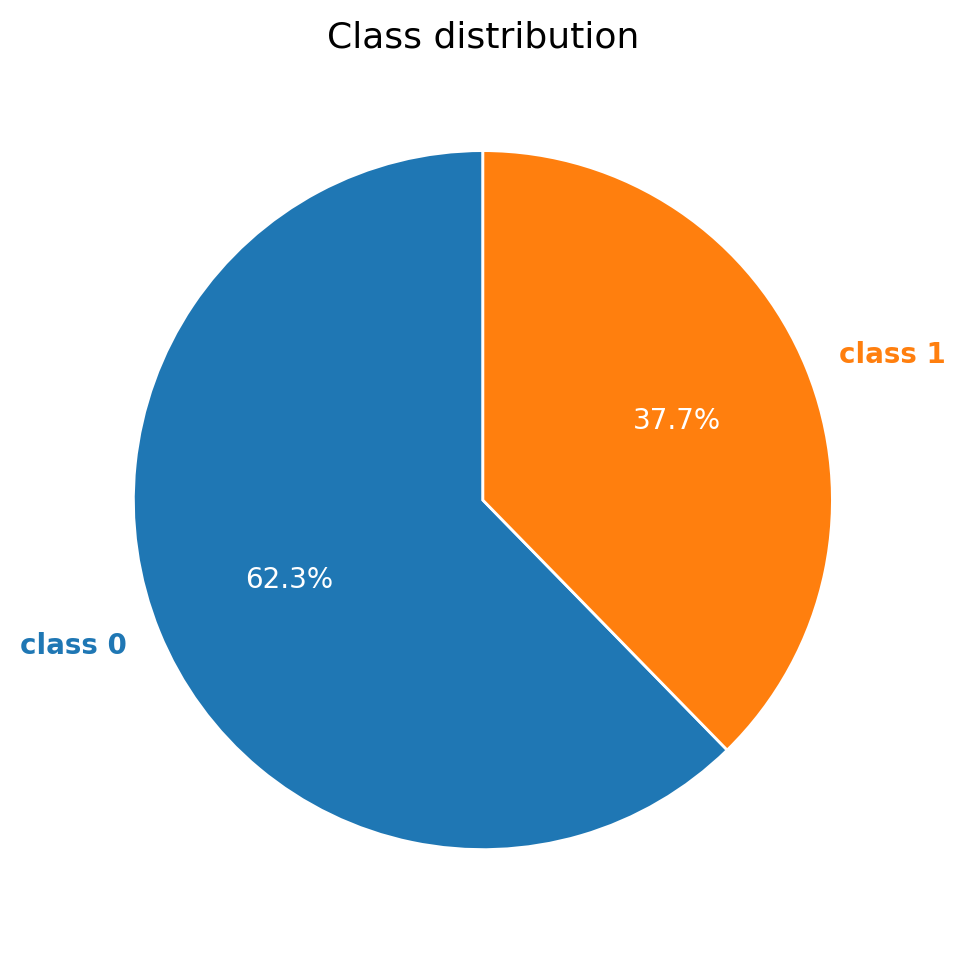

|Language:|Class 0:|Class 0 Ratio:|Class 1:|Class 1 Ratio:|
|---------|--------|--------------|--------|--------------|
|    ar   |  5895  |     9.15%    |  3031  |     4.7%     |
|    en   |  18034 |    27.99%    |  5749  |     8.92%    |
|    es   |  16227 |    25.18%    |  15501 |    24.06%    |
Class distribution


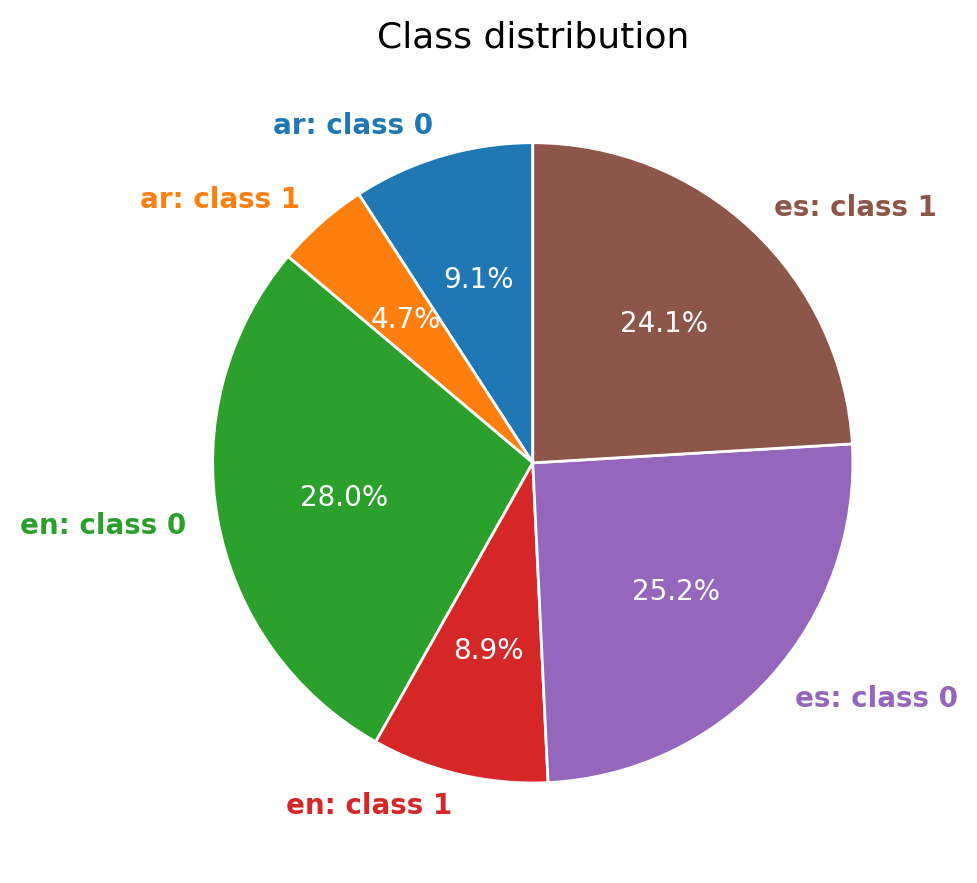

| Dataset |Avg. length:|
|---------|------------|
|CLEF-2023|   159.69   |


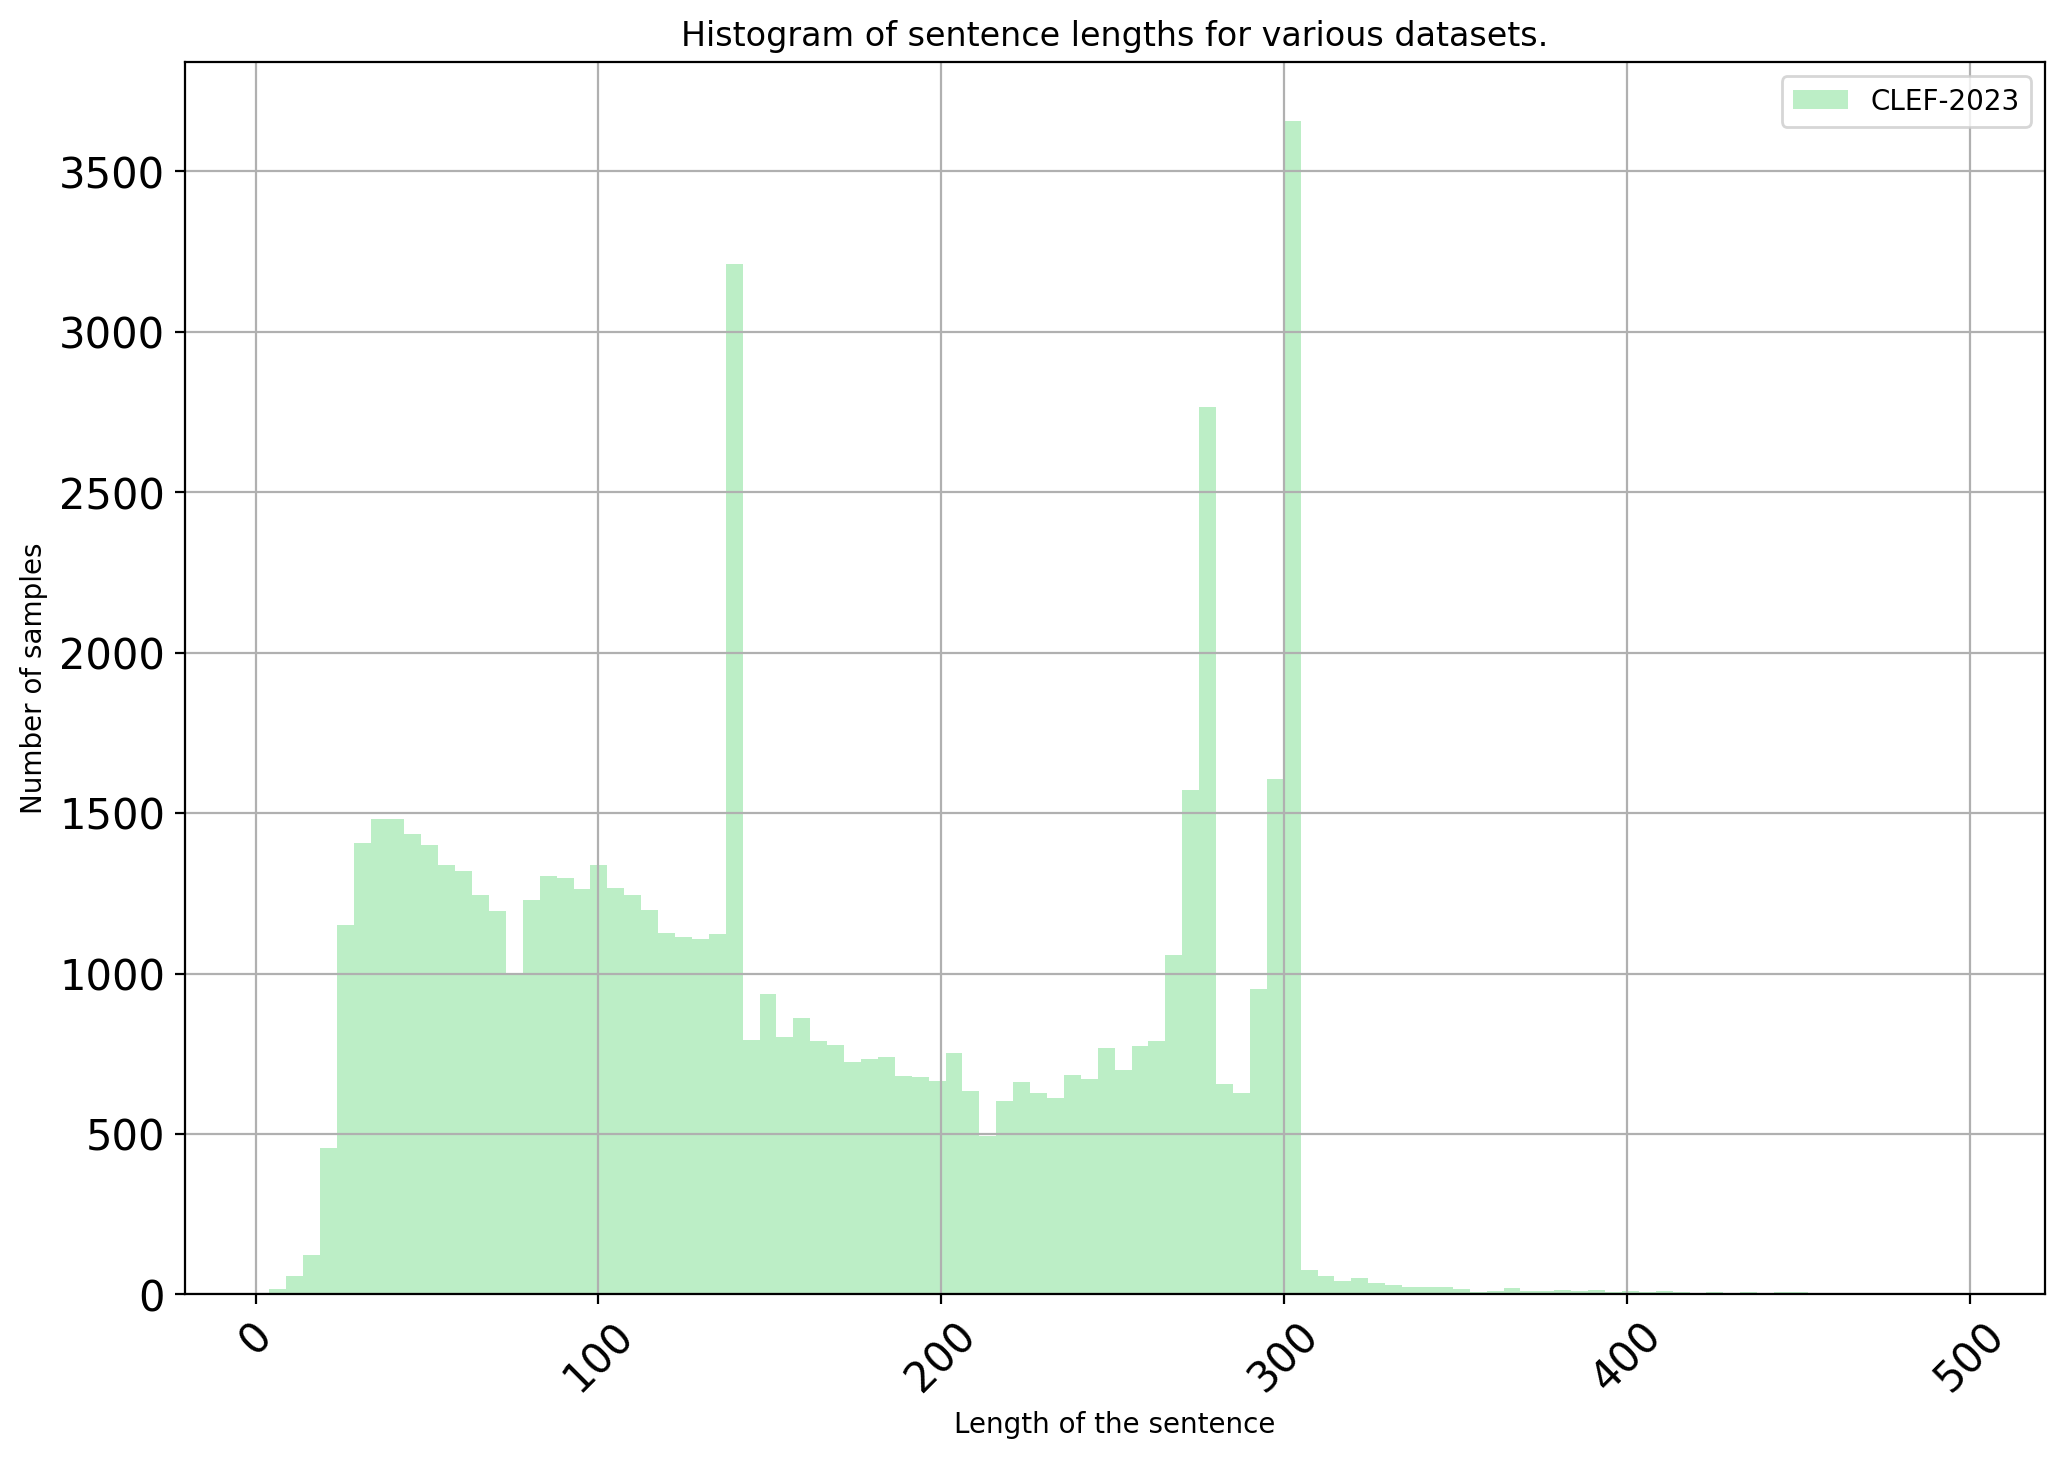

In [9]:
data = lang_distribution(clef2023)
pie_chart(title='Language distribution', data=data)

data = class_distribution(clef2023)
pie_chart(title='Class distribution', data=data)

data = lang_classes_distribution(clef2023)
pie_chart(title='Class distribution', data=data)

histogram({'CLEF-2023': clef2023})

### MultiClaim Fact-Checks (Zenodo)
Here is the transposed table with languages on the horizontal axis:

Here is the transposed version of the table:

|           | eng   | ara   | por   | fra  | nld | msa  | ben  | pol  | spa   | ita  | rus  | hbs  | tur  | deu  | hin  | ell  | mkd | tel  | mal  | zho  | tam  |
|-----------|-------|-------|-------|------|-----|------|------|------|-------|------|------|------|------|------|------|------|-----|------|------|------|------|
| Samples:  | 85814 | 14201 | 21569 | 4355 | 1232| 8424 | 4143 | 6912 | 14082 | 3047 | 2715 | 2451 | 6676 | 4996 | 7149 | 1821 | 1125| 2450 | 1206 | 2586 | 1612 |
| Ratio:    | 43.22%| 7.15% |10.86% | 2.19%|0.62%| 4.24%| 2.09%| 3.48%| 7.09% | 1.53%| 1.37%| 1.23%| 3.36%| 2.52%| 3.6% | 0.92%|0.57%| 1.23%| 0.61%| 1.3% | 0.81%|

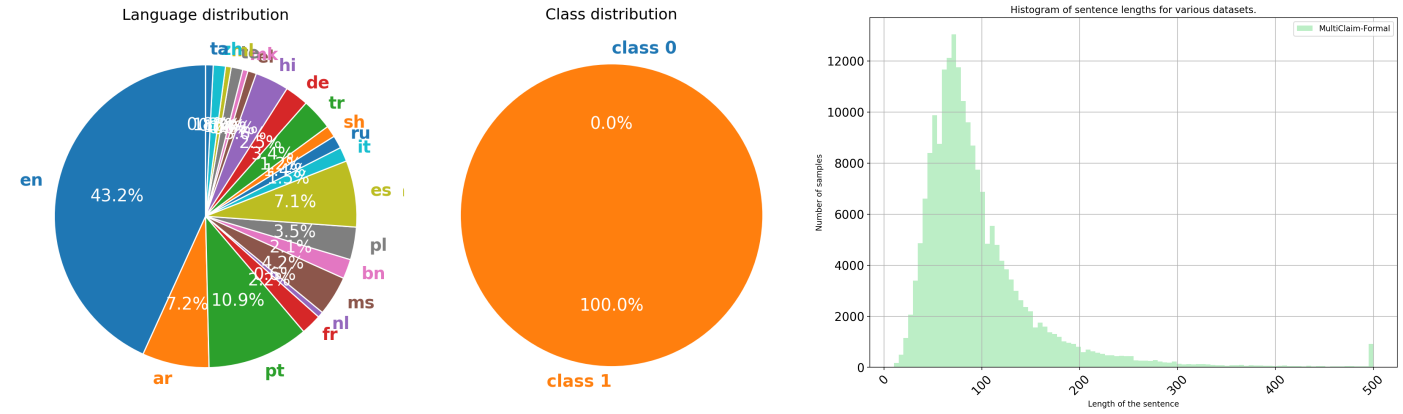

#### Load the dataset:
The dataset was published at [Zenodo](https://zenodo.org/records/7737983) and is available on demand of research and non-commercial purposes.

In [10]:
assert exists(multiclaim_path), 'Please download the dataset and setup the path to it in `multiclaim_path` variable!'

from iso639 import Lang
def convert_iso639(lang: str):
  try:
    return Lang(lang).pt1
  except:
    return lang

def load_fact_checks() -> DataFrame:
    # Define a function to parse the JSON in each row
    def parse_row(row):
        claim_data = ast.literal_eval(row['claim'])
        instances_data = ast.literal_eval(row['instances'])

        # Extracting claim text, language, and URL
        text = claim_data[0]
        lang = convert_iso639(claim_data[2][0][0])
        url = instances_data[0][1]
        style = 'structured'
        label = 1
        topic = 'TODO'

        return pd.Series([lang, topic, style, label, text])

    # Load fact-checks from the csv
    fact_checks = pd.read_csv(join(multiclaim_zenodo_path, 'fact_checks.csv'))

    # Apply the function to each row
    fact_checks = fact_checks.progress_apply(parse_row, axis=1)
    fact_checks.columns = ['lang', 'topic', 'style', 'label', 'text']

    return fact_checks

print('Loading fact-checks from MultiClaim dataset: ', end='')
mc_zenodo_fc = load_fact_checks()
mc_zenodo_fc = filter_dataframe(mc_zenodo_fc)
print('done')

table = []

# Calculate the total number of samples to compute the ratio
total_samples = mc_zenodo_fc.shape[0]

# Loop through each unique language in the DataFrame
for lang in mc_zenodo_fc['lang'].unique():
  subset = mc_zenodo_fc[mc_zenodo_fc['lang'] == lang]
  table.append({'Language': lang,
                'Samples:': subset.shape[0],
                'Ratio:': f"{(subset.shape[0] / total_samples) * 100:.2f}%"})


markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))
print(f"\nColumns: {mc_zenodo_fc.columns.tolist()}")

Loading fact-checks from MultiClaim dataset: 

100%|█████████████████████████████████| 205751/205751 [00:29<00:00, 7018.17it/s]


done
|Language|Samples:|Ratio:|
|--------|--------|------|
|   en   |  85814 |41.71%|
|   ar   |  14201 | 6.90%|
|   pt   |  21566 |10.48%|
|   fr   |  4355  | 2.12%|
|   nl   |  1232  | 0.60%|
|   ms   |  8424  | 4.09%|
|   bn   |  4143  | 2.01%|
|   pl   |  6912  | 3.36%|
|   es   |  14082 | 6.84%|
|   ko   |   510  | 0.25%|
|   it   |  3047  | 1.48%|
|   ru   |  2715  | 1.32%|
|        |  2485  | 1.21%|
|   hu   |   139  | 0.07%|
|   tr   |  6676  | 3.24%|
|   ca   |   574  | 0.28%|
|   de   |  4996  | 2.43%|
|   hi   |  7149  | 3.47%|
|   da   |   648  | 0.31%|
|   co   |   12   | 0.01%|
|   jw   |   15   | 0.01%|
|   el   |  1821  | 0.89%|
|   uz   |   14   | 0.01%|
|   uk   |   68   | 0.03%|
|   mk   |  1125  | 0.55%|
|   he   |   202  | 0.10%|
|   te   |  2450  | 1.19%|
|   ml   |  1206  | 0.59%|
|   zh   |  2586  | 1.26%|
|   si   |   825  | 0.40%|
|   ta   |  1612  | 0.78%|
|   km   |   144  | 0.07%|
|   sq   |   726  | 0.35%|
|   as   |   60   | 0.03%|
|   th   |   382  | 0.1

#### Statistics:

| Languages: | en | ar | pt | fr | nl | ms | bn | pl | es | it | ru |  | tr | de | hi | el | mk | te | ml | zh | ta |
|------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Samples:   | 85814 | 14201 | 21566 | 4355 | 1232 | 8424 | 4143 | 6912 | 14082 | 3047 | 2715 | 2485 | 6676 | 4996 | 7149 | 1821 | 1125 | 2450 | 1206 | 2586 | 1612 |
| Ratio:     | 41.71% | 6.9% | 10.48% | 2.12% | 0.6% | 4.09% | 2.01% | 3.36% | 6.84% | 1.48% | 1.32% | 1.21% | 3.24% | 2.43% | 3.47% | 0.89% | 0.55% | 1.19% | 0.59% | 1.26% | 0.78% |

Language distribution


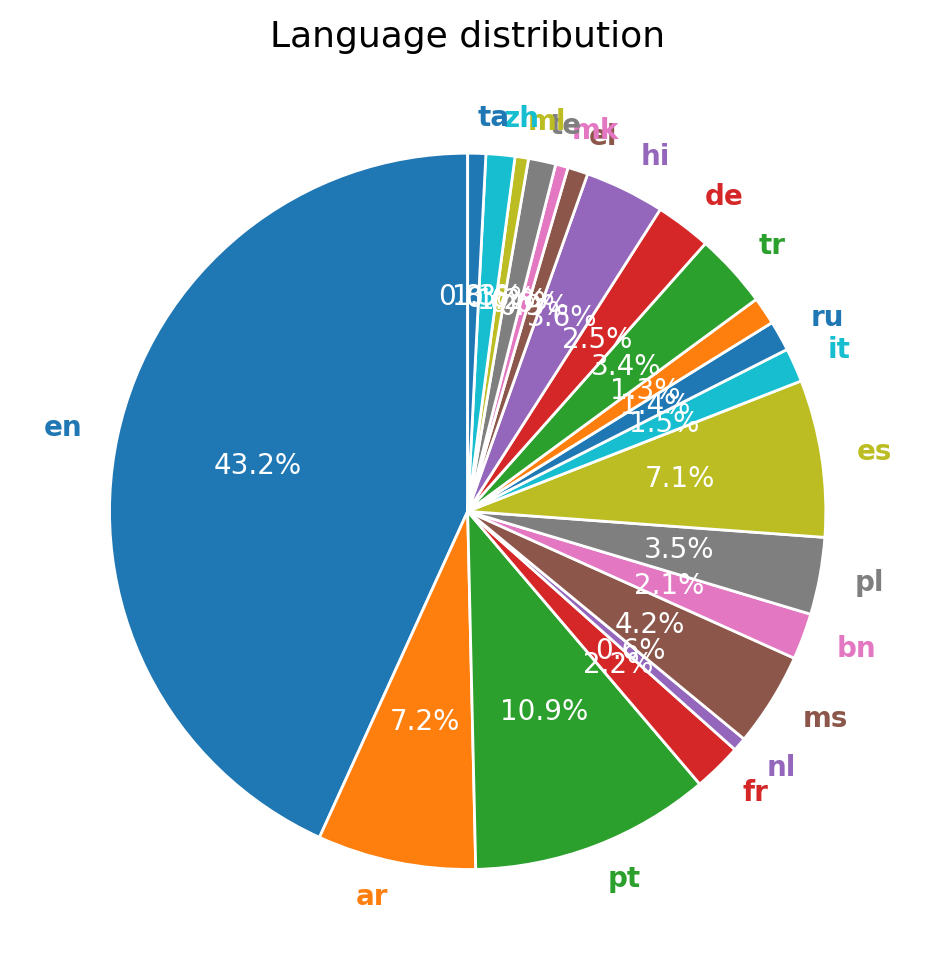

|Class 0:|Class 1:|
|--------|--------|
|  0.0%  | 100.0% |
Class distribution


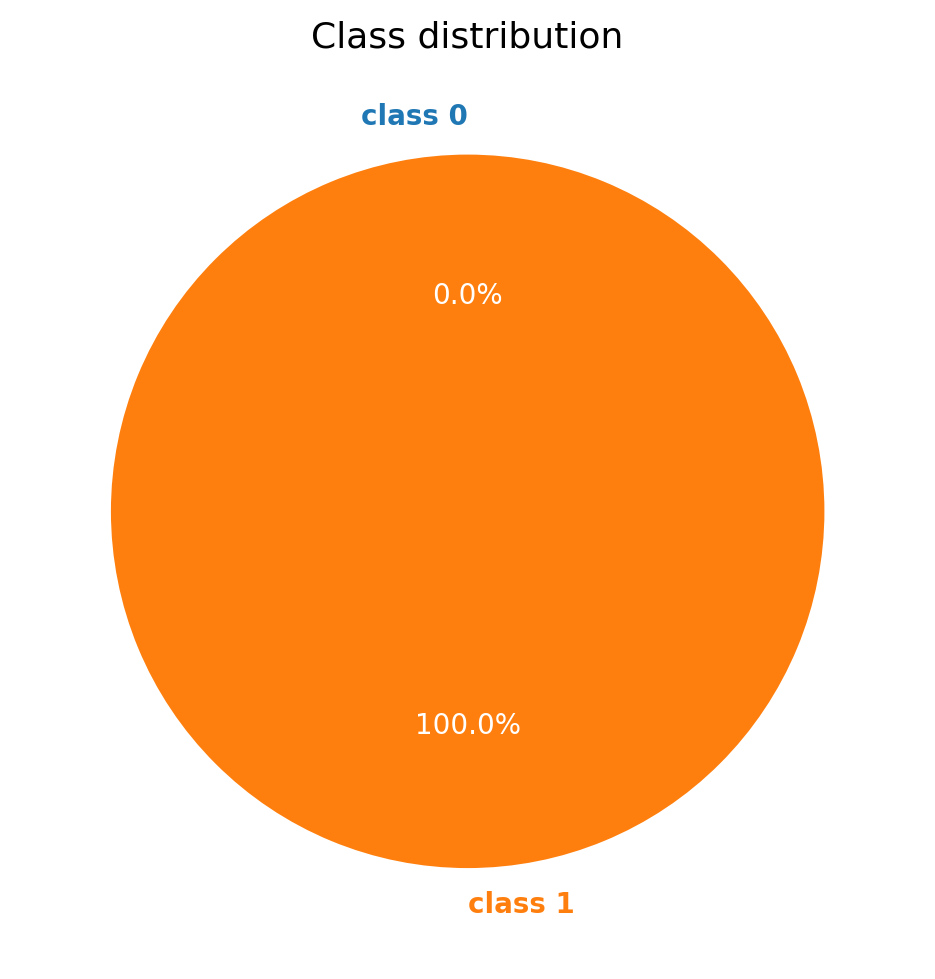

|     Dataset     |Avg. length:|
|-----------------|------------|
|MultiClaim-Formal|    95.22   |


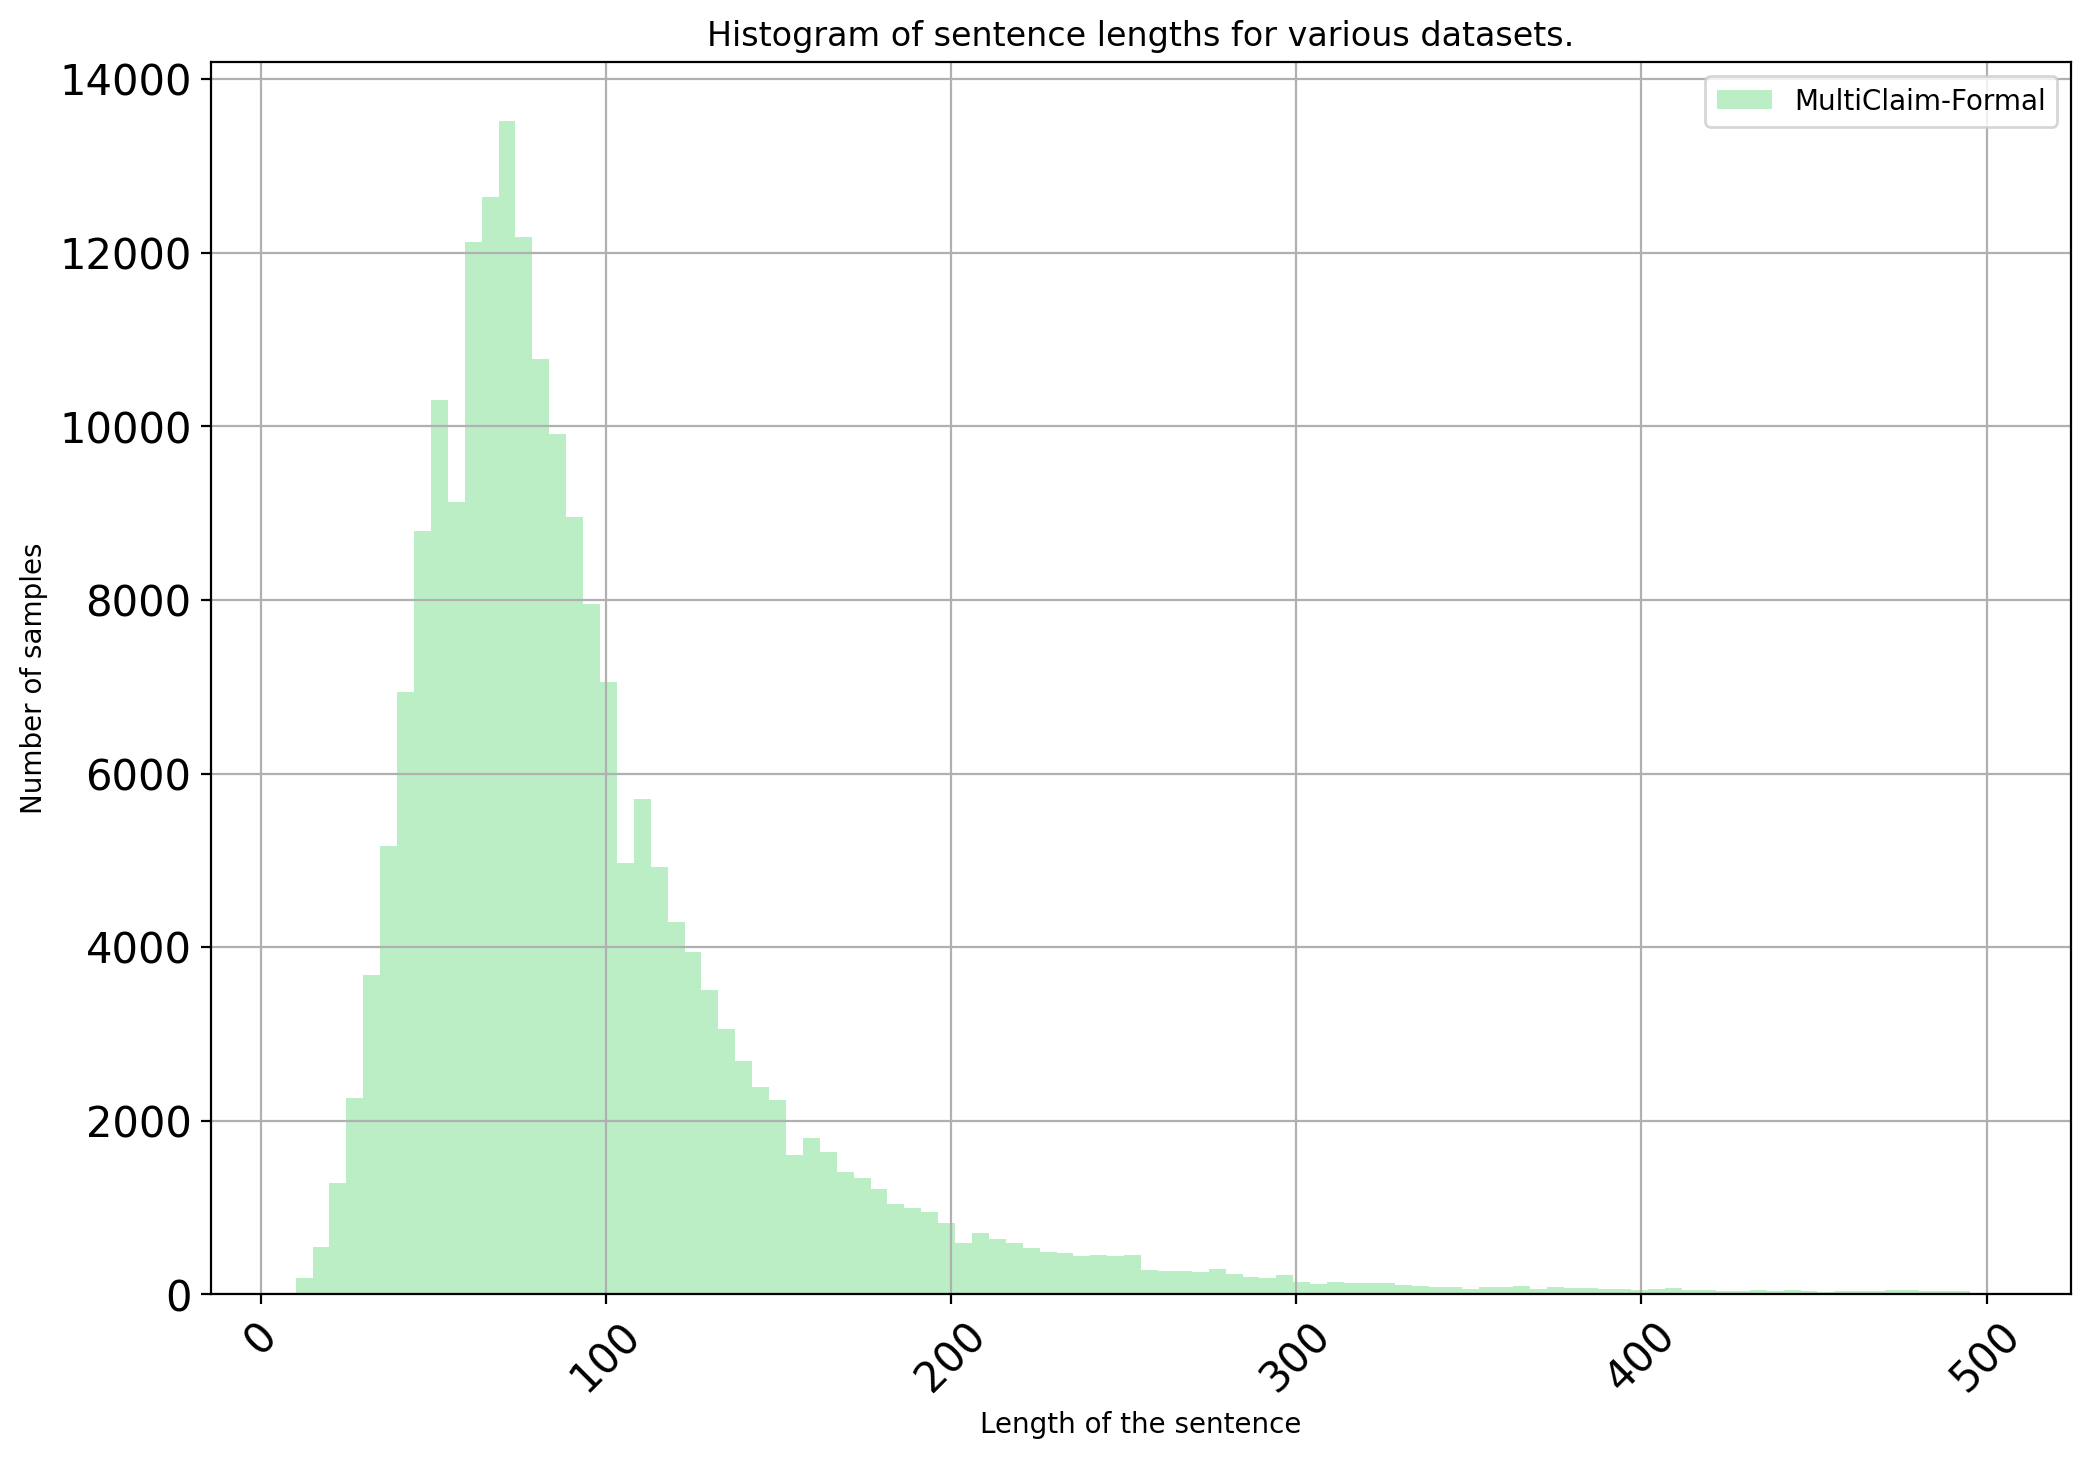

In [11]:
data = lang_distribution(mc_zenodo_fc)
pie_chart(title='Language distribution', data=data)

data = class_distribution(mc_zenodo_fc)
pie_chart(title='Class distribution', data=data)

histogram({'MultiClaim-Formal': mc_zenodo_fc})

### MultiClaim Soc. Media Posts (Zenodo)
- Contains 31,305 fact-check pairs of social media comments and fact-check articles.
- For the purpose of this study, we include the social media posts in part of the dataset with Non-Formal writing style.

|Language|Samples:|Ratio:|
|--------|--------|------|
|   en   |  10244 |36.47%|
|   pt   |  2276  | 8.10%|
|   es   |  4407  |15.69%|
|   fr   |  1632  | 5.81%|

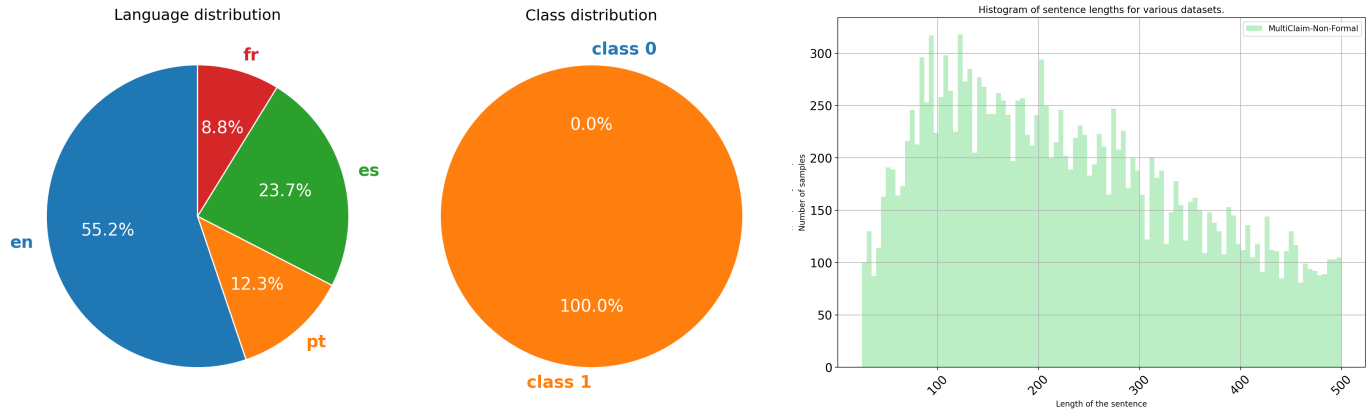

#### Download the dataset:
The dataset was published at [Zenodo](https://zenodo.org/records/7737983) and is available on demand of research and non-commercial purposes.

In [12]:
assert exists(multiclaim_path), 'Please download the dataset and setup the path to it in `multiclaim_path` variable!'

#### Load the dataset:

In [13]:
import pandas as pd
from os.path import join
import ast
from tqdm.notebook import tqdm


def load_posts() -> DataFrame:
    # Define a function to parse the JSON in each row
    def parse_row(row):
        try:
            ocr_text = ast.literal_eval(row['ocr'])[0][0]
        except:
            ocr_text = ''

        try:
            claim = ast.literal_eval(row['text'])[0]
        except:
            claim = ''

        if not claim and ocr_text:
            text = ocr_text
        elif claim and not ocr_text:
            text = claim
        elif claim and ocr_text:
            if len(ocr_text) > len(claim):
                text = ocr_text
            else:
                text = claim
        else:
            text = ''
        style = 'noisy'
        label = 1
        topic = 'TODO'

        try:
            lang = detect(text.replace('\n', ' '))['lang']
        except:
            lang = None

        return pd.Series([lang, topic, style, label, text])

    if exists(join(multiclaim_zenodo_path, 'posts_filtered.csv')):
        print('Loading posts from MultiClaim dataset: ')
        posts = pd.read_csv(join(multiclaim_zenodo_path, 'posts_filtered.csv'))
    else:
        posts = pd.read_csv(join(multiclaim_zenodo_path, 'posts.csv'))

        print('Missing language info.')
        print('Detecting:')

        # Init translator (detector)
        from langdetect import detect

        # Apply the function to each row
        posts = posts.progress_apply(parse_row, axis=1)
        posts.columns = ['lang', 'topic', 'style', 'label', 'text']

        posts.to_csv(join(multiclaim_zenodo_path, 'posts_filtered.csv'), header=True, index=False)

    return posts


mc_zenodo_posts = load_posts()
mc_zenodo_posts = filter_dataframe(mc_zenodo_posts)

table = []

# Calculate the total number of samples to compute the ratio
total_samples = mc_zenodo_posts.shape[0]

# Loop through each unique language in the DataFrame
for lang in mc_zenodo_posts['lang'].unique():
    subset = mc_zenodo_posts[mc_zenodo_posts['lang'] == lang]
    table.append({'Language': lang,
                  'Samples:': subset.shape[0],
                  'Ratio:': f"{(subset.shape[0] / total_samples) * 100:.2f}%"})

markdown = markdown_table(table).set_params(row_sep='markdown').get_markdown()
print(markdown.replace('```', ''))
print(f"\nColumns: {mc_zenodo_posts.columns.tolist()}")

Loading posts from MultiClaim dataset: 
|Language|Samples:|Ratio:|
|--------|--------|------|
|   de   |   900  | 3.22%|
|   en   |  6528  |23.33%|
|   es   |  7099  |25.37%|
|   bs   |   14   | 0.05%|
|   pt   |  3035  |10.85%|
|   sr   |   214  | 0.76%|
|   ko   |   445  | 1.59%|
|   am   |   44   | 0.16%|
|   fr   |  1962  | 7.01%|
|   ur   |   352  | 1.26%|
|   th   |   596  | 2.13%|
|   si   |   502  | 1.79%|
|   zh   |   511  | 1.83%|
|   ja   |   118  | 0.42%|
|   pl   |   429  | 1.53%|
|   ca   |   68   | 0.24%|
|   nl   |   229  | 0.82%|
|   sh   |   35   | 0.13%|
|   sk   |   270  | 0.96%|
|   ro   |   190  | 0.68%|
|   id   |  1112  | 3.97%|
|   tl   |   223  | 0.80%|
|   hi   |   759  | 2.71%|
|   fi   |   95   | 0.34%|
|   ms   |   117  | 0.42%|
|   cs   |   247  | 0.88%|
|   bg   |   98   | 0.35%|
|   hu   |   110  | 0.39%|
|   it   |   37   | 0.13%|
|   el   |   166  | 0.59%|
|   ar   |   860  | 3.07%|
|   or   |    1   | 0.00%|
|   hr   |   131  | 0.47%|
|   ta   |   28

#### Statistics:

| Languages: | en | es | pt | fr | id |
|------------|-------|-------|-------|-------|-------|
| Samples:   | 6528 | 7099 | 3035 | 1962 | 1112 |
| Ratio:     | 23.33% | 25.37% | 10.85% | 7.01% | 3.97% |

Language distribution


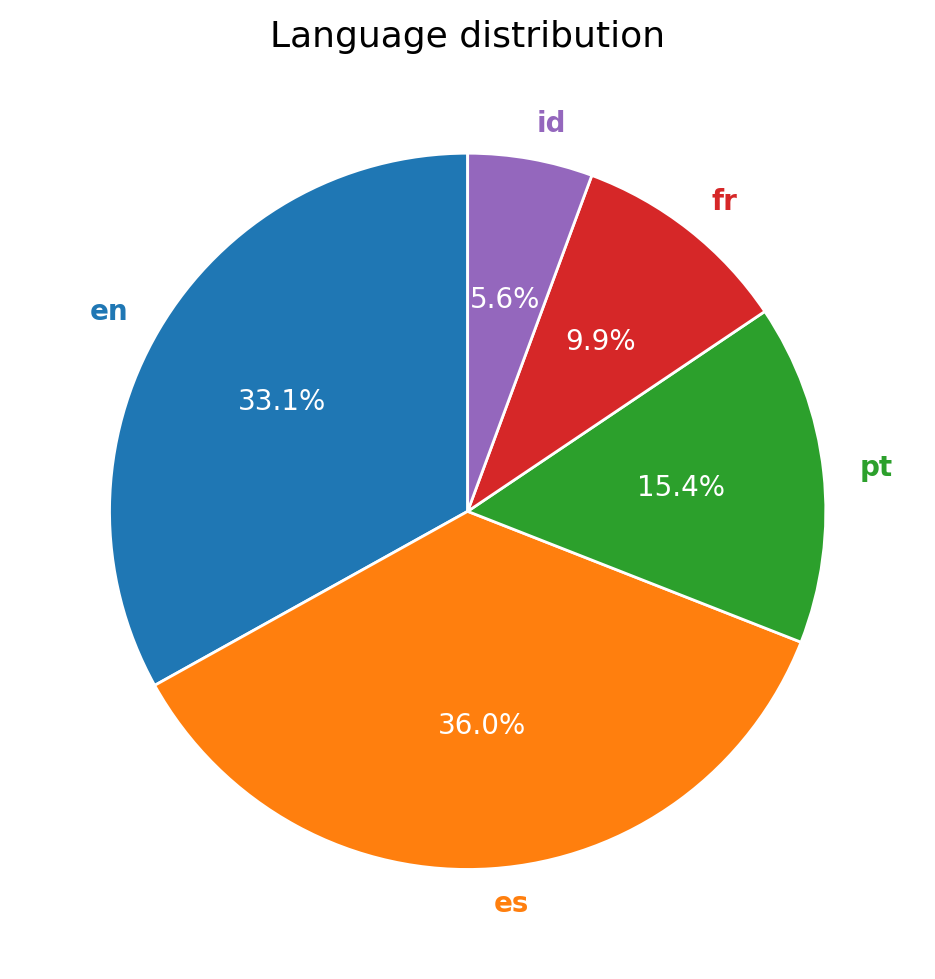

|Class 0:|Class 1:|
|--------|--------|
|  0.0%  | 100.0% |
Class distribution


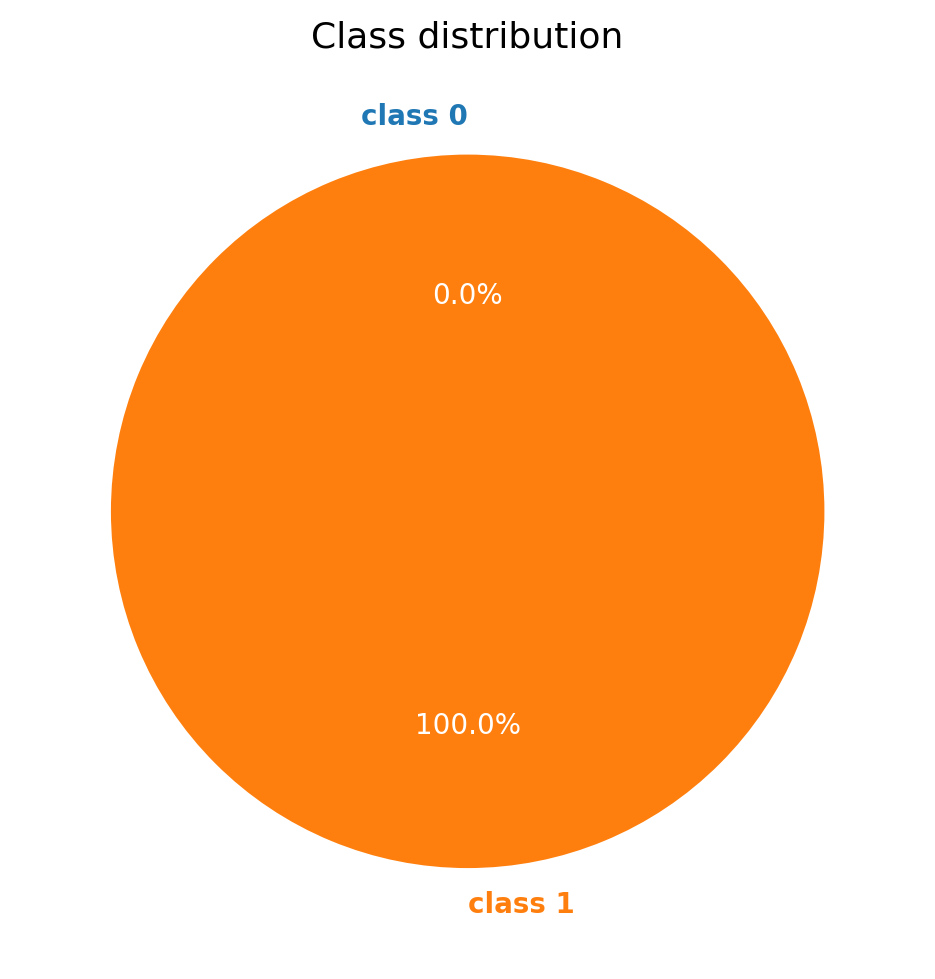

|       Dataset       |Avg. length:|
|---------------------|------------|
|MultiClaim-Non-Formal|   198.24   |


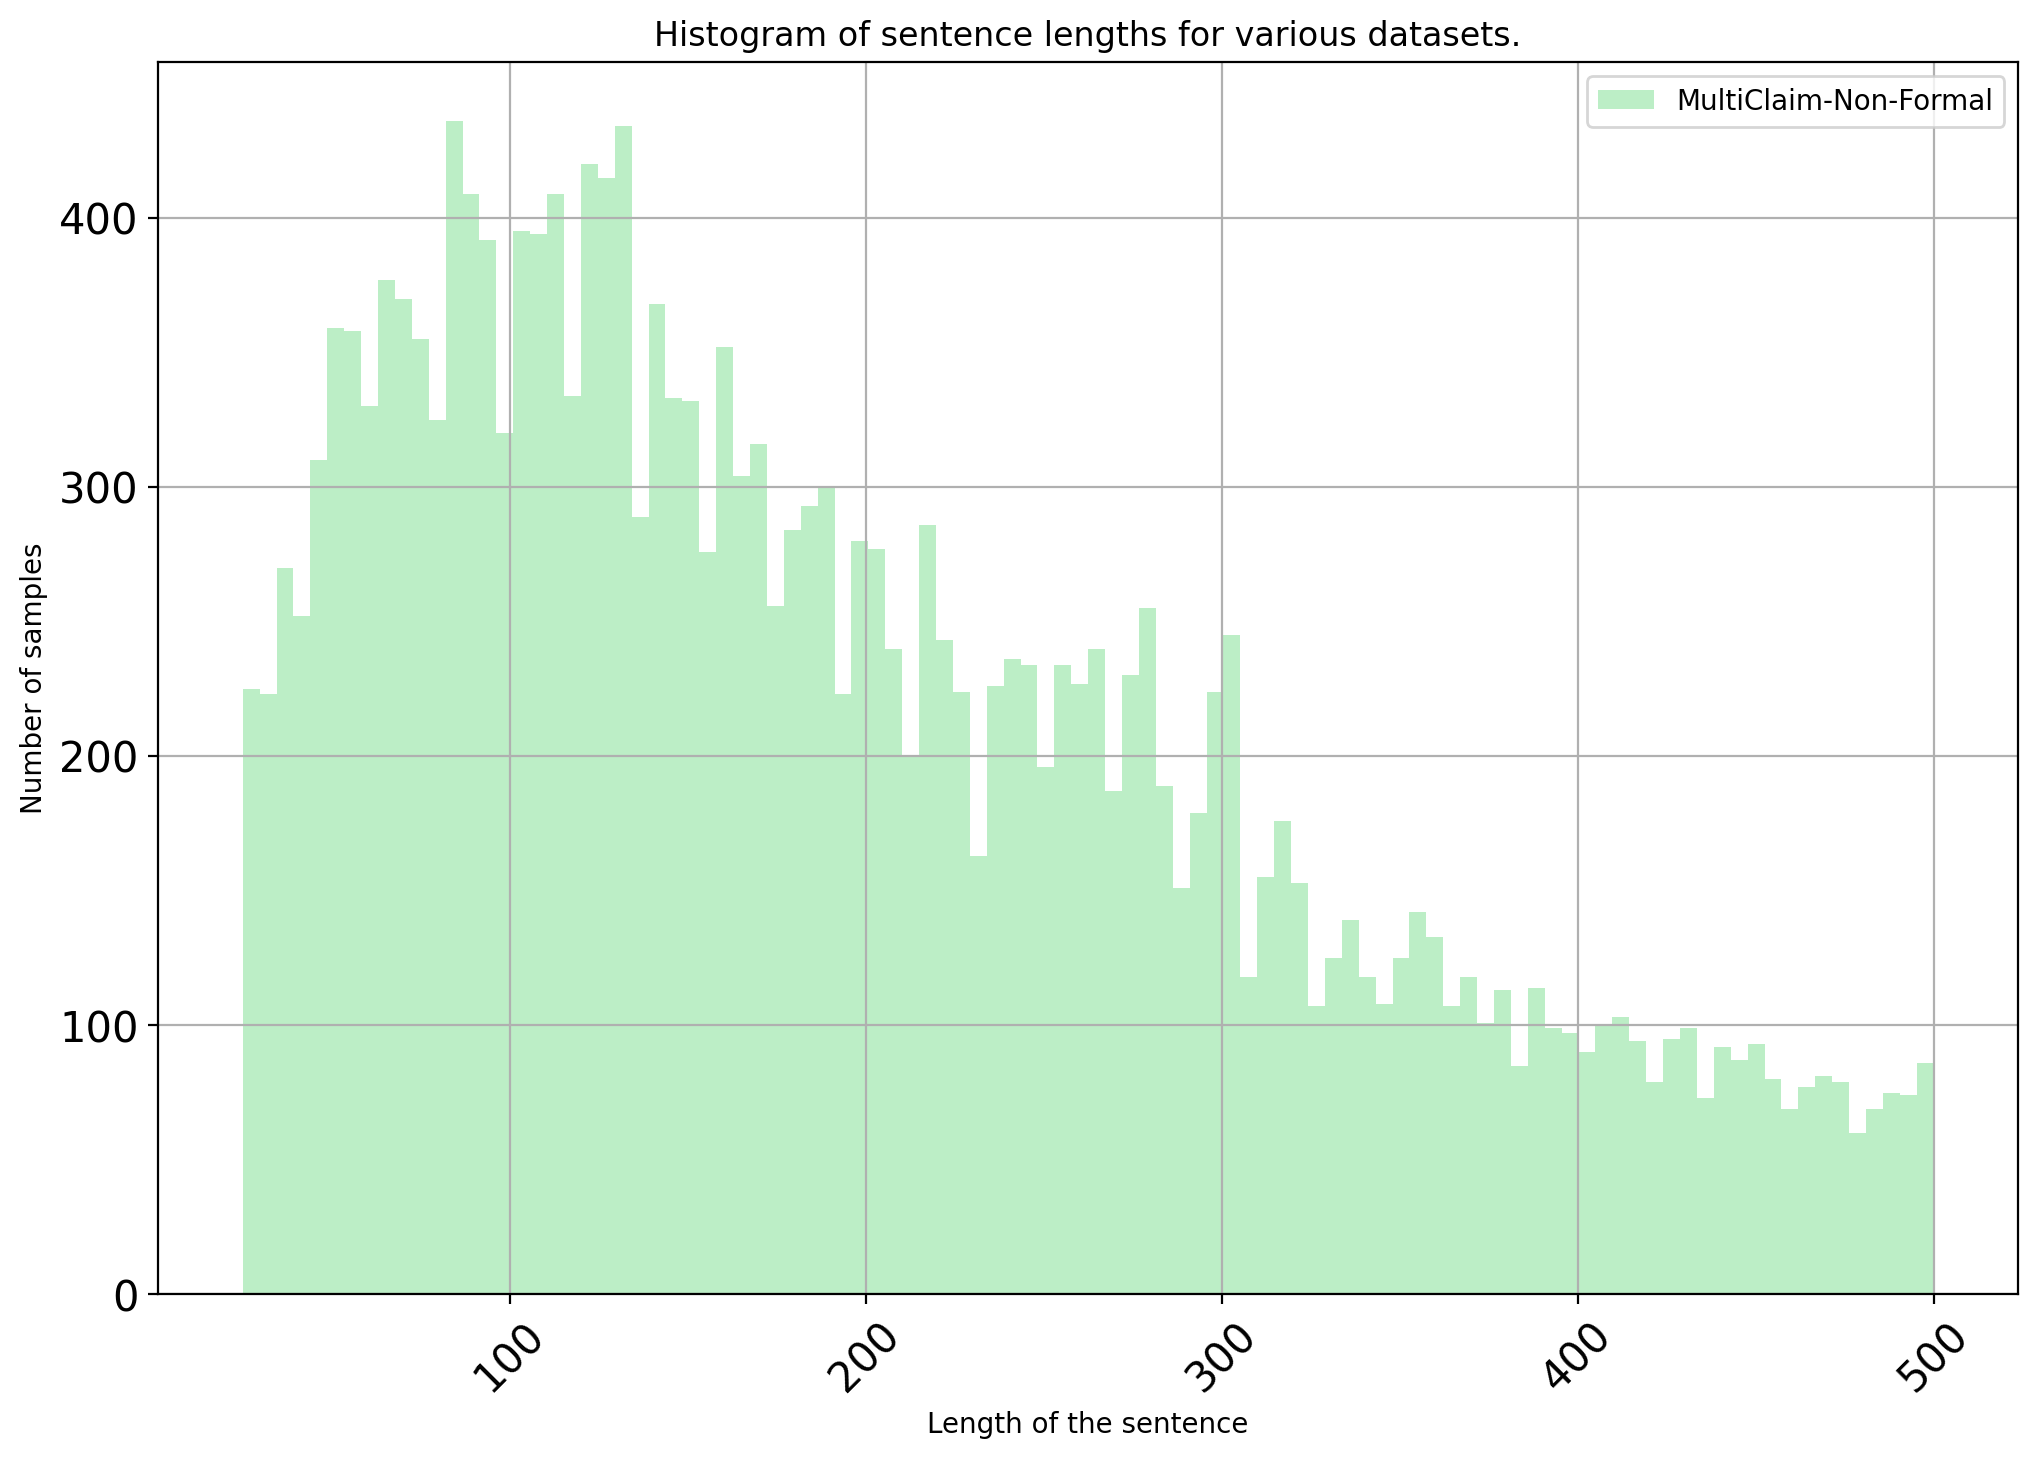

In [14]:
data = lang_distribution(mc_zenodo_posts)
pie_chart(title='Language distribution', data=data)

data = class_distribution(mc_zenodo_posts)
pie_chart(title='Class distribution', data=data)

histogram({'MultiClaim-Non-Formal': mc_zenodo_posts})

### MultiClaim-Extended (Fact-checks)
Contains additionaly scaped fact-checks from the AFP and Demagog in Slovak, Czech and Polish up to August 23th 2023.

Composition of the dataset:

| Languages: | en | es | cs | ar | sk | hi | pl | ru | fr | tr | de |
|------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Samples:   | 144219 | 25663 | 14551 | 21069 | 20456 | 10987 | 8808 | 3310 | 6546 | 13008 | 8104 |
| Ratio:     | 52.03% | 9.26% | 5.25% | 7.6% | 7.38% | 3.96% | 3.18% | 1.19% | 2.36% | 4.69% | 2.92% |

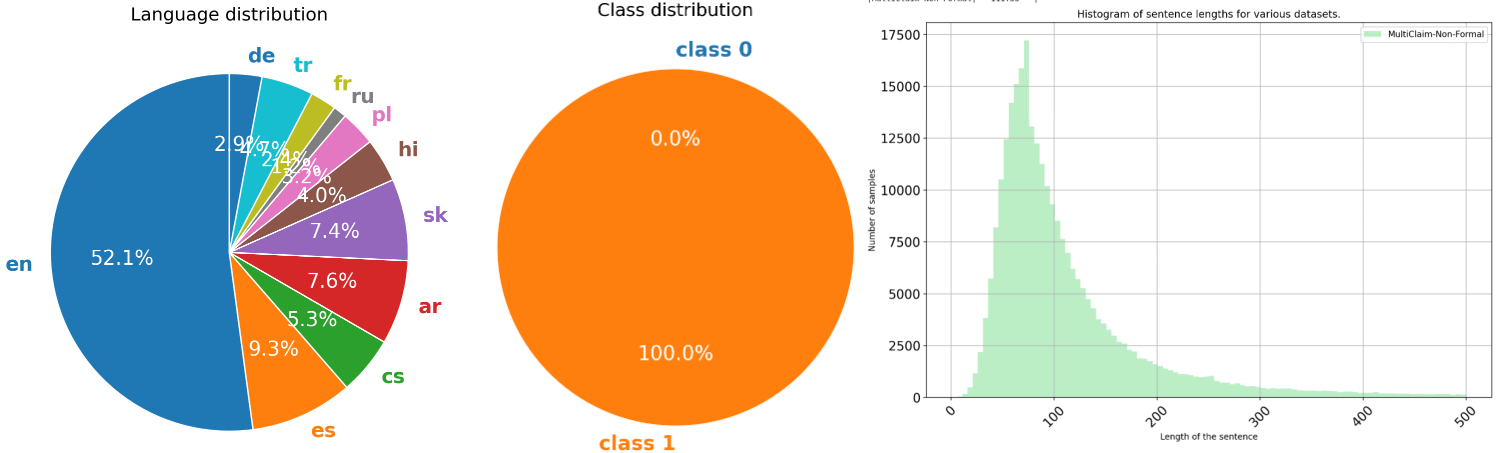

#### Load the dataset:

In [15]:
import time
from yaspin import yaspin

# Function decorator:
@yaspin(text="Loading MultiClaim-Extended dataset:")
def load_mc():
    mc_ext_fc = pd.read_csv(join(multiclaim_path, 'extended', 'fc_articles_may2024.csv'))
    print(mc_ext_fc.shape[0])
    mc_ext_fc['label'] = 1.0
    mc_ext_fc['style'] = 'structured'
    mc_ext_fc['topic'] = 'TODO'

    return mc_ext_fc

mc_ext_fc = load_mc()
mc_ext_articles = mc_ext_fc[['lang', 'article']]
mc_ext_fc = mc_ext_fc[['lang', 'topic', 'style', 'label', 'text']]
mc_ext_fc = filter_dataframe(mc_ext_fc)


# Calculate the total number of samples to compute the ratio
table = []
total_samples = mc_ext_fc.shape[0]
print(total_samples)

# Loop through each unique language in the DataFrame
for lang in mc_ext_fc['lang'].unique():
  subset = mc_ext_fc[mc_ext_fc['lang'] == lang]
  table.append({'Language': lang,
                'Samples:': subset.shape[0],
                'Ratio:': f"{(subset.shape[0] / total_samples) * 100:.2f}%"})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))
print(f"\nColumns: {mc_ext_fc.columns.tolist()}")

⠸ Loading MultiClaim-Extended dataset:277188
277188                                 
|Language|Samples:|Ratio:|
|--------|--------|------|
|   en   | 144219 |52.03%|
|   es   |  25663 | 9.26%|
|   cs   |  14551 | 5.25%|
|   ar   |  21069 | 7.60%|
|   sk   |  20456 | 7.38%|
|   hi   |  10987 | 3.96%|
|   pl   |  8808  | 3.18%|
|   ru   |  3310  | 1.19%|
|   fr   |  6546  | 2.36%|
|   tr   |  13008 | 4.69%|
|   de   |  8104  | 2.92%|
|   bg   |   369  | 0.13%|
|   uk   |   98   | 0.04%|

Columns: ['lang', 'topic', 'style', 'label', 'text']


#### Statistics:

| Languages: | en | es | cs | ar | sk | hi | pl | ru | fr | tr | de |
|------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Samples:   | 144219 | 25663 | 14551 | 21069 | 20456 | 10987 | 8808 | 3310 | 6546 | 13008 | 8104 |
| Ratio:     | 52.03% | 9.26% | 5.25% | 7.6% | 7.38% | 3.96% | 3.18% | 1.19% | 2.36% | 4.69% | 2.92% |

Language distribution


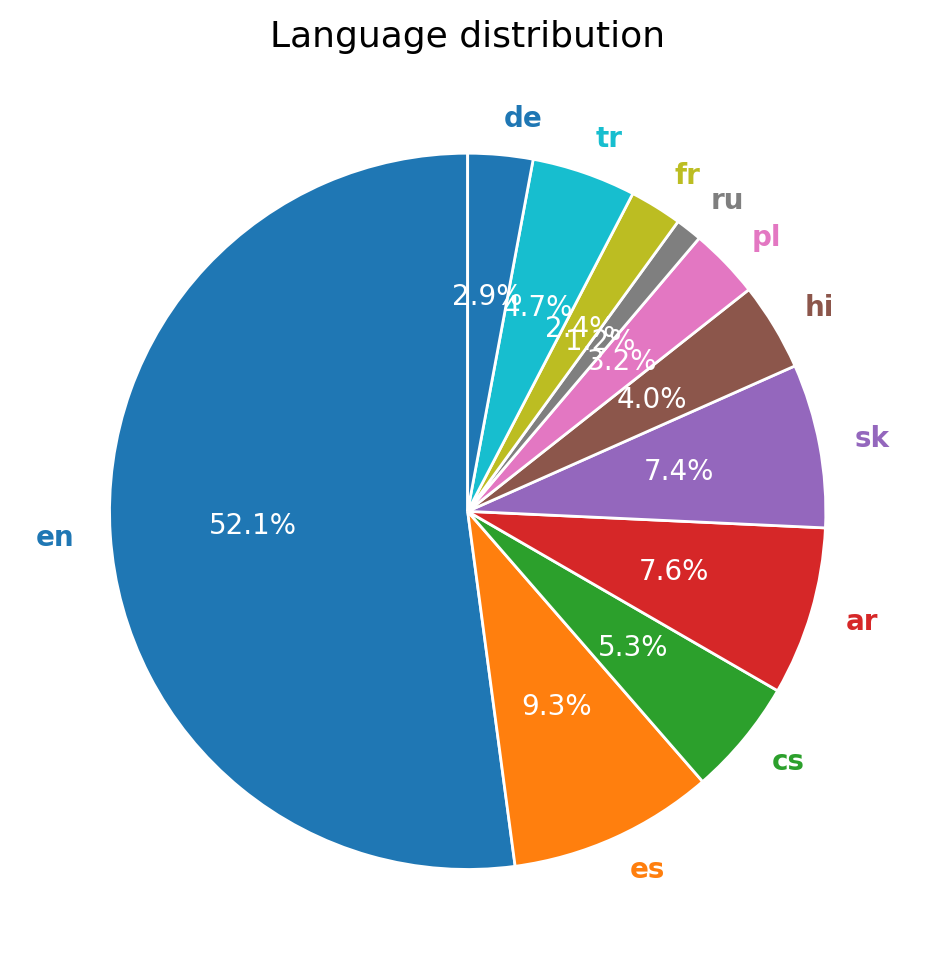

|Class 0:|Class 1:|
|--------|--------|
|  0.0%  | 100.0% |
Class distribution


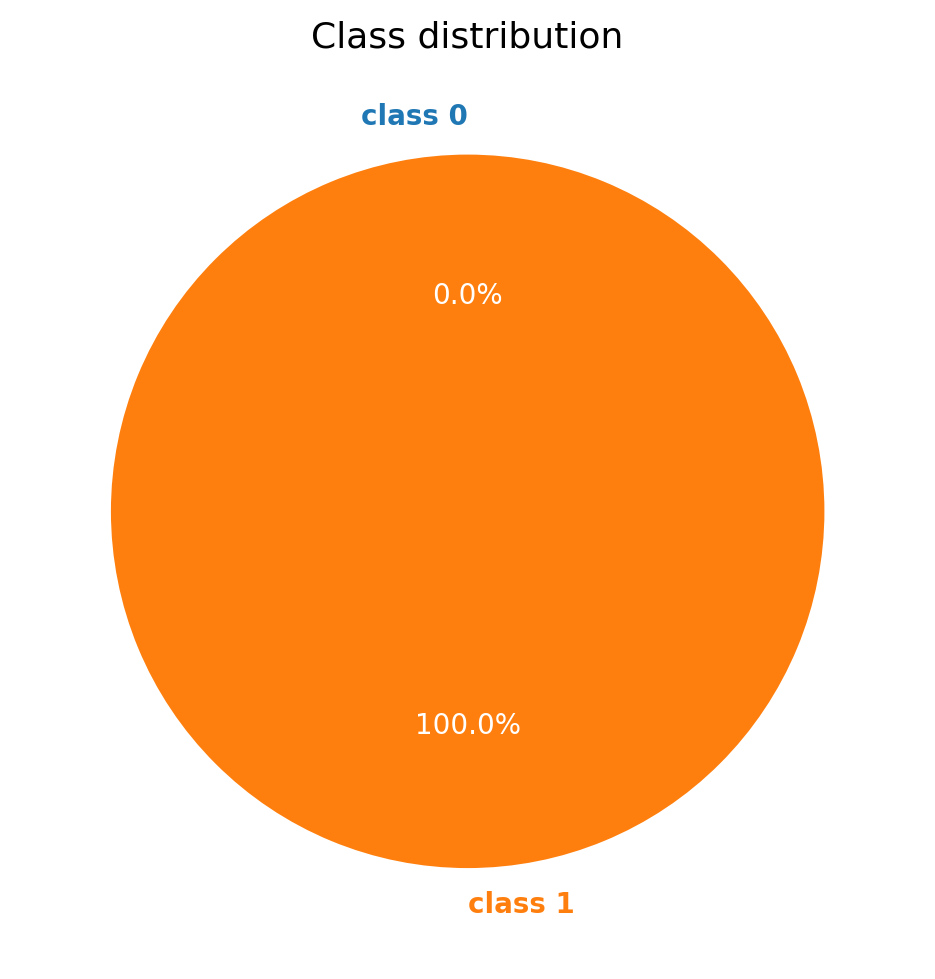

|       Dataset       |Avg. length:|
|---------------------|------------|
|MultiClaim-Non-Formal|   111.33   |


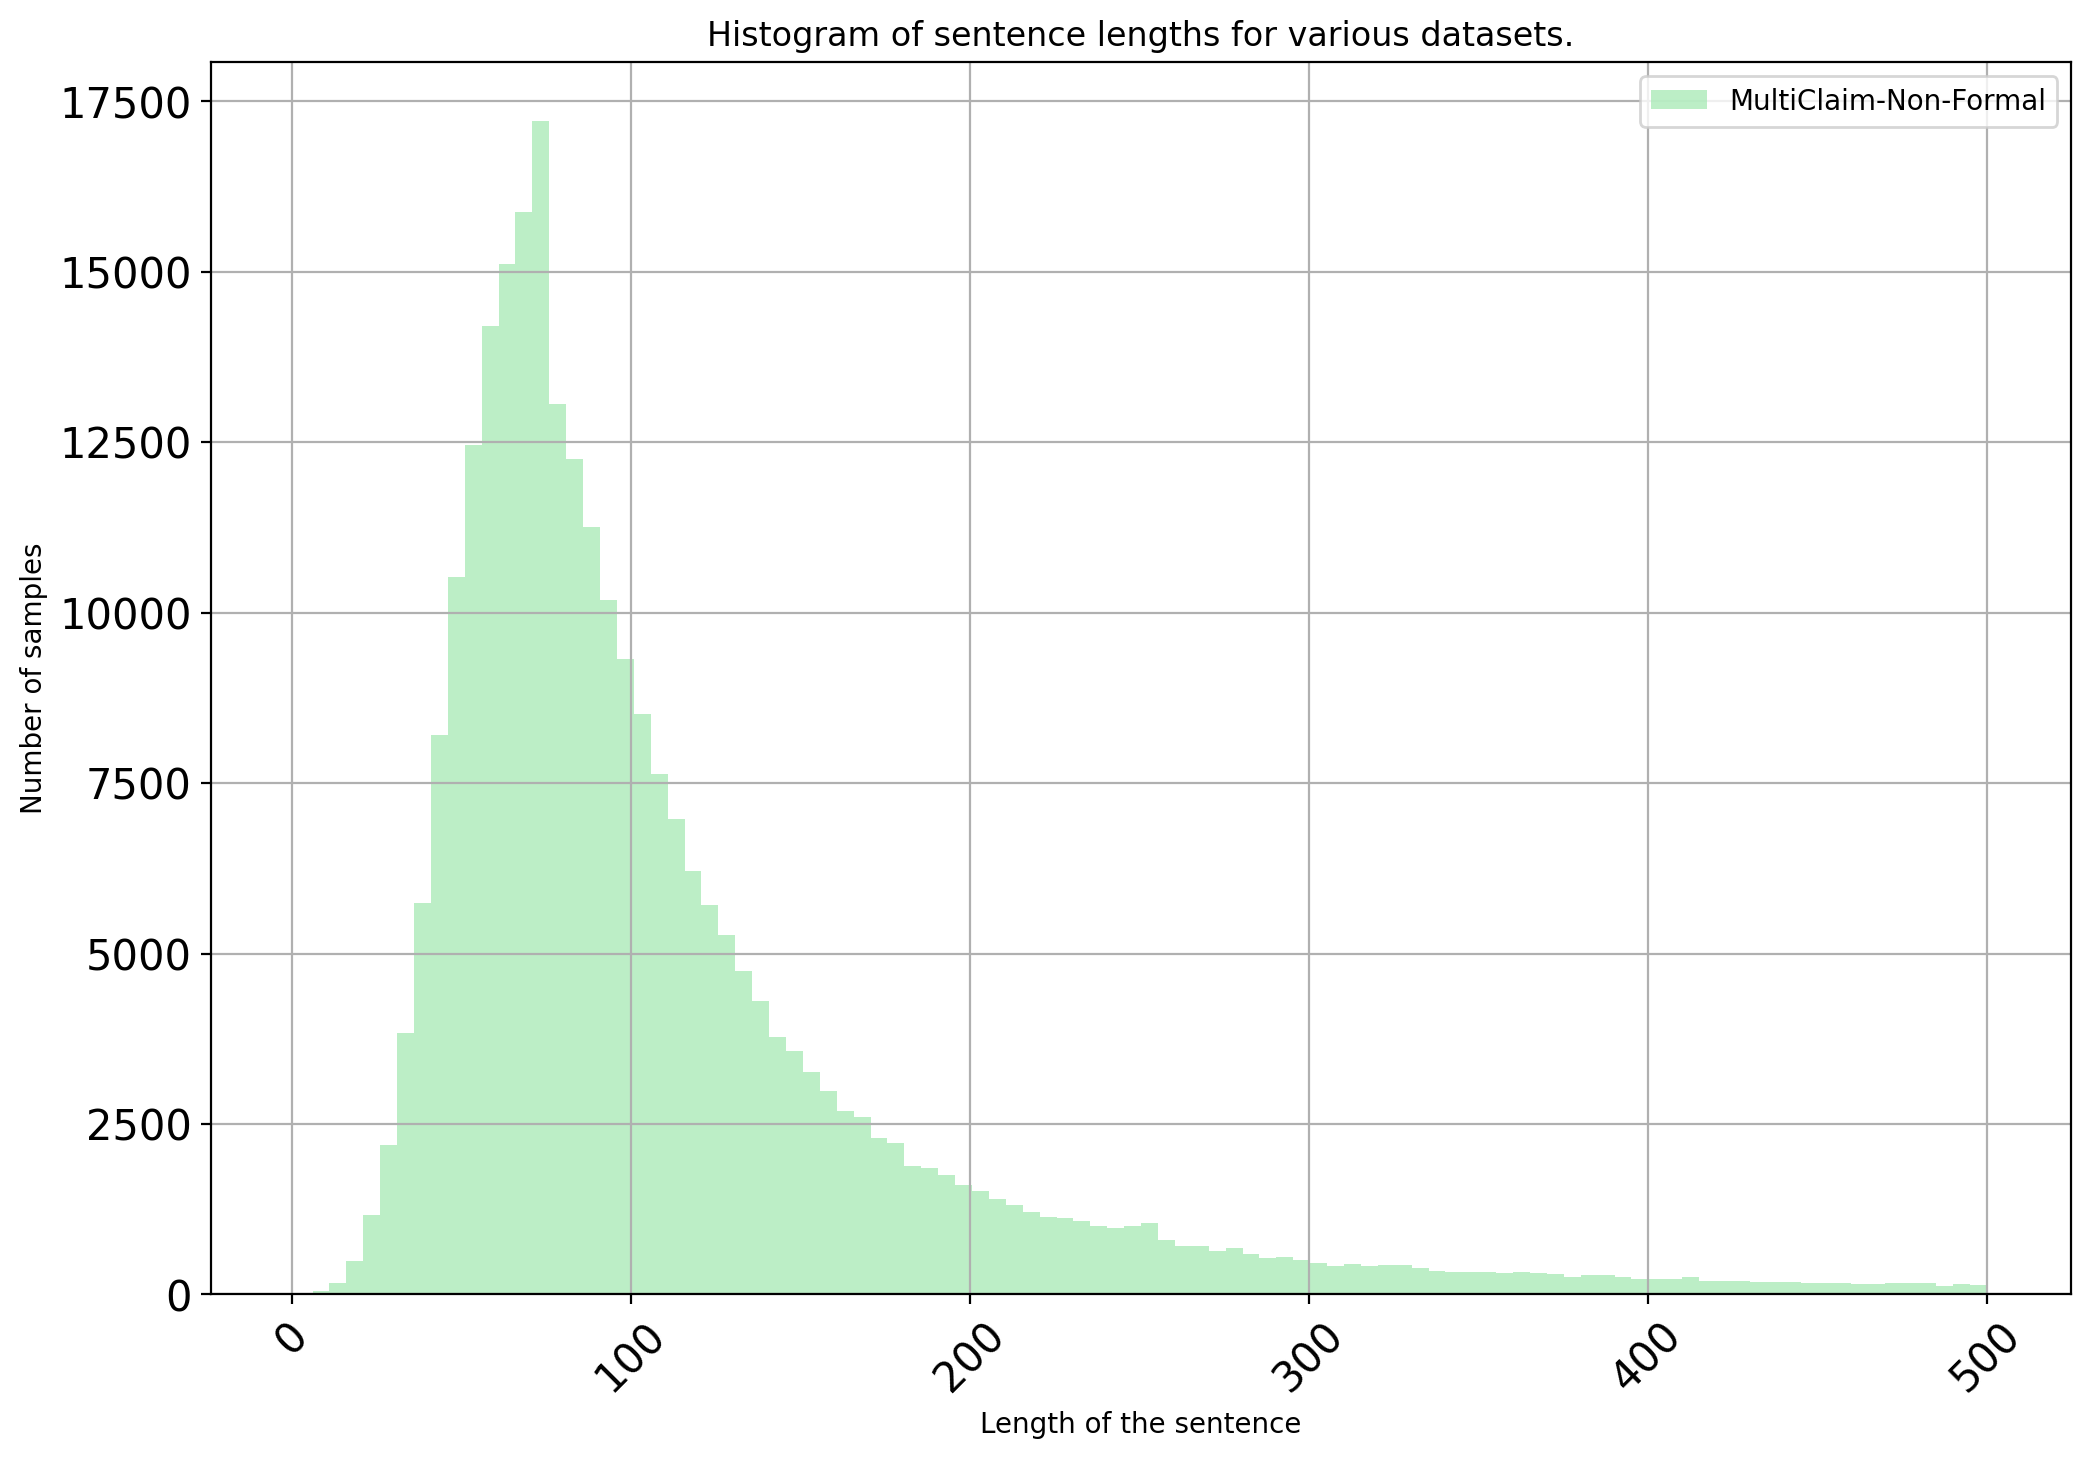

In [16]:
data = lang_distribution(mc_ext_fc)
pie_chart(title='Language distribution', data=data)

data = class_distribution(mc_ext_fc)
pie_chart(title='Class distribution', data=data)

histogram({'MultiClaim-Non-Formal': mc_ext_fc})

### MultiClaim-Extended (Soc. Media Posts)
Contains additionaly scaped social media comments and fact-check articles up to August 23th 2023.
Contains 121,288 fact-check pairs:
  * facebook posts - 104351
  * twitter posts - 12266
  * instagram posts - 4671

Composition of the dataset:

|       |   en  |   fr  |   es  |   de  |   pl  |   nl  |   it  |   ru  |   pt  |   ml  |   tr  |   mk  |   hi  |   bn  |   id  |   ar  |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
|Samples| 52457 |  5086 | 12846 |  4911 |  3184 |  1464 |  1599 |  1598 |  5925 |  1096 |  4120 |  1786 |  7907 |  2120 |  1843 |  5159 |
|Ratio  |43.25% | 4.19% |10.59% | 4.05% | 2.63% | 1.21% | 1.32% | 1.32% | 4.89% | 0.90% | 3.40% | 1.47% | 6.52% | 1.75% | 1.52% | 4.25% |

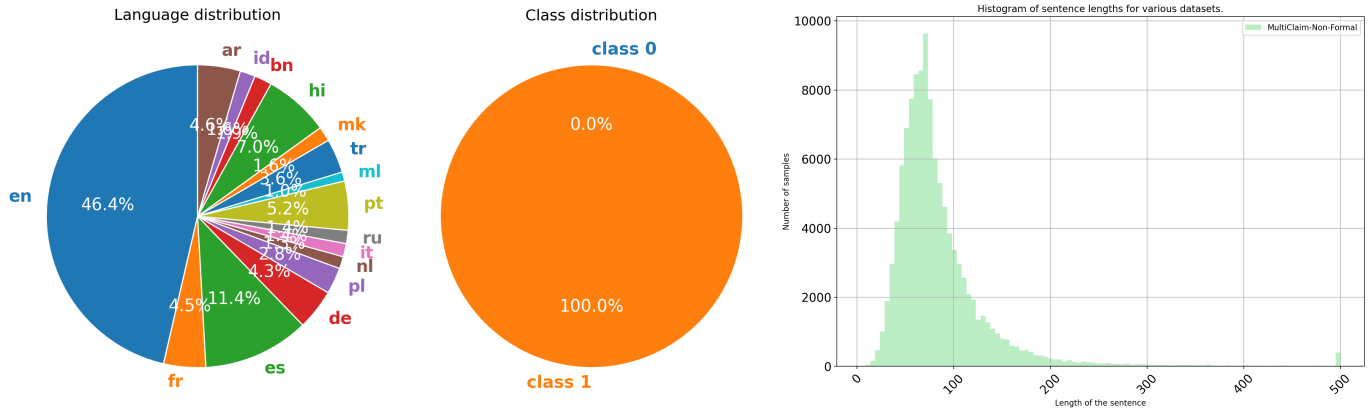



#### Load the dataset:

In [17]:
import pandas as pd
from os.path import join, exists
import ast

from py_markdown_table.markdown_table import markdown_table
from tqdm.notebook import tqdm

# Initialize tqdm with pandas
tqdm.pandas()


def load_posts() -> pd.DataFrame:
    mc_extended_path = join(multiclaim_extended, 'posts_may2024.csv')
    print('Loading posts from MultiClaim dataset: ')
    posts = pd.read_csv(mc_extended_path)
    posts['topic'] = 'TODO'
    posts = posts[['lang', 'topic', 'style', 'label', 'text']]
    
    
    return posts


mc_ext_posts = load_posts()
mc_ext_posts = filter_dataframe(mc_ext_posts)

# Calculate the total number of samples to compute the ratio
table = []
total_samples = mc_ext_posts.shape[0]

# Loop through each unique language in the DataFrame
for lang in mc_ext_posts['lang'].unique():
    subset = mc_ext_posts[mc_ext_posts['lang'] == lang]
    table.append({'Language': lang,
                  'Samples:': subset.shape[0],
                  'Ratio:': f"{(subset.shape[0] / total_samples) * 100:.2f}%"})

markdown = markdown_table(table).set_params(row_sep='markdown').get_markdown()
print(markdown.replace('```', ''))
print(f"\nColumns: {mc_ext_posts.columns.tolist()}")

Loading posts from MultiClaim dataset: 
|Language|Samples:|Ratio:|
|--------|--------|------|
|   en   |  52457 |43.26%|
|   hr   |   335  | 0.28%|
|   fr   |  5086  | 4.19%|
|   es   |  12846 |10.59%|
|   sh   |   274  | 0.23%|
|   el   |   583  | 0.48%|
|   de   |  4911  | 4.05%|
|   pl   |  3184  | 2.63%|
|   fi   |   252  | 0.21%|
|   nl   |  1464  | 1.21%|
|   it   |  1599  | 1.32%|
|   sk   |   516  | 0.43%|
|   cs   |   593  | 0.49%|
|   ru   |  1598  | 1.32%|
|   ca   |   181  | 0.15%|
|   pt   |  5925  | 4.89%|
|   sr   |   485  | 0.40%|
|   ml   |  1096  | 0.90%|
|   fa   |    7   | 0.01%|
|   bg   |   310  | 0.26%|
|   hu   |   262  | 0.22%|
|   tr   |  4120  | 3.40%|
|   mk   |  1786  | 1.47%|
|   hi   |  7907  | 6.52%|
|   bn   |  2120  | 1.75%|
|   az   |   210  | 0.17%|
|   ro   |   544  | 0.45%|
|   pa   |   10   | 0.01%|
|   id   |  1843  | 1.52%|
|   ms   |   426  | 0.35%|
|   sv   |    8   | 0.01%|
|   ko   |   919  | 0.76%|
|   my   |   310  | 0.26%|
|   th   |   92

#### Statistics:

| Languages: | en | fr | es | de | pl | nl | it | ru | pt | ml | tr | mk | hi | bn | id | ar |
|------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Samples:   | 52457 | 5086 | 12846 | 4911 | 3184 | 1464 | 1599 | 1598 | 5925 | 1096 | 4120 | 1786 | 7907 | 2120 | 1843 | 5159 |
| Ratio:     | 43.26% | 4.19% | 10.59% | 4.05% | 2.63% | 1.21% | 1.32% | 1.32% | 4.89% | 0.9% | 3.4% | 1.47% | 6.52% | 1.75% | 1.52% | 4.25% |

Language distribution


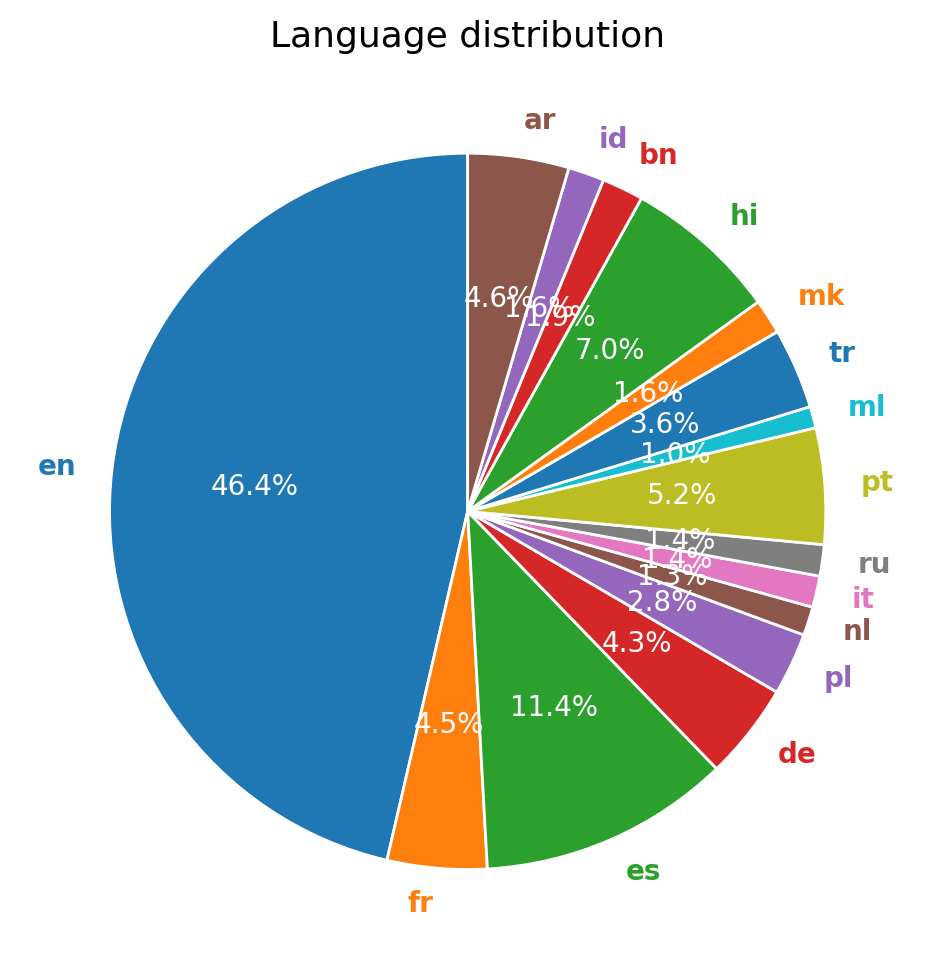

|Class 0:|Class 1:|
|--------|--------|
|  0.0%  | 100.0% |
Class distribution


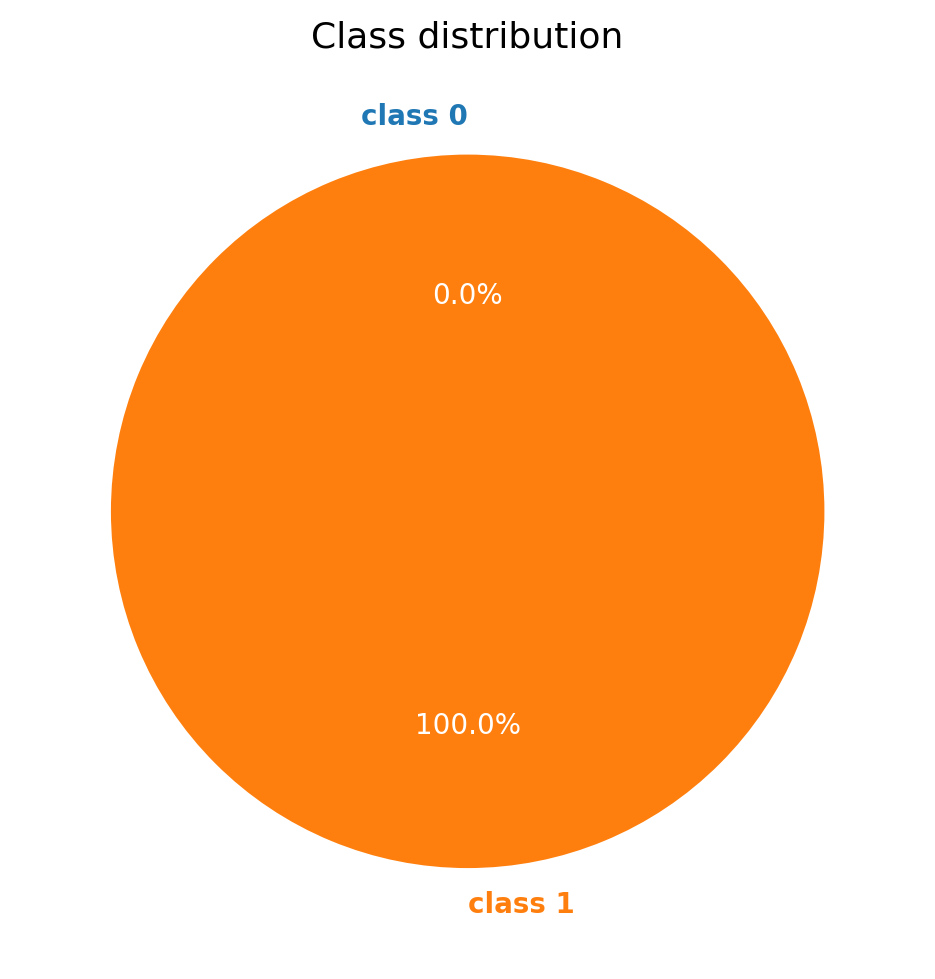

|       Dataset       |Avg. length:|
|---------------------|------------|
|MultiClaim-Non-Formal|    83.38   |


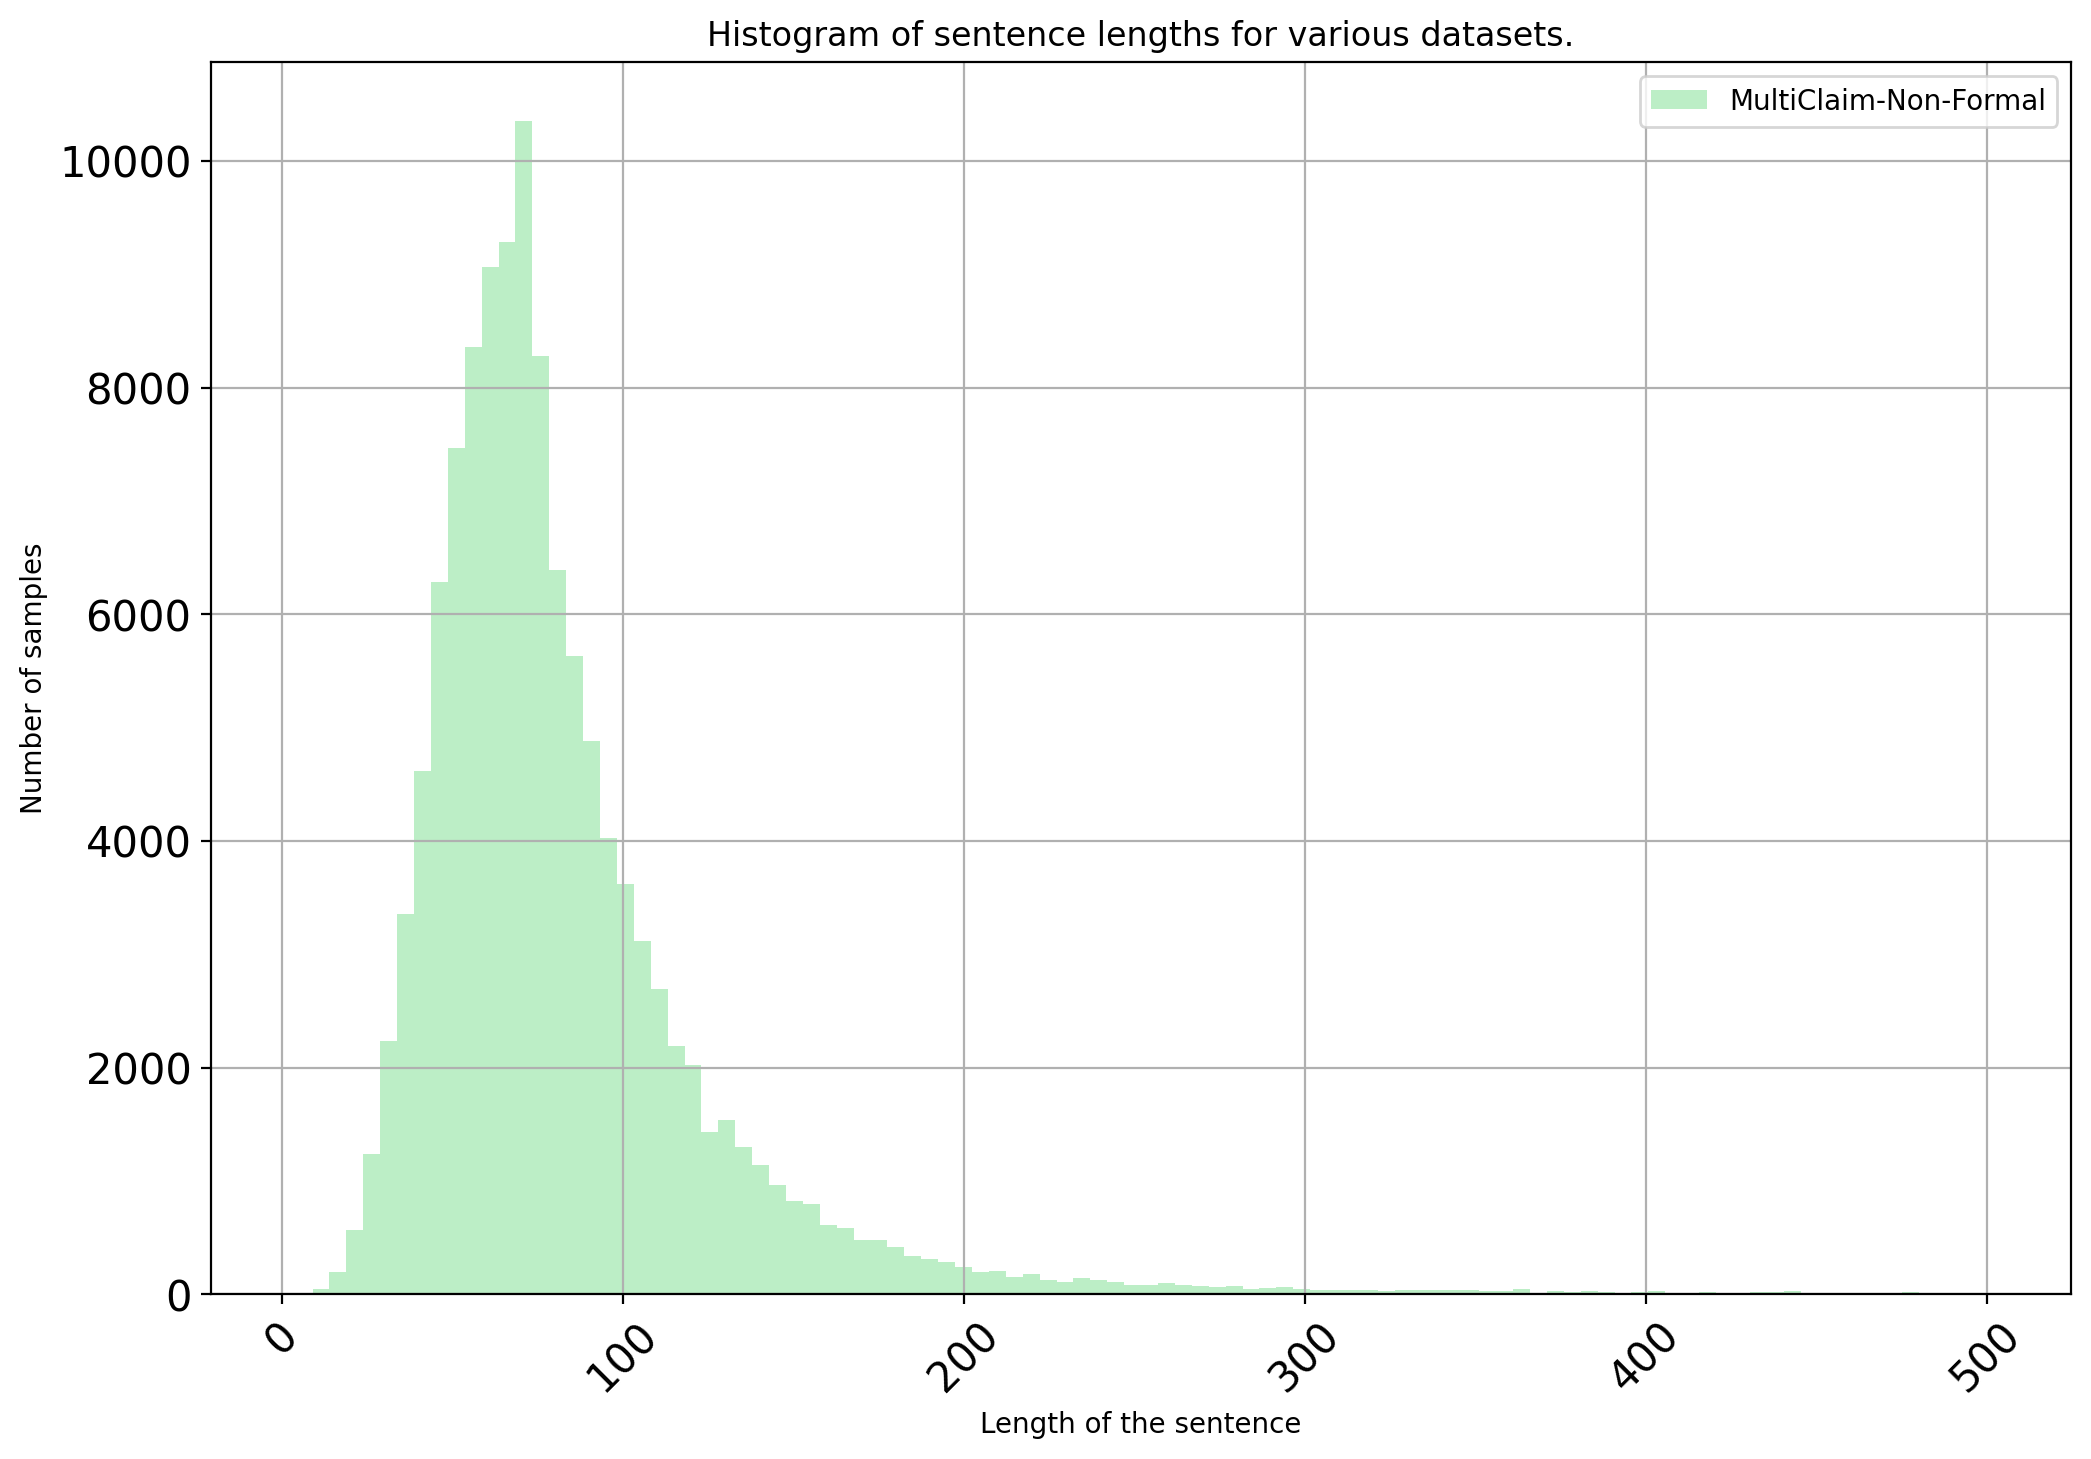

In [18]:
data = lang_distribution(mc_ext_posts)
pie_chart(title='Language distribution', data=data)

data = class_distribution(mc_ext_posts)
pie_chart(title='Class distribution', data=data)

histogram({'MultiClaim-Non-Formal': mc_ext_posts})

### RU22Fact dataset [Paper](https://arxiv.org/pdf/2403.16662v2)  [Data](https://github.com/zeng-yirong/ru22fact)

A novel multilingual explainable fact-checking dataset on the Russia-Ukraine conflict in 2022 of 16K samples, each containing real-world claims, optimized evidence, and referenced explanation.

| Languages: | English | Ukrainian | Chinese | Russian |
|------------|-------|-------|-------|-------|
| Samples:   | 8690 | 3512 | 1512 | 2317 |
| Ratio:     | 54.2% | 21.9% | 9.43% | 14.45% |

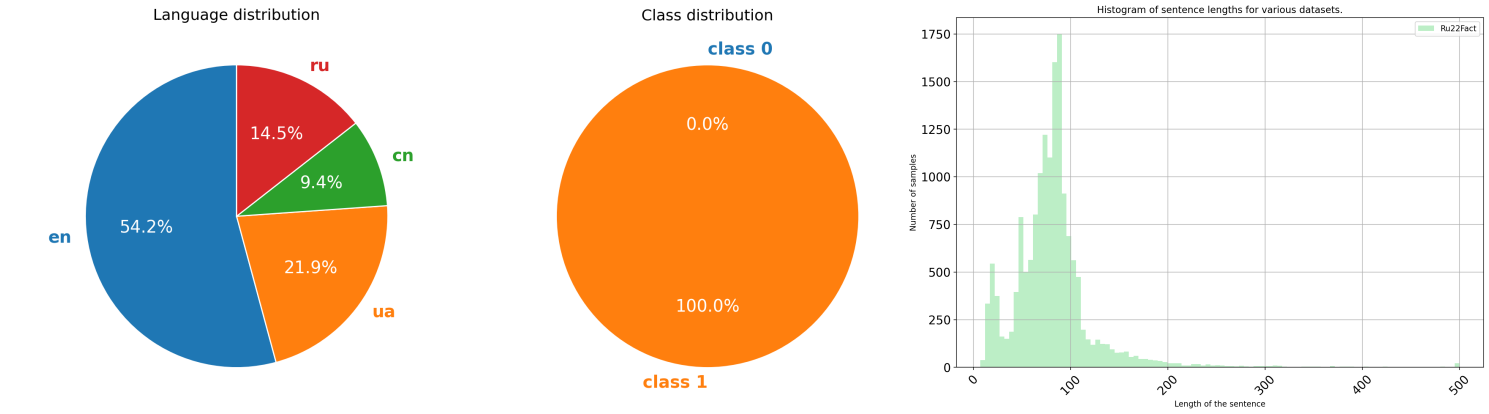

#### Download the dataset:

In [19]:
import os
import shutil

from os.path import join

import pdb;

# Define paths
repo_url = 'https://github.com/zeng-yirong/ru22fact.git'
clone_dir = join(datasets_path, 'ru22fact-temp')

# Define source and destination directories
ru22fact_src_dir = os.path.join(clone_dir, 'data', 'ru22fact')
ru22fact_dst_dir = join(datasets_path, 'Ru22Fact')

# Only download the dataset if necessarry
if not os.path.exists(ru22fact_dst_dir):
    %pip install gitpython patool
    import patoolib

    # Clone the repository if it doesn't exist
    if not os.path.exists(clone_dir):
        !pip install gitpython

        import git

        print('Downloading Ru22Fact: ', end='')
        git.Repo.clone_from(repo_url, clone_dir)
        print('ok')

    print('Retrieving data: ', end='')

    # Ensure the destination directories exist
    os.makedirs(ru22fact_dst_dir, exist_ok=True)

    # Co# Copy and decompress files from task1 that contain "1B"
    for root, _, files in os.walk(ru22fact_src_dir):
        for file in files:
            file_path = os.path.join(root, file)
            dest_path = os.path.join(ru22fact_dst_dir, file)
            shutil.copy(file_path, dest_path)

    print('ok')

    shutil.rmtree(clone_dir)

    # List the extracted files
    print("Ru22Facts:\n", "\n".join(os.listdir(ru22fact_dst_dir)))
else:
    print('Ru22Facts dataset ready.')

Ru22Facts dataset ready.


#### Load the dataset:

In [20]:
ru22fact_dst_dir = join(datasets_path, 'Ru22Fact')

print('Loading Ru22Fact dataset:\n')
train = pd.read_csv(join(ru22fact_dst_dir, 'ru22fact_train.csv'))
dev = pd.read_csv(join(ru22fact_dst_dir, 'ru22fact_validate.csv'))
test = pd.read_csv(join(ru22fact_dst_dir, 'ru22fact_test.csv'))

train['style'] = 'structured'
dev['style'] = 'structured'
test['style'] = 'structured'

train['topic'] = 'politics'
dev['topic'] = 'politics'
test['topic'] = 'politics'

train['label'] = 1
dev['label'] = 1
test['label'] = 1

train = train[['language', 'topic', 'style', 'label', 'claim']]
dev = dev[['language', 'topic', 'style', 'label', 'claim']]
test = test[['language', 'topic', 'style', 'label', 'claim']]

train.columns = ['lang', 'topic', 'style', 'label', 'text']
dev.columns = ['lang', 'topic', 'style', 'label', 'text']
test.columns = ['lang', 'topic', 'style', 'label', 'text']

ru22fact = pd.concat([train, dev, test])

# Dictionary to map language names to language codes
lang_to_code = {
    'English': 'en',
    'Russian': 'ru',
    'Chinese': 'zh',
    'Ukrainian': 'uk'
}

# Apply the mapping
ru22fact['lang'] = ru22fact['lang'].map(lang_to_code)
ru22fact = filter_dataframe(ru22fact)

# Calculate the total number of samples to compute the ratio
table = []
total_samples = mc_ext_fc.shape[0]

# Loop through each unique language in the DataFrame
for lang in mc_ext_fc['lang'].unique():
  subset = mc_ext_fc[mc_ext_fc['lang'] == lang]
  table.append({'Language': lang,
                'Samples:': subset.shape[0],
                'Ratio:': f"{(subset.shape[0] / total_samples) * 100:.2f}%"})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))
print(f"\nColumns: {ru22fact.columns.tolist()}")

Loading Ru22Fact dataset:

|Language|Samples:|Ratio:|
|--------|--------|------|
|   en   | 144219 |52.03%|
|   es   |  25663 | 9.26%|
|   cs   |  14551 | 5.25%|
|   ar   |  21069 | 7.60%|
|   sk   |  20456 | 7.38%|
|   hi   |  10987 | 3.96%|
|   pl   |  8808  | 3.18%|
|   ru   |  3310  | 1.19%|
|   fr   |  6546  | 2.36%|
|   tr   |  13008 | 4.69%|
|   de   |  8104  | 2.92%|
|   bg   |   369  | 0.13%|
|   uk   |   98   | 0.04%|

Columns: ['lang', 'topic', 'style', 'label', 'text']


#### Statistics:

| Languages: | en | uk | zh | ru |
|------------|-------|-------|-------|-------|
| Samples:   | 8690 | 3512 | 1512 | 2317 |
| Ratio:     | 54.2% | 21.9% | 9.43% | 14.45% |

Language distribution


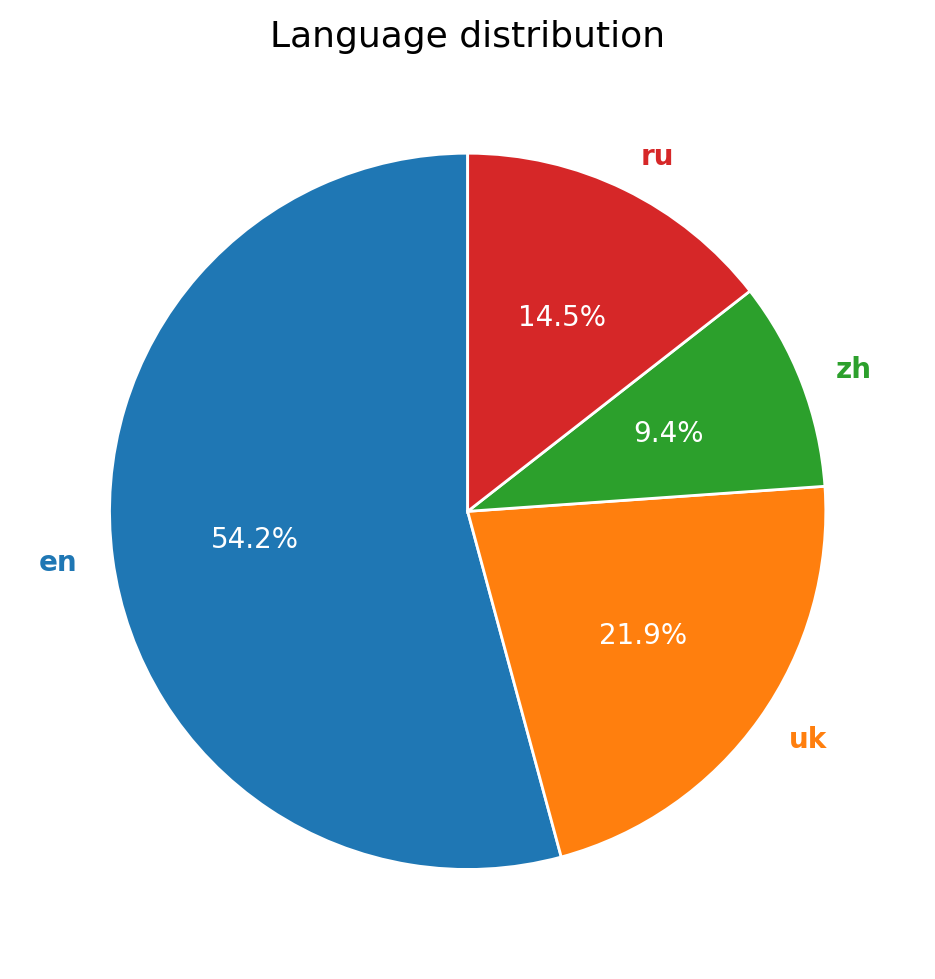

|Class 0:|Class 1:|
|--------|--------|
|  0.0%  | 100.0% |
Class distribution


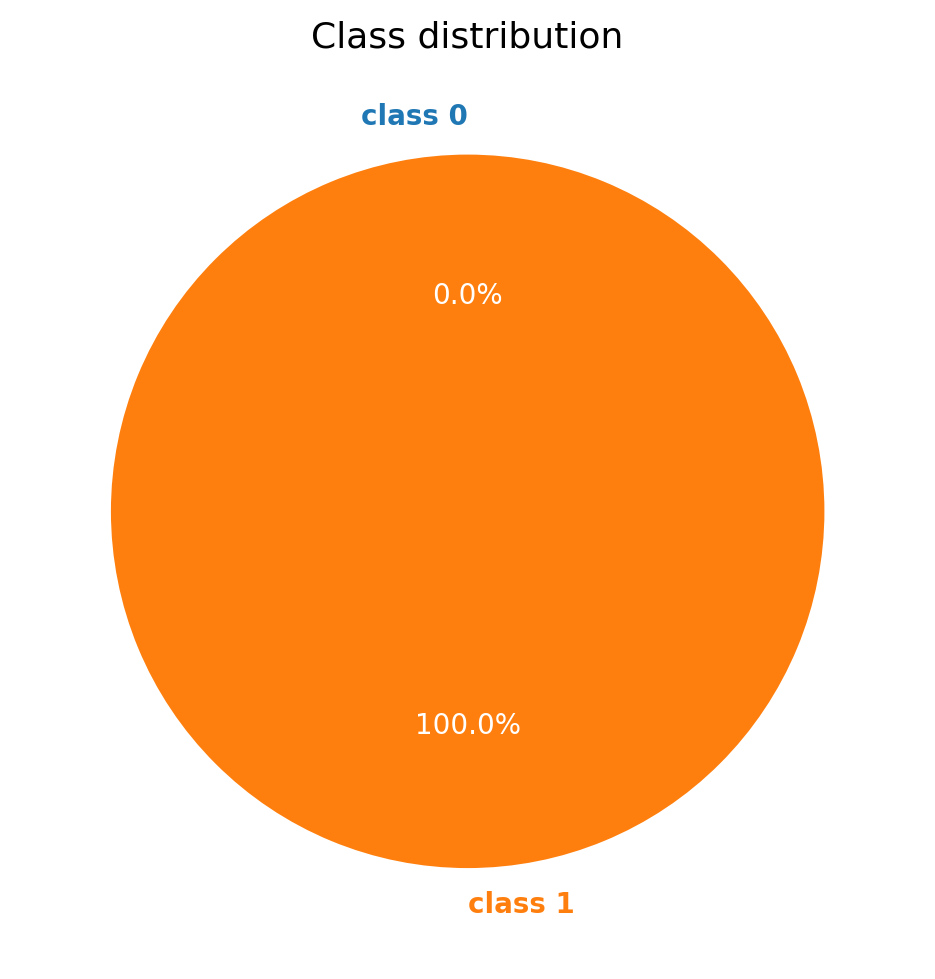

| Dataset|Avg. length:|
|--------|------------|
|Ru22Fact|    81.79   |


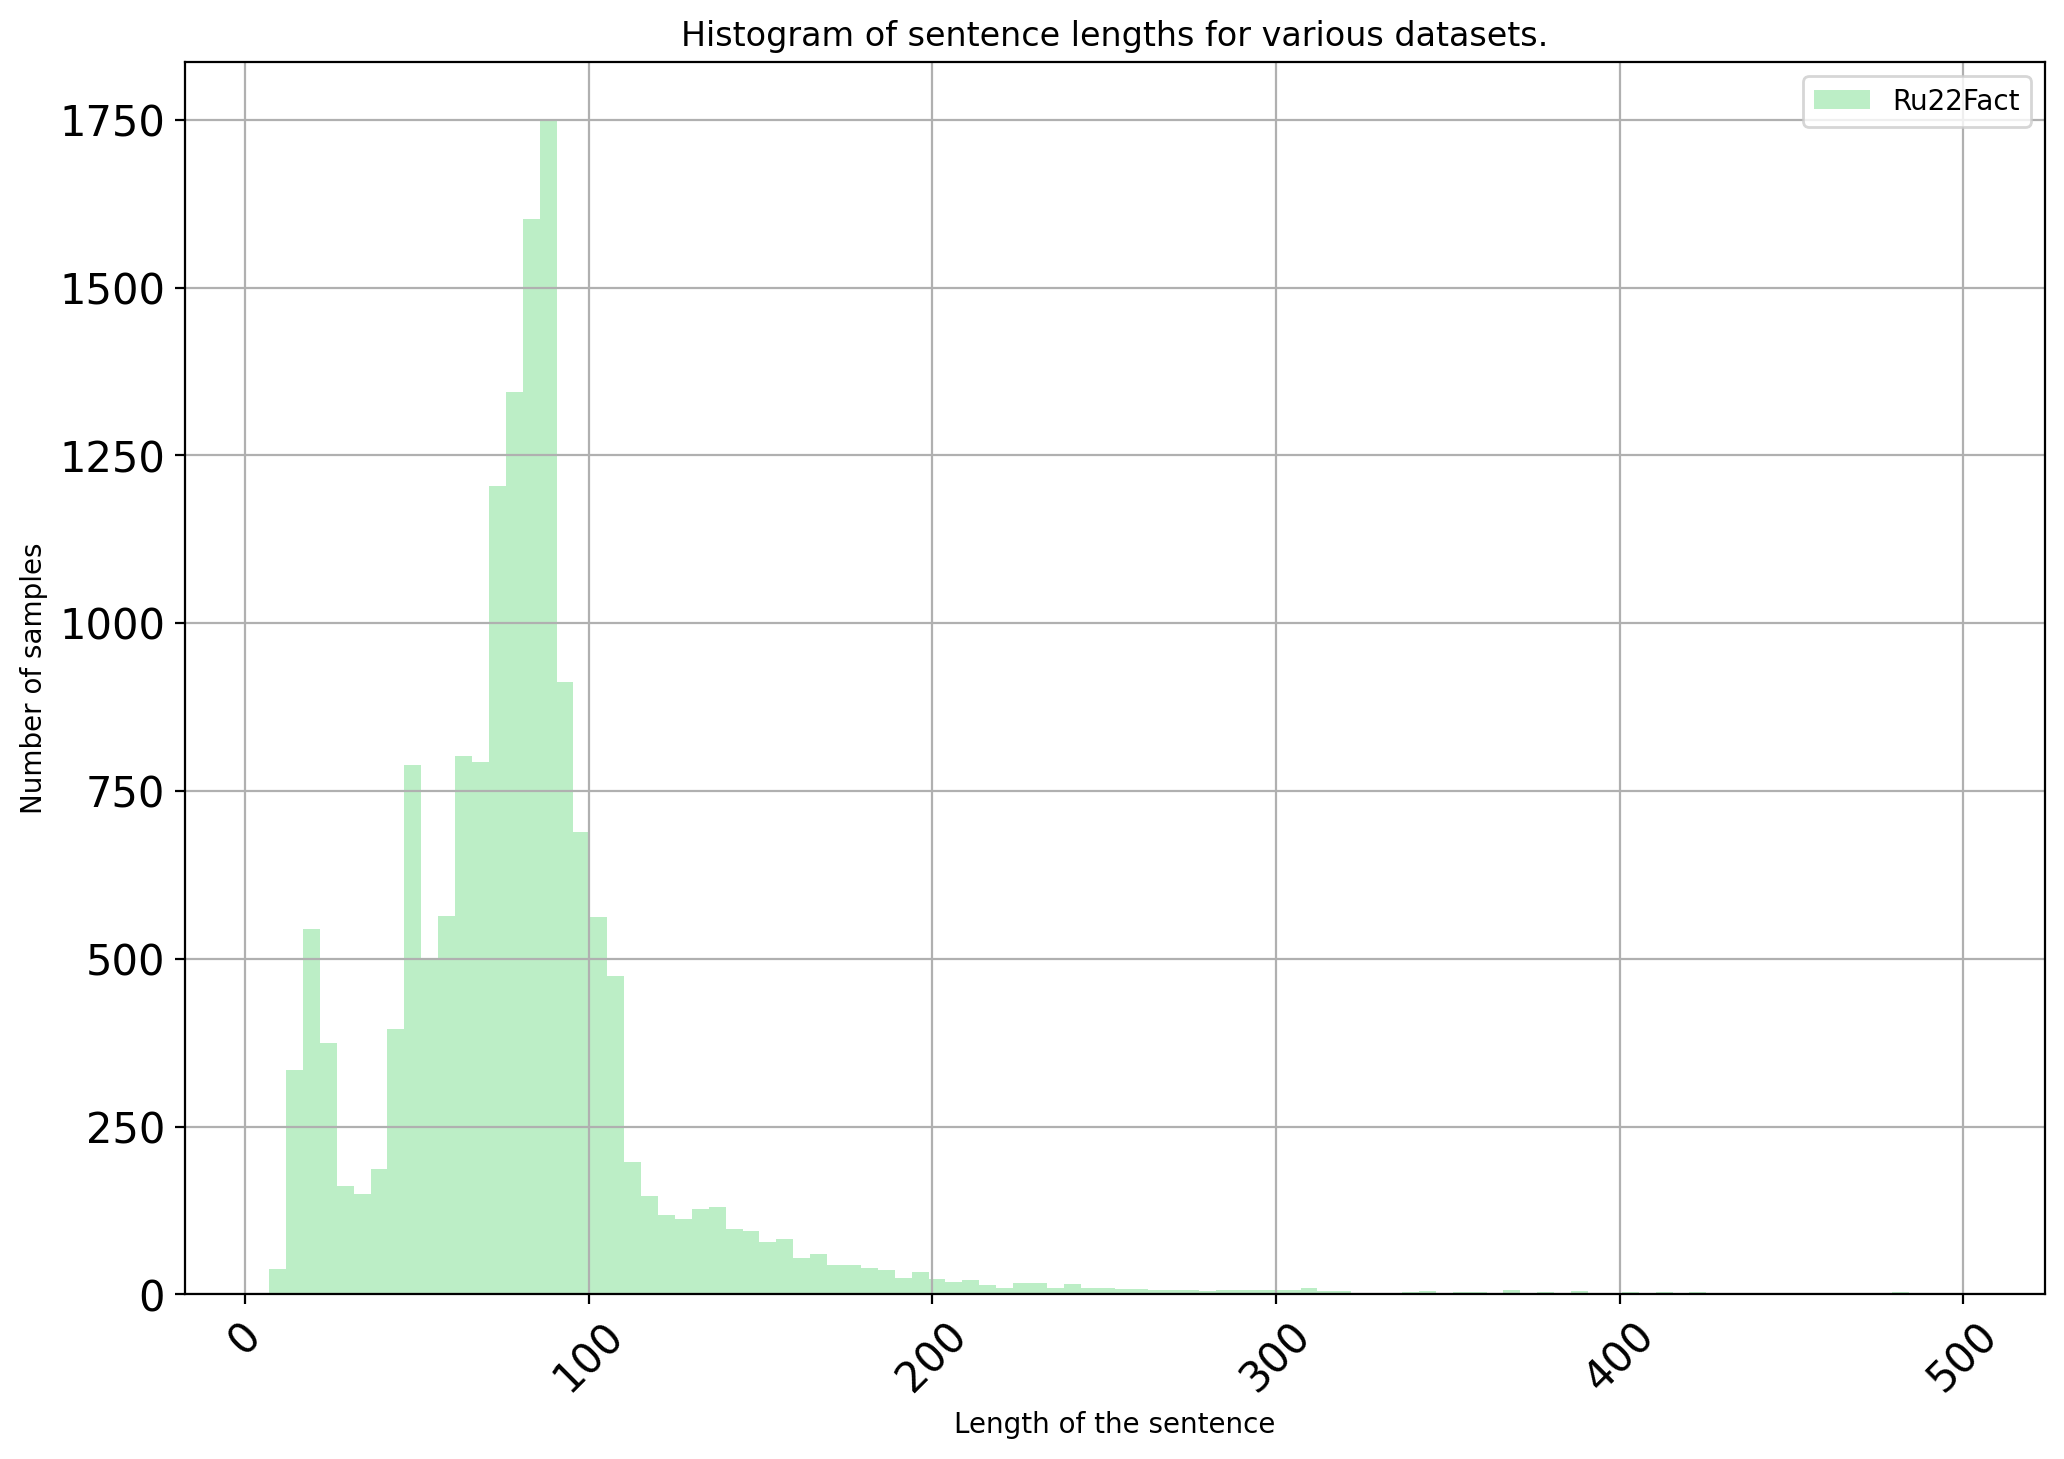

In [21]:
data = lang_distribution(ru22fact)
pie_chart(title='Language distribution', data=data)

data = class_distribution(ru22fact)
pie_chart(title='Class distribution', data=data)

histogram({'Ru22Fact': ru22fact})

### ClaimBuster dataset [Paper](https://arxiv.org/pdf/2004.14425v1)  [Data](https://zenodo.org/records/3836810)

The ClaimBuster dataset consists of statements extracted from all U.S. general election presidential debates (1960-2016) along with human-annotated check-worthiness labels where each sentence is categorized into one of the three categories: non-factual statement, unimportant factual statement, and check-worthy factual statement.

The ClaimBuster dataset consists of six files as follows:
* groundtruth.csv, (22,501 sentences)
* crowdsourced.csv, (1032 sentences)
* all_sentences.csv, (32,072 sentences)
* 2xNCS.json, (8292 sentences)
* 2.5xNCS.json, (9674 sentences)
* 3xNCS.json, (11,056 sentences)
* 
Also, all 33 presidential debate transcript files are provided as additional files in the folder “debate_transcripts”.

The files groundtruth.csv, crowdsourced.csv, and all_sentences.csv are for the paper: [A Benchmark Dataset of Check-worthy Factual Claims](https://arxiv.org/pdf/2004.14425v1)

2xNCS.json, 2.5xNCS.json, 3xNCS.json were all gathered from groundtruth.csv and crowdsourced.csv using stricter criteria with respect to the labels assigned to them. So, we expect these sets to be of higher quality and from experience we see that they produce better models. These were used in training models in the paper: Gradient-Based Adversarial Training on Transformer Networks for Detecting Check-Worthy Factual Claims. A sentence is assigned one of two classes non-check-worthy sentence (0) or check-worthy factual sentence (1). Each file has a strict ratio of sentences in the non-checkworthy class to sentences in the check-worthy class. This ratio is denoted in the file name (i.e, 2x, 2.5x, 3x). The sentences are stored as a list of dictionaries, where each dictionary has the following attributes:
  - sentence_id: A unique numerical identifier to identify sentences in the dataset.
  - label: Assigned class label (1 when the sentence is CFS, and 0 when the sentence is NCS). 
  - text: A sentence spoken by a debate participant.

|Samples:|Class 0:|Class 1:|
|--------|--------|--------|
|  23533 |  17882 |  5651  |

#### Download the dataset:

In [22]:
import os
import shutil
import requests
import zipfile
from os.path import join

# Define paths
download_url = 'https://zenodo.org/records/3836810/files/ClaimBuster_Datasets.zip?download=1'
zip_file_path = join(datasets_path, 'ClaimBuster_Datasets.zip')
claimbuster_dst_dir = join(datasets_path, 'ClaimBuster')

# Only download the dataset if necessary
if not os.path.exists(claimbuster_dst_dir):
    %pip install requests

    # Download the ZIP file
    print('Downloading ClaimBuster dataset: ', end='')
    response = requests.get(download_url, stream=True)
    with open(zip_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print('ok')

    # Ensure the destination directory exists
    os.makedirs(claimbuster_dst_dir, exist_ok=True)

    # Extract the ZIP file
    print('Extracting data: ', end='')
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(claimbuster_dst_dir)
    print('ok')

    # Clean up the ZIP file
    os.remove(zip_file_path)

    # List the extracted files
    print("ClaimBuster dataset files:\n", "\n".join(os.listdir(claimbuster_dst_dir)))
else:
    print('ClaimBuster dataset ready.')


ClaimBuster dataset ready.


#### Load the dataset:

In [6]:
import pandas as pd

groundtruth = pd.read_csv(join(datasets_path, 'ClaimBuster', 'ClaimBuster_Datasets', 'datasets', 'groundtruth.csv'))
groundtruth = groundtruth[['Text','Verdict']]
groundtruth['Verdict'] = groundtruth['Verdict'].apply(lambda x: 1 if x == 1 else 0)
groundtruth.columns = ['text', 'label']

crowdsourced = pd.read_csv(join(datasets_path, 'ClaimBuster', 'ClaimBuster_Datasets', 'datasets', 'crowdsourced.csv'))
crowdsourced = crowdsourced[['Text','Verdict']]
crowdsourced['Verdict'] = crowdsourced['Verdict'].apply(lambda x: 1 if x == 1 else 0)
crowdsourced.columns = ['text', 'label']

# # Define the path to the JSON file
# json_file_path = os.path.join(datasets_path, 'ClaimBuster', 'ClaimBuster_Datasets', 'datasets', '2xNCS.json')

# # Load the JSON file
# with open(json_file_path, 'r') as file:
#     data = json.load(file)

# # Create a DataFrame from the JSON data
# ncs = pd.DataFrame(data, columns=['text', 'label'])

claimbuster = pd.concat([groundtruth, crowdsourced])
claimbuster['lang'] = 'en'
claimbuster['topic'] = 'None'
claimbuster['style'] = 'semi'
claimbuster = claimbuster[['lang', 'topic', 'style', 'label', 'text']]
claimbuster = filter_dataframe(claimbuster)

class_0 = claimbuster[claimbuster['label'] == 0]
class_1 = claimbuster[claimbuster['label'] == 1]

table = []
table.append({'Samples:': claimbuster.shape[0],
              'Class 0:': class_0.shape[0],
              'Class 1:': class_1.shape[0]})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))
print(f"\nColumns: {claimbuster.columns.tolist()}")

|Samples:|Class 0:|Class 1:|
|--------|--------|--------|
|  23533 |  17882 |  5651  |

Columns: ['lang', 'topic', 'style', 'label', 'text']


#### Statistics:

| Languages: | en |
|------------|-------|
| Samples:   | 23533 |
| Ratio:     | 100.0% |

Language distribution


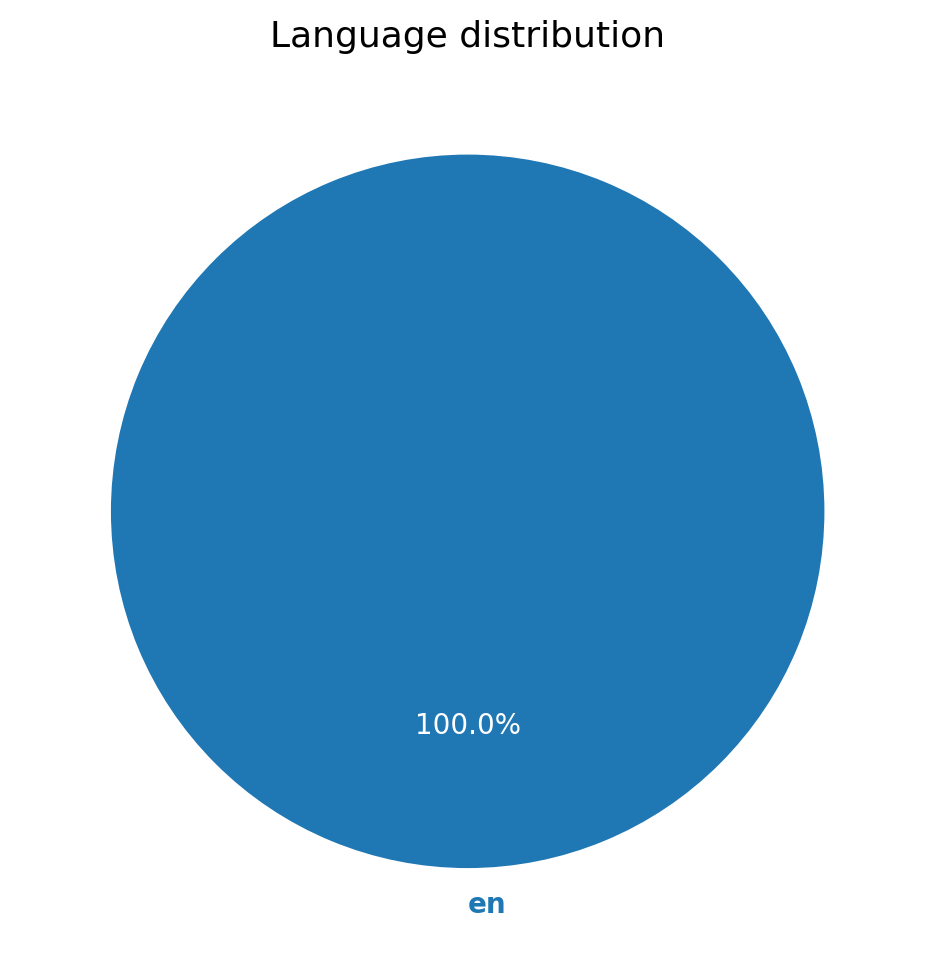

|Class 0:|Class 1:|
|--------|--------|
| 75.99% | 24.01% |
Class distribution


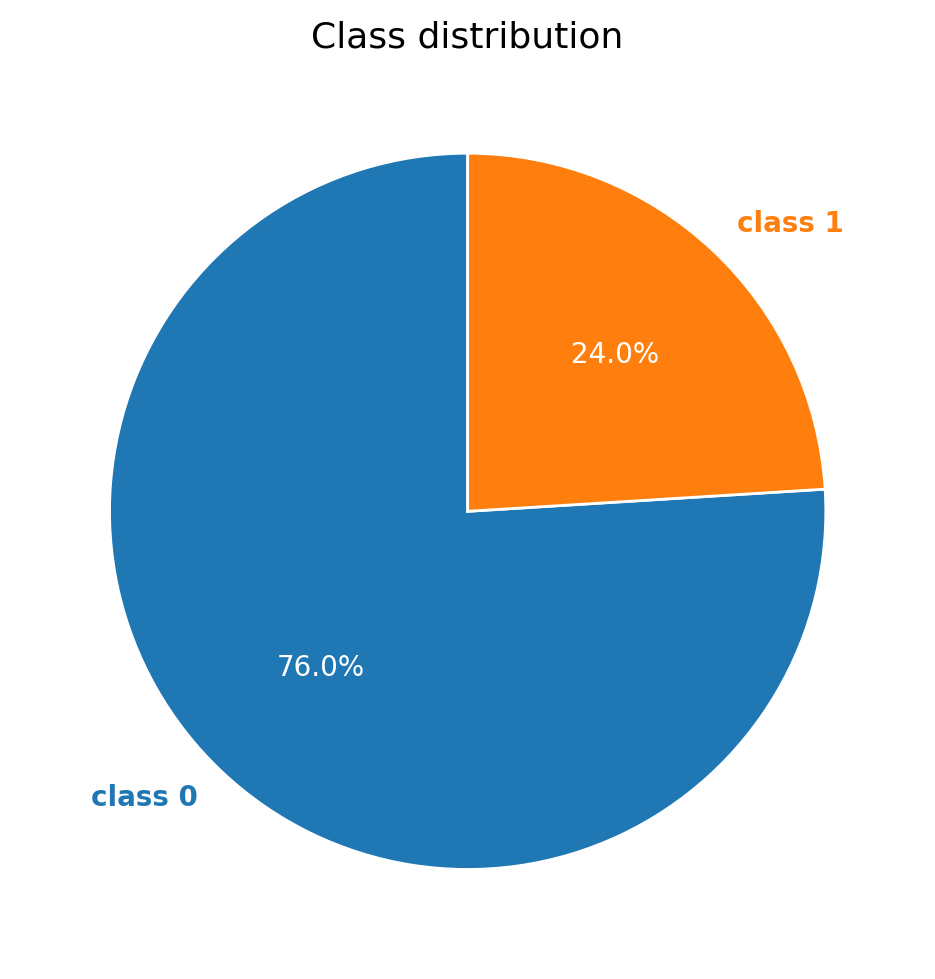

|  Dataset  |Avg. length:|
|-----------|------------|
|ClaimBuster|    96.21   |


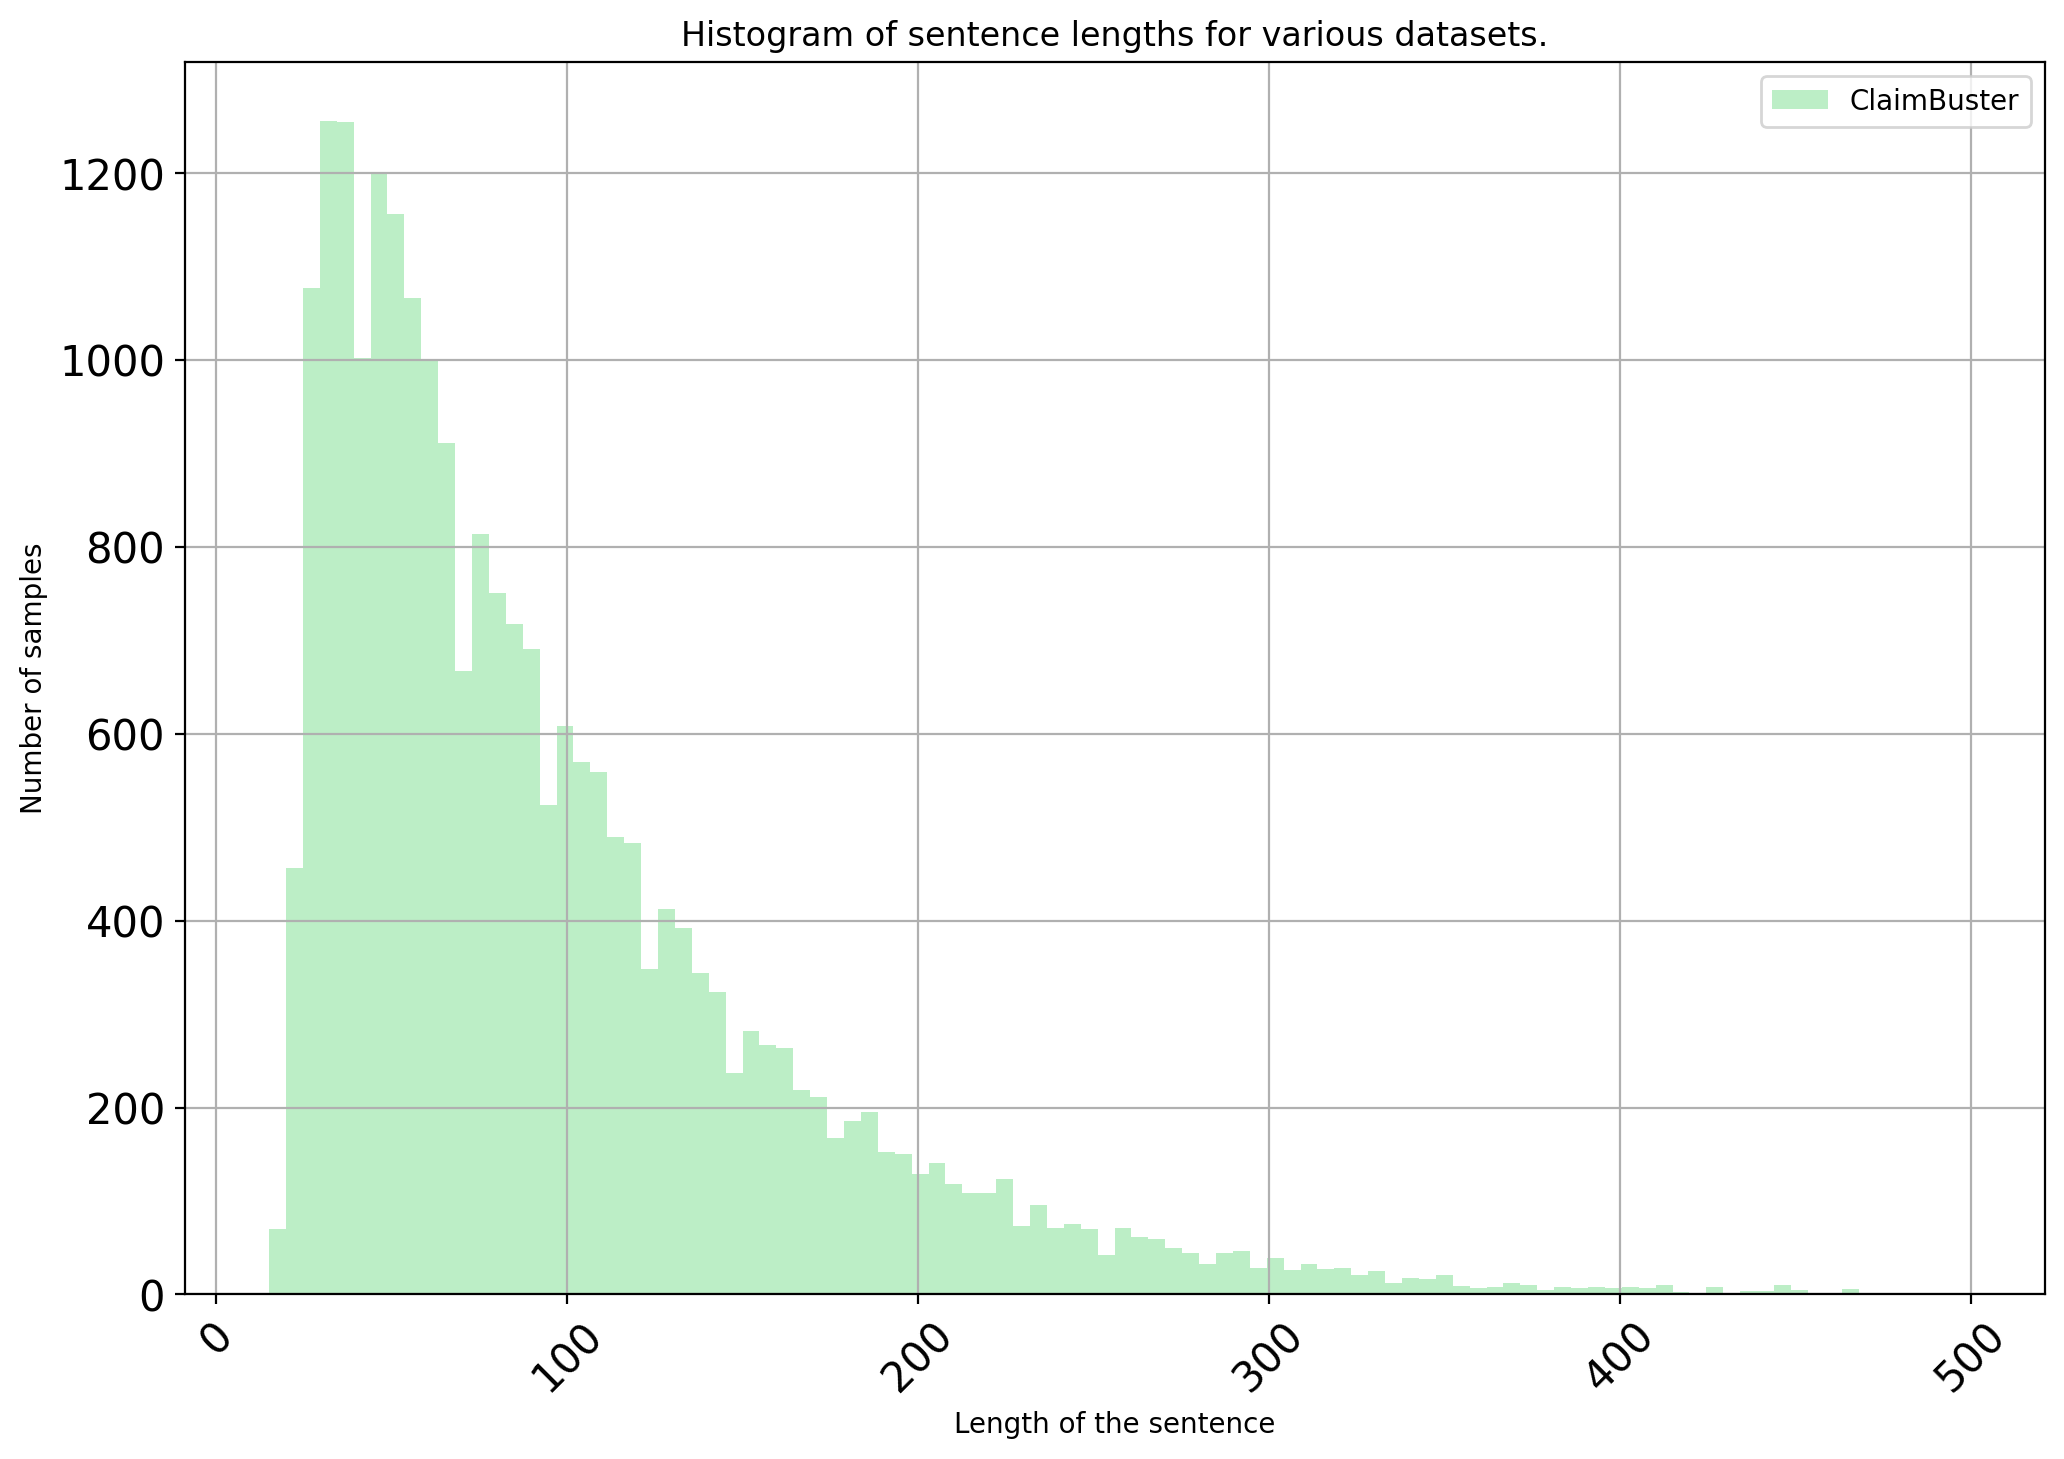

In [24]:
data = lang_distribution(claimbuster)
pie_chart(title='Language distribution', data=data)

data = class_distribution(claimbuster)
pie_chart(title='Class distribution', data=data)

histogram({'ClaimBuster': claimbuster})

### LESA dataset [Paper](https://aclanthology.org/2021.eacl-main.277.pdf) [Data](https://github.com/LCS2-IIITD/LESA-EACL-2021/tree/main)

- TW(Noisy)  : Twitter - Covid-19
- OC(semi)  : Online comments of LiveJournal
- WTP(semi) : Wiki Talk Pages
- MT( Structured) : German Microtext
- PE( Structured) : Persuasive Student Essay
- VG( Structured) : Newspaper editorials, parliamentary records abd judical summaries
- WD( Structured) : Web Discourse (blog posts & user comments)

|     Source     |   Style  |Samples[Original]:|Samples [No-duplicates]:|Language|Ratio:|
|----------------|----------|------------------|------------------------|--------|------|
|     Twitter    |   noisy  |       9981       |          9981          |   en   |24.45%|
|   LiveJournal  |   semi   |       22166      |          8531          |   en   |54.30%|
| Wiki Talk Pages|   semi   |       21838      |          8422          |   en   |53.49%|
|    Microtext   |structured|       1182       |           449          |   en   | 2.90%|
|Persuasive Essay|structured|       18277      |          7046          |   en   |44.77%|
|     Various    |structured|       6662       |          2568          |   en   |16.32%|
|  Web Discourse |structured|       9811       |          3888          |   en   |24.03%|
|      Total     |          |       89917      |          40823         |   en   | 100% |

|Class 0:|Class 1:|
|--------|--------|
| 76.47% | 23.53% |

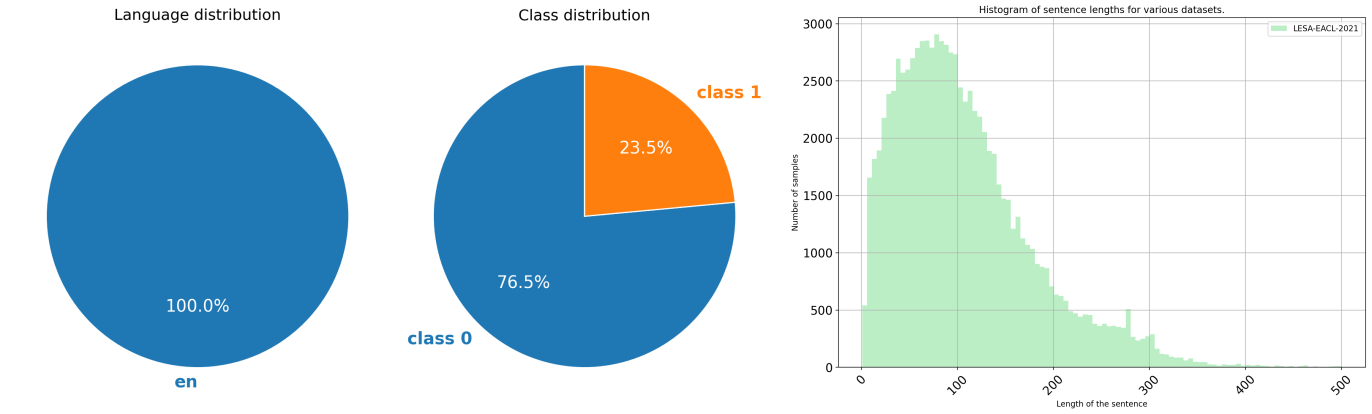

#### Download the dataset:

In [25]:
import os
import time
import shutil

from os.path import join

import pdb

# Define paths
repo_url = 'https://github.com/LCS2-IIITD/LESA-EACL-2021.git'
clone_dir = join(datasets_path, 'lesa-temp')

# Define source and destination directories
lesa_src_dir = os.path.join(clone_dir, 'data')
lesa_dst_dir = join(datasets_path, 'LESA-EACL-2021')

# Only download the dataset if necessarry
if not os.path.exists(lesa_dst_dir):
    !pip install gitpython patool
    import patoolib

    # Clone the repository if it doesn't exist
    if not os.path.exists(clone_dir):
        !pip install gitpython

        import git

        print('Downloading LESA-EACL-2021: ', end='')
        git.Repo.clone_from(repo_url, clone_dir)
        print('ok')

    print('Retrieving data: ', end='')

    # Ensure the destination directories exist
    shutil.copytree(lesa_src_dir, lesa_dst_dir)

    print('ok')

    print(shutil.rmtree(clone_dir))

    # List the extracted files
    print("LESA-EACL-2021 data list:\n", "\n".join(os.listdir(lesa_dst_dir)))
else:
    print('LESA-EACL-2021 dataset ready.')

LESA-EACL-2021 dataset ready.


#### Load the dataset:

In [4]:
import glob

def flatten(_list):
    return [item for sublist in _list for item in sublist]

def extract_files(path: str) -> DataFrame:
    train = []
    dev = []
    test = []

    # Find paths of all the files with specific extension
    train_files = flatten([glob.glob(join(path, '*.train'))])
    dev_files = flatten([glob.glob(join(path, '*.dev'))])
    test_files = flatten([glob.glob(join(path, '*.test'))])

    # Read all samples from files into a perticular sets
    for _file in train_files:
      train.append(pd.read_csv(_file, header=None, sep='\t'))

    for _file in dev_files:
      dev.append(pd.read_csv(_file, header=None, sep='\t'))

    for _file in test_files:
      test.append(pd.read_csv(_file, header=None, sep='\t'))

    # Merge all the samples for each set and format it accordingly
    train = pd.concat(train)
    train.columns = ['text', 'label']
    dev = pd.concat(dev)
    dev.columns = ['text', 'label']
    test = pd.concat(test)
    test.columns = ['text', 'label']

    train = train.drop_duplicates()
    dev = dev.drop_duplicates()
    test = test.drop_duplicates()

    subset = pd.concat([train, dev, test])

    return subset
    #return train, dev, test  # Uncomment in order to match the LESA original train, validation and test sets structure

tw = pd.read_csv(join(lesa_dst_dir, 'Twitter.csv'))[['tweet_text', 'claim']]
tw.columns = ['text', 'label']
tw['lang'] = 'en'
tw['source'] = 'Twitter'
tw['topic'] = 'health'
tw['style'] = 'noisy'

oc = extract_files(join(lesa_dst_dir, 'OC'))
oc['lang'] = 'en'
oc['topic'] = 'various'
oc['style'] = 'semi'
oc['source'] = 'LiveJournal'

wtp = extract_files(join(lesa_dst_dir, 'WTP'))
wtp['lang'] = 'en'
wtp['topic'] = 'various'
wtp['style'] = 'semi'
wtp['source'] = 'Wiki Talk Pages'

mt = extract_files(join(lesa_dst_dir, 'MT'))
mt['lang'] = 'en'
mt['topic'] = 'various'
mt['style'] = 'structured'
mt['source'] = 'Microtext'

pe = extract_files(join(lesa_dst_dir, 'PE'))
pe['lang'] = 'en'
pe['topic'] = 'various'
pe['style'] = 'structured'
pe['source'] = 'Persuasive Essay'

vg = extract_files(join(lesa_dst_dir, 'VG'))
vg['lang'] = 'en'
vg['topic'] = 'politics'
vg['style'] = 'structured'
vg['source'] = 'Various'

wd = extract_files(join(lesa_dst_dir, 'WD'))
wd['lang'] = 'en'
wd['topic'] = 'various'
wd['style'] = 'structured'
wd['source'] = 'Web Discourse'

lesa_original = pd.concat([tw, oc, wtp, mt, pe, vg, wd])
lesa_original = lesa_original[['lang', 'topic', 'style', 'label', 'text']]
lesa_original = filter_dataframe(lesa_original)

# Drop duplicates
lesa2021 = lesa_original.drop_duplicates(subset=['text'], keep='first')
lesa2021 = filter_dataframe(lesa2021)

# Calculate the total number of samples to compute the ratio
table = []
total_samples = lesa2021.shape[0]

for part in [tw, oc, wtp, mt, pe, vg, wd]:
    filtered = part.drop_duplicates(subset=['text']).shape[0]
    table.append({'Source': part['source'].unique()[0],
                  'Style': part['style'].unique()[0],
                  'Samples[Original]:': part.shape[0],
                  'Samples [No-duplicates]:': filtered,
                  'Language': 'en',
                  'Ratio:': f"{(part.shape[0] / total_samples) * 100:.2f}%"})

table.append({'Source': 'Total',
              'Style': ' ',
              'Samples[Original]:': lesa_original.shape[0],
              'Samples [No-duplicates]:': lesa2021.shape[0],
              'Language': 'en',
              'Ratio:': '100%'})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))
print(f"\nColumns: {lesa2021.columns.tolist()}")


|     Source     |   Style  |Samples[Original]:|Samples [No-duplicates]:|Language|Ratio:|
|----------------|----------|------------------|------------------------|--------|------|
|     Twitter    |   noisy  |       9981       |          9981          |   en   |24.46%|
|   LiveJournal  |   semi   |       22166      |          8531          |   en   |54.33%|
| Wiki Talk Pages|   semi   |       21838      |          8422          |   en   |53.52%|
|    Microtext   |structured|       1182       |           449          |   en   | 2.90%|
|Persuasive Essay|structured|       18277      |          7046          |   en   |44.80%|
|     Various    |structured|       6662       |          2568          |   en   |16.33%|
|  Web Discourse |structured|       9811       |          3888          |   en   |24.05%|
|      Total     |          |       89891      |          40800         |   en   | 100% |

Columns: ['lang', 'topic', 'style', 'label', 'text']


### Dataset Filtering
- We discovered that the noisy and semi-noisy part of the LESA dataset contain samples that do not fulfill our definition of the check-worthy claim. Therefore, we use LLM to filter out the samples that do not match the criteria.

In [5]:
if exists(join(lesa_dst_dir, 'lesa-filtered.csv')):
    lesa_filtered = pd.read_csv(join(lesa_dst_dir, 'lesa-filtered.csv'))

    lesa_0 = lesa_filtered[lesa_filtered['label'] == 0]
    lesa_1 = lesa_filtered[lesa_filtered['label'] == 1]

else:
    lesa_noisy = lesa2021[lesa2021['style'] == 'noisy']
    lesa_semi = lesa2021[lesa2021['style'] == 'semi']
    lesa = pd.concat([lesa_noisy, lesa_semi])
    lesa = lesa.reset_index()
    
    valid = []
    invalid = []
    filtered_count = 0
    
    # Process the samples into two sets - valid samples according our definition and invalid ones
    with tqdm(total=lesa.shape[0]) as pbar:
        for index, row in lesa.iterrows():
            if is_claim_with_context(row['text']):
                valid.append(row)
            else:
                invalid.append(row)
                filtered_count += 1
    
            # Calculate and display the percentage of samples filtered out
            filtered_percentage = (filtered_count / (index + 1)) * 100
            pbar.set_description(f"Filtered out: {filtered_percentage:.2f}%")
            pbar.update(1)
    
    # Filtering summary
    total_samples = lesa.shape[0]
    filtered_percentage = (filtered_count / total_samples) * 100
    print(f"Total samples: {total_samples}")
    print(f"Filtered out: {filtered_count} samples ({filtered_percentage:.2f}%)")
    
    
    # Convert the lists to DataFrames
    valid = DataFrame(valid)
    invalid = DataFrame(invalid)
    
    # Save the invalid samples for manual evaluation
    invalid.to_csv(join(lesa_dst_dir, 'lesa-no-claim.csv'), index=False, header=True)
    
    # Compose a filtered dataset
    invalid['label'] = 0                                            # Invalid samples are re-labeled as non-check-worthy
    lesa_filtered = pd.concat([valid, invalid])                     # Merge the samples after the filtration
    lesa_filtered = lesa_filtered.sample(frac = 1, random_state=26) # Shuffle the dataset
    lesa_filtered.to_csv(join(lesa_dst_dir, 'lesa-filtered.csv'), index=False, header=True)

# Calculate the total number of samples to compute the ratio
table = []

table.append({'Source': 'Total',
              'Samples:': lesa_filtered.shape[0],
              'Language': 'en',
              'Class 0:': lesa_0.shape[0],
              'Class 1:': lesa_1.shape[0]})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))
print(f"\nColumns: {lesa_filtered.columns.tolist()}")

  0%|          | 0/26896 [00:00<?, ?it/s]

ResponseError: model "gemma3:4b" not found, try pulling it first (status code: 404)

#### Statistics:

| Languages: | en |
|------------|-------|
| Samples:   | 40800 |
| Ratio:     | 100.0% |

Language distribution


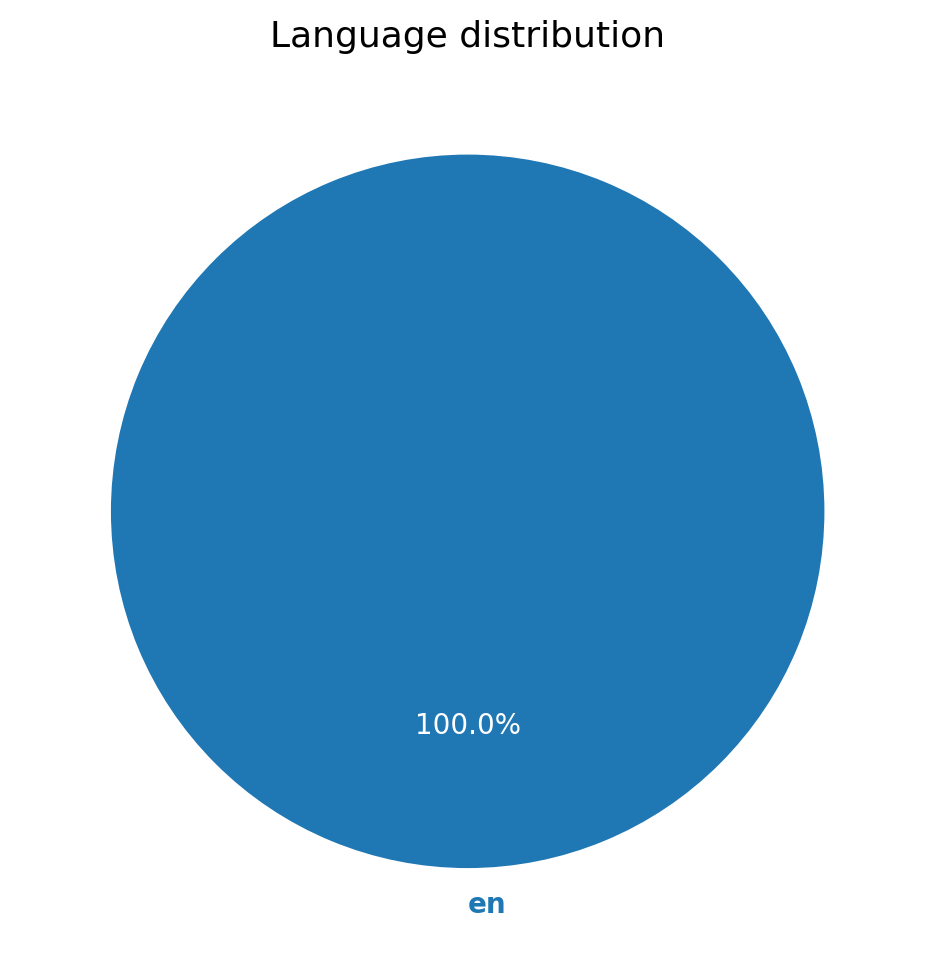

|Class 0:|Class 1:|
|--------|--------|
| 66.89% | 33.11% |
Class distribution


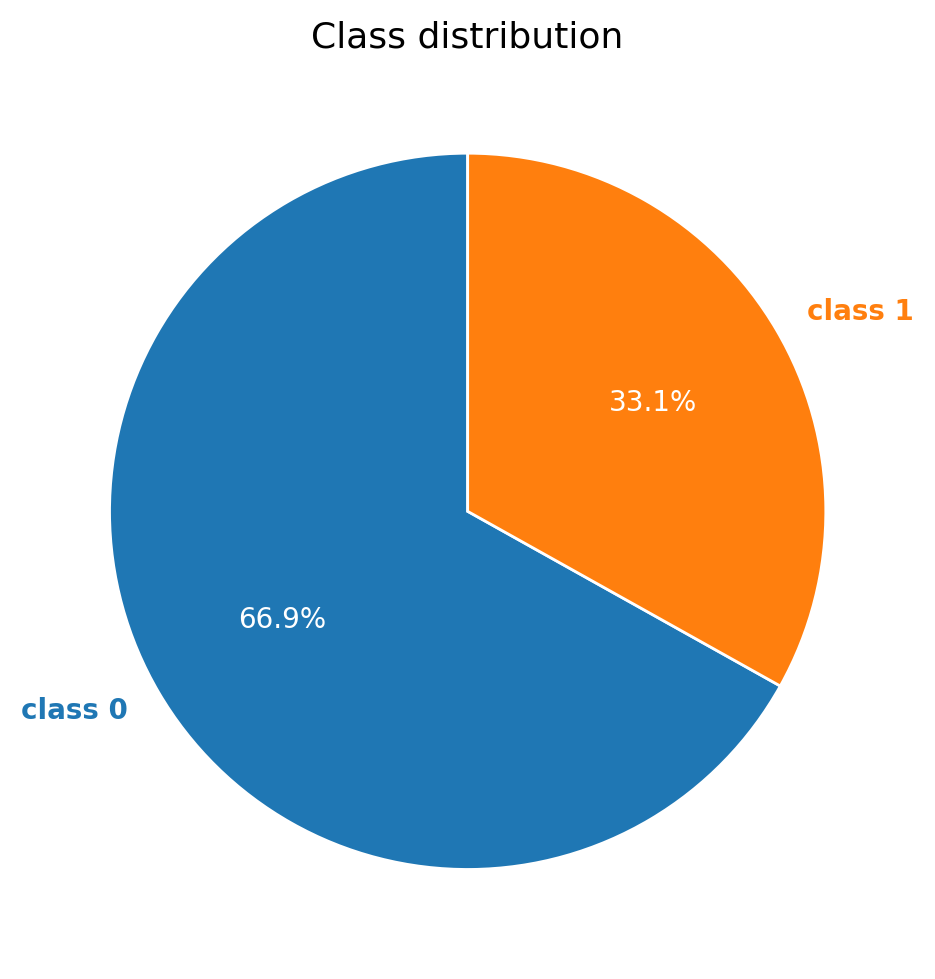

|    Dataset   |Avg. length:|
|--------------|------------|
|LESA-EACL-2021|    117.5   |


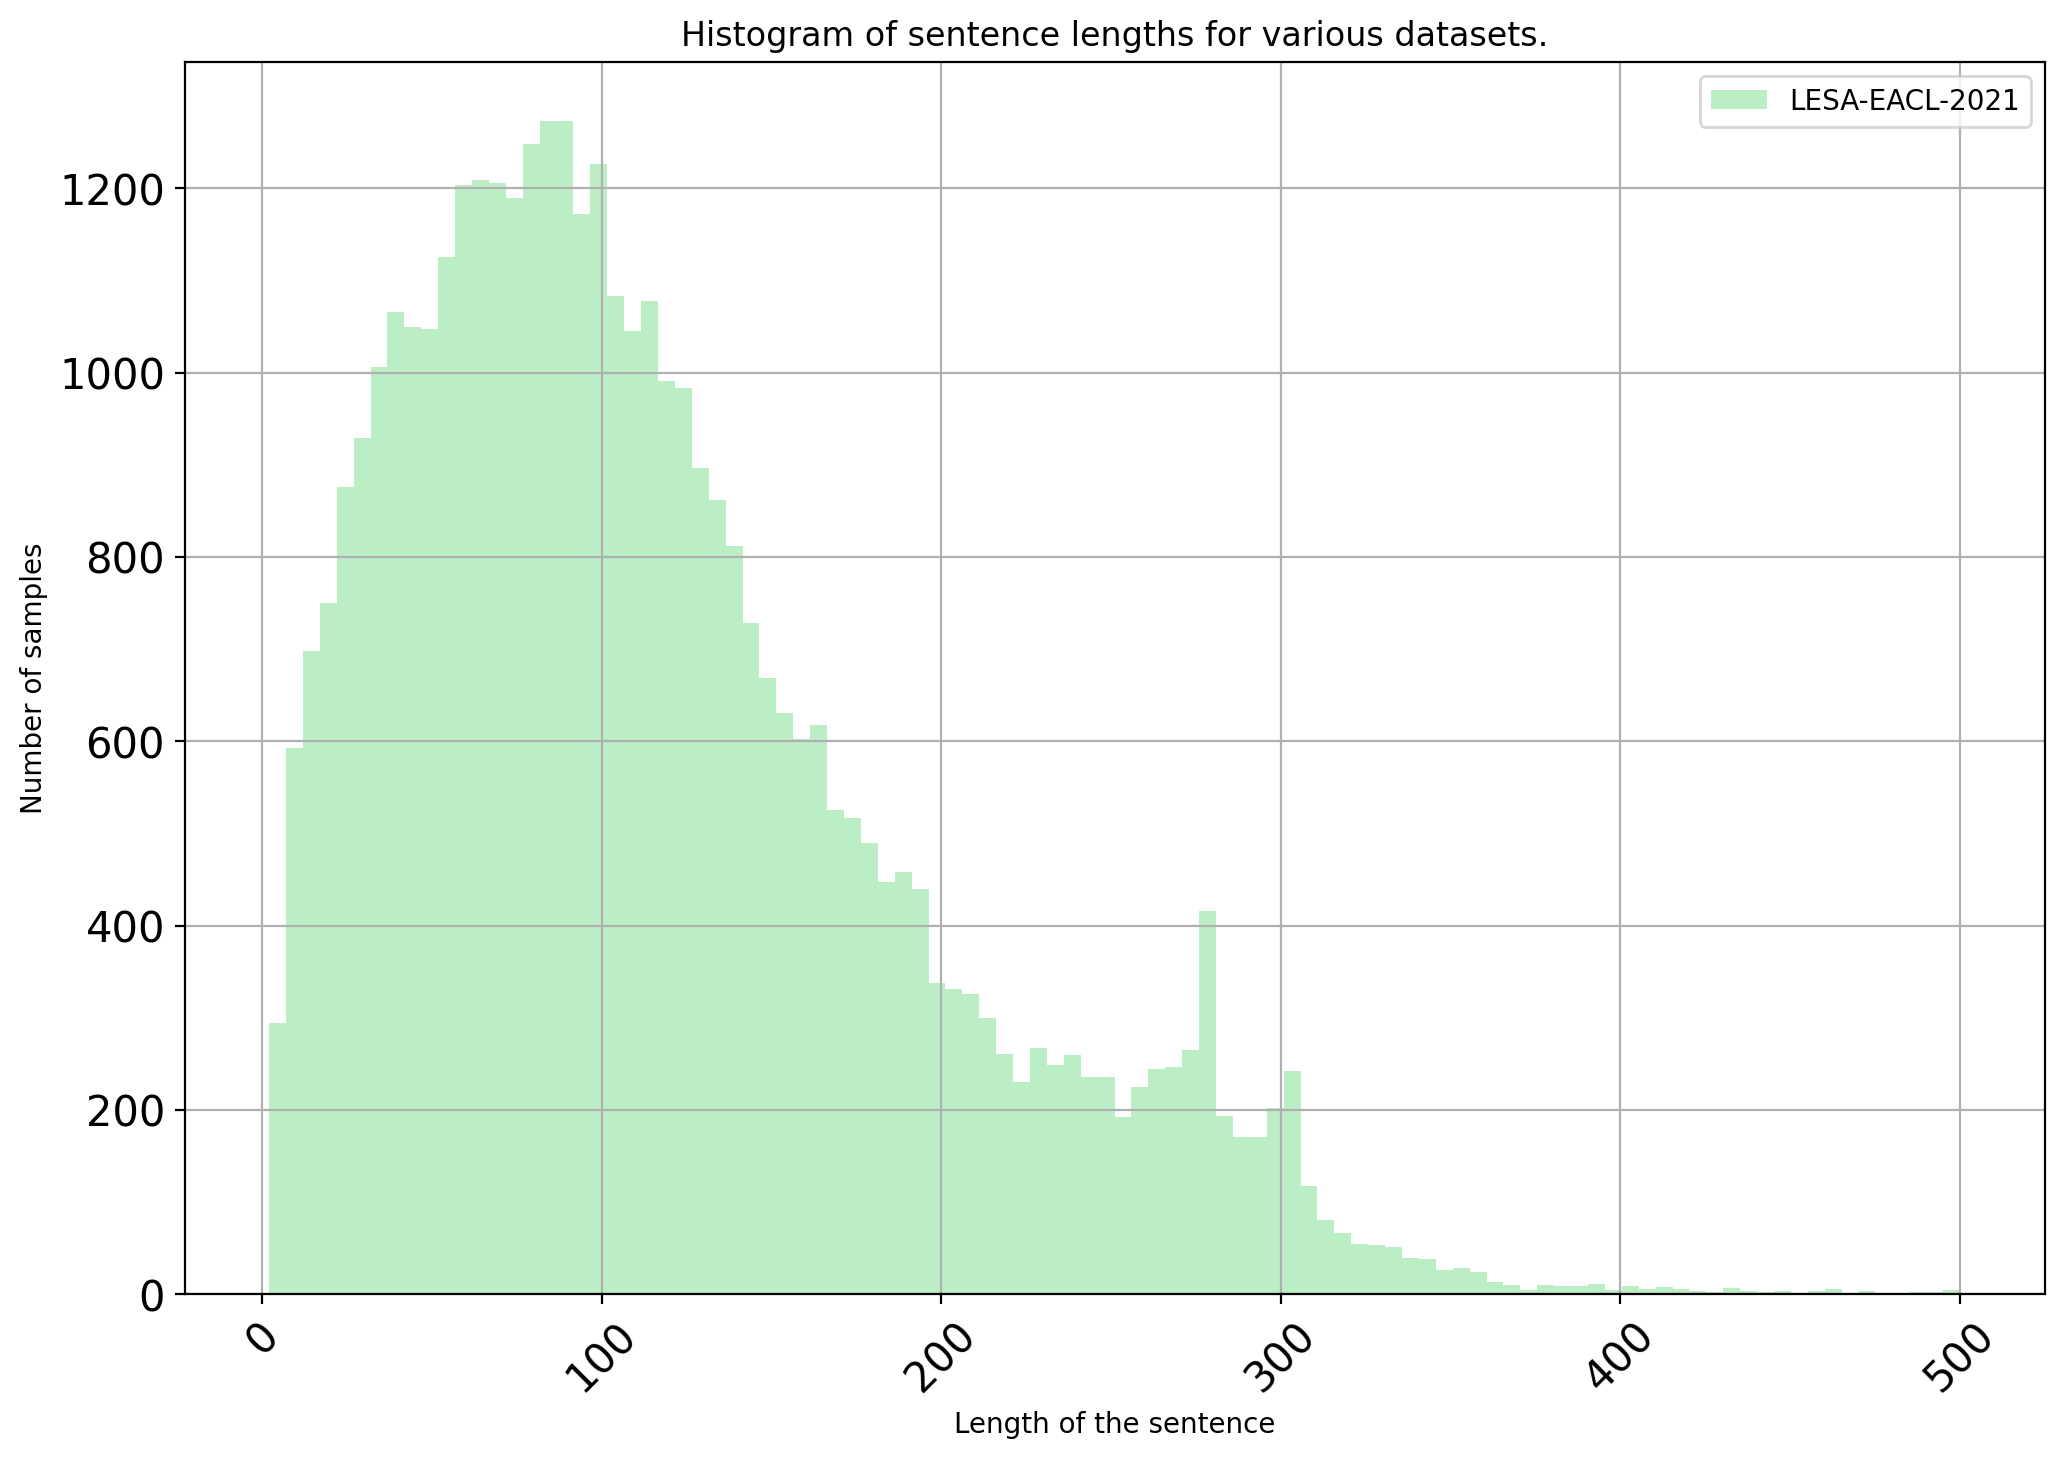

In [28]:
data = lang_distribution(lesa2021)
pie_chart(title='Language distribution', data=data)

data = class_distribution(lesa2021)
pie_chart(title='Class distribution', data=data)

histogram({'LESA-EACL-2021': lesa2021})

## MultiCW Dataset
Generalized dataset of check-worthy claims composed of Noisy & Structured part from the following datasets.

Noisy part:
* CLEF-2022
* CLEF-2023
* MultiClaim-extended (soc. media posts)
  
Structured part:
* MultiClaim-zenodo (fact-checks) 
* MultiClaim-extended (fact-checks)
* Ru22Facts



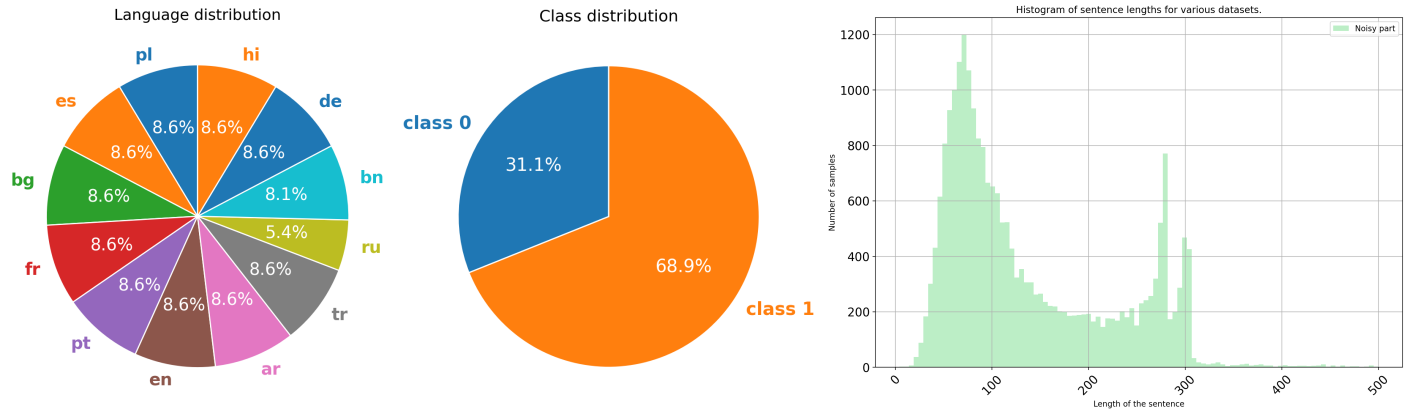


### Composition of the unbalanced dataset
The composition of the samples from the mentioned datasets contains up to 2000 samples from each language. The selection of the languages included primarily the Slovak, Polish, Czech, Bulgarian, Russian, Ukrainian and Chinese languages, extended with all other languages that contain at least 1500 sample in both noisy and structured writing style.

The resulting dataset requires balancing in terms of languages, of its structured part, namely for Bulgarian language and its noisy part for Slovak, Czech, Russian, Ukrainian and Chinese. The balancing in terms of classes is also necessary, as the structured part of the dataset is composed of fact-check claims that are considered check-worthy (decided by a human fact-checker), therefore of class 1. Noisy part of the dataset is also heavy inbalanced as seen in the following table.

Unbalanced dataset composition:


|Language|Noisy (class 0):|Noisy (class 1):|Structured (class 1):|
|--------|----------------|----------------|---------------------|
|   sk   |        0       |       504      |         3000        |
|   pl   |        0       |      2487      |         3000        |
|   cs   |        0       |       568      |         3000        |
|   bg   |      2118      |       845      |         329         |
|   ru   |        0       |      1149      |         3000        |
|   uk   |        0       |       29       |         3000        |
|   zh   |        0       |       559      |         3000        |
|   hi   |        0       |      3000      |         3000        |
|   de   |        0       |      3000      |         3000        |
|   ar   |      1866      |      1134      |         3000        |
|   tr   |      2473      |       527      |         3000        |
|   es   |      1849      |      1151      |         3000        |
|   nl   |      1090      |      1910      |         1227        |
|   my   |        0       |      1340      |         1297        |
|   it   |        0       |      1482      |         3000        |
|   mk   |        0       |      1385      |         1123        |
|   bn   |        0       |      1953      |         3000        |
|   en   |      2348      |       652      |         3000        |
|   pt   |        0       |      3000      |         3000        |
|   fr   |        0       |      3000      |         3000        |

In [ ]:
import pandas as pd
from tqdm import tqdm

# Enable tqdm for pandas
tqdm.pandas()


# Make sure the MultiCW directory exists
os.makedirs(multicw_path, exist_ok=True)

# Required languages
languages = ['sk', 'pl', 'cs', 'bg', 'ru', 'uk', 'zh']


# Create a composition from the datasets
noisy_part = pd.concat([clef2022, clef2023, mc_ext_posts, mc_zenodo_posts])
struc_part = pd.concat([mc_zenodo_fc, mc_ext_fc, ru22fact])

# Drop duplicates that may occur between the datasets
noisy_part = noisy_part.drop_duplicates(subset='text', keep='first')
struc_part = struc_part.drop_duplicates(subset='text', keep='first')

# Replace an incorrect country code for Malaysia
noisy_part['lang'] = noisy_part['lang'].replace('ml', 'my')
struc_part['lang'] = struc_part['lang'].replace('ml', 'my')

# Determine the language composition of both noisy and structured part
noisy_languages = noisy_part['lang'].unique()
struc_languages = struc_part['lang'].unique()
intersecting_languages = list(set(noisy_languages).intersection(set(struc_languages)))

# Find all languages that in both dataset parts have more than 1500 samples
for lang in intersecting_languages:
    noisy = noisy_part[noisy_part['lang']==lang]
    struc = struc_part[struc_part['lang']==lang]
    if lang not in languages and noisy.shape[0] >= 1000 and struc.shape[0] >= 1000:
        languages.append(lang)

noisy = []
struc = []

# Extract the selected languages and restrict the maximum number of samples per language to 3000
# 3000 = (2x the target size) due to expected filtration
for lang in languages:
    
    print(f'{h_yellow}Processing {lang}: {h_stop}', end='')

    # Make sure the folder path exists
    os.makedirs(join(multicw_path, lang), exist_ok=True)
    
    # Prepare the new files paths
    noisy_path = join(multicw_path, lang, 'noisy_unbalanced.csv')
    struc_path = join(multicw_path, lang, 'struc_unbalanced.csv')
    noisy_histogram_path = join(multicw_path, lang, 'noisy_histogram.csv')
    struc_histogram_path = join(multicw_path, lang, 'struc_histogram.csv')
    
    # If the translation and histogram already exist
    if exists(noisy_path) and exists(struc_path):
        noisy_sub = pd.read_csv(noisy_path)    
        struc_sub = pd.read_csv(struc_path)

        noisy.append(noisy_sub)
        struc.append(struc_sub)

        print(f'{h_green} exists {h_stop}')
        
        continue
    else:
        print('')

    # Extract language specific subset
    noisy_sub = noisy_part[noisy_part['lang']==lang].copy().reset_index()
    struc_sub = struc_part[struc_part['lang']==lang].copy().reset_index()

    # Restrict the number of samples to 3000
    noisy_sub = noisy_sub if noisy_sub.shape[0] <= 3000 else noisy_sub[:3000]
    struc_sub = struc_sub if struc_sub.shape[0] <= 3000 else struc_sub[:3000]

    print('Translating Noisy part:')
    noisy_sub['text_en'] = parallel_deeptranslate(noisy_sub['text'], lang, 'en')
    print('Translating Structured part:')
    struc_sub['text_en'] = parallel_deeptranslate(struc_sub['text'], lang , 'en')

    # Extract entities from the noisy part samples
    print(f'Extracting noisy-part GLiNER entities: {lang}')
    # if lang == 'hi':
    #     # For Hindi the model tends to extract significantly fewer entities.
    #     # Therefore, we use the preprocessed English samples for the NER and translate those back to Hindi.
    #     entities, noisy_histogram = gliner_entities(noisy_sub['text_en'], 'en', gliner)
    #     entities = deeptranslate(entities, 'hi', 'en', False)
    #     noisy_sub['entities'] = entities
    # else:
    entities, noisy_histogram = gliner_entities(noisy_sub['text'], lang, gliner)
    noisy_sub['entities'] = entities

    print(f'Extracting Noisy part topics:')
    noisy_sub['topic'] = extract_topics(noisy_sub['text_en'])
    print(f'Extracting Structured part topics:')
    struc_sub['topic'] = extract_topics(struc_sub['text_en'])
    
    # Save the results to the corresponding files
    noisy_sub.to_csv(noisy_path, header=True, index=False)
    noisy_histogram.to_csv(noisy_histogram_path, header=True, index=False)

    print(f'Updated noisy dataset and histogram saved to {join(multicw_path, lang)}')

    # Extract entities from the structured part samples
    print(f'Extracting structured-part GLiNER entities: {lang}')
    # if lang == 'hi':
    #     # For Hindi the model tends to extract significantly fewer entities.
    #     # Therefore, we translate the samples to English and back to Hindi after the extraction.
    #     entities, struc_histogram = gliner_entities(struc_sub['text_en'], 'en', gliner)
    #     entities = deeptranslate(entities, 'hi', 'en', False)
    #     struc_sub['entities'] = entities
    # else:
    entities, struc_histogram = gliner_entities(struc_sub['text'], lang, gliner)
    struc_sub['entities'] = entities

    # Save the results to the corresponding files
    struc_sub.to_csv(struc_path, header=True, index=False)
    struc_histogram.to_csv(struc_histogram_path, header=True, index=False)

    print(f'Updated structured dataset and histogram saved to {join(multicw_path, lang)}')

    # Store the overall results
    noisy.append(noisy_sub)
    struc.append(struc_sub)

noisy = pd.concat(noisy)
struc = pd.concat(struc)

noisy.to_csv(join(multicw_path, 'noisy_part.csv'), header = True, index=False)
struc.to_csv(join(multicw_path, 'struc_part.csv'), header = True, index=False)

# Print statistics for each unique language in the current MultiCW dataset
table = []
translations = []
for lang in languages:
    noisy_subset = noisy[noisy['lang'] == lang]
    struc_subset = struc[struc['lang'] == lang]
    table.append({'Language': lang,
                  'Noisy (class 0):': noisy_subset.loc[noisy_subset['label'] == 0].shape[0],
                  'Noisy (class 1):': noisy_subset.loc[noisy_subset['label'] == 1].shape[0],
                  'Structured (class 1):': struc_subset.shape[0]})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))

### Balancing the Noisy and Structured part:
In order to balance the fact-checks (Structured part) that only contain a class 1 samples we first extract the named entities for each sample from the list of valid entity categories (see below). We have chosen to extract only those, that might contain a relevant information for fact-checking, e.g.:

[**Public figure, Organization,  Location, Geo-Political Entity, Public event**, etc.]

- On the extracted entities we perform the Entity Matching using the Levenshtein distnace, effectively reducing the number of entities by merging the similar ones, into a single entity. As the samples are multilingual, the condition for merging is that the similar entities must also share the same language.

- Next, based on the histohram of extracted named entities, we search and scrape the wikipedia articles that match the Named Entity. From the scraped text we extract the number of sentences relative to the frequency of the Entity in the dataset, respecting the distribution of the topics within the dataset. So for example the entity "Donald Trunp" is represented by 1351 occurences in the original dataset, which is ~ 3.5x more then the entity "Joe Biden" with 369 occurences. Therefore, we use up to 1351 sentences from the wikipedia page about Donald Trump and only up to 369 sentences from the page about Joe Biden.

#### Wikipedia sentences extraction
- Using the sentences from the wikipedia articles relevant to the extracted Named entities
- The ratio of sentences is equivalent to the histogram frequencies of the named entities
- <font color='red'>To run this process for each language in parallel, run the script ```python Tools/wiki_scraping.py --lang=<YOUR_LANG>``` from your terminal </font>
- <font color='red'>See ```Tools/wiki_scraping.py``` for more information.</font>

In [ ]:
from concurrent.futures import ThreadPoolExecutor

max_workers = 4

def wiki_scraping(index:int, lang: str, verbose=True):
    # Initialize extractor
    extractor = WikipediaExtractor(verbose)
    wiki_path = join(multicw_path, lang, 'wiki.csv')
    
    # Load language specific named entity histogram
    noisy_hist = pd.read_csv(join(multicw_path, lang, 'noisy_histogram.csv'))
    struc_hist = pd.read_csv(join(multicw_path, lang, 'struc_histogram.csv'))
    histogram = pd.concat([noisy_hist, struc_hist]).drop_duplicates(subset='entity', keep='first')
    histogram = histogram.sort_values(by=['frequency'], ascending=False)
    
    # In case of not enough entities in the histogram, supply them from translated English histogram
    if histogram.shape[0] < 1000:
        print('Extending the histogram with English named entities:')
        histogram_en = pd.read_csv(join(multicw_path, 'en', '_struc_histogram.csv'))[:500]
        histogram_en = histogram_en.sort_values(by=['frequency'], ascending=False)
        histogram_en['entity'] = parallel_deeptranslate(histogram_en['entity'], 'en', lang)
        histogram = pd.concat([histogram, histogram_en])
        
    print(f'{h_yellow}Extracting Wikipedia samples using found named entities: {lang}{h_stop}')
    extracted_data = []
    existing_entities = []
    for index, row in tqdm(histogram.iterrows(), total=histogram.shape[0]):
        entity = row['entity']
    
        if not entity:
            continue
    
        # Ignore the entities that were already collected
        if entity in existing_entities:
            continue
        else:
            existing_entities.append(entity)
    
        # Extract the sentences for each entity.
        extracted_data.append(extractor.extract_wiki(entity, lang))
    
        # Save the results continuously
        result = pd.concat(extracted_data)
        if result.shape[0] <= 2000:
            result.to_csv(wiki_path, index=False)
        else:
            break


    return index, text

# Retrieve all the languages in case of separate cell execution
if not 'languages' in locals():
    languages = pd.read_csv(join(multicw_path, 'noisy_part.csv'))['lang'].unique()
    
for lang in languages:
    wiki_scraping(lang=lang, verbose=False)


#### Balancing using translations from English samples:
Balancing both the noisy and structured  part of the dataset using LESA-2021 as the source dataset. We filtered out the samples from the LESA-2021 dataset that do not contain any claim or has no context (see ```Tools/lesa_filtration.py``` for more details). This way we will obtain the most relevant samples from the LESA-2021 dataset based on the content of original data.

In [6]:
import time
import pandas as pd

from typing import List
from os.path import join
from typing import Literal

# Example: create your SaT splitter
splitter = init_splitter(lang='en')

def balance_dbs(type : Literal["noisy", "struc"], total_needed = 2000):
    common_columns = ['lang', 'topic', 'style', 'label', 'text']
    
    if type == 'noisy':
        # Use the filtered LESA noisy and semi-noisy samples
        auxiliary_dbs = pd.concat([lesa_filtered[common_columns].copy() * 3])

        # Shuffle the dataset
        auxiliary_dbs = auxiliary_dbs.sample(frac = 1, random_state=26)
        
        # Retrieve all the languages from the current state of the noisy part
        langset = pd.read_csv(join(multicw_path, 'noisy_part.csv'))['lang'].unique()
    if type == 'struc':
        # Extract Structured samples from LESA
        auxiliary_dbs = lesa_original[lesa_original['style'] == 'structured'][common_columns]

        langset = ['bg', 'ru', 'uk', 'zh']

    # Drop empty rows
    auxiliary_dbs = auxiliary_dbs.dropna(subset='text')

    # Filter out samples shorter than 15 characters
    auxiliary_dbs = auxiliary_dbs.drop(auxiliary_dbs[auxiliary_dbs['text'].str.len() < 15].index, inplace=False)

    # Filter out samples that contain any sentence longer than 2500 characters
    # auxiliary_dbs = auxiliary_dbs[~auxiliary_dbs['text'].progress_apply(lambda x: has_long_sentence(x, 2500))].reset_index(drop=True)

    auxiliary_dbs.columns = ['lang', 'topic', 'style', 'label', 'text_en']
    print(f'auxiliary_dbs: {auxiliary_dbs.columns}')
    
    # Split auxiliary dataset based on label
    auxiliary_dbs_0 = auxiliary_dbs[auxiliary_dbs['label'] == 0]
    auxiliary_dbs_1 = auxiliary_dbs[auxiliary_dbs['label'] == 1]
    
    print(f'Auxiliary-{type} class 0: {auxiliary_dbs_0.shape[0]}')
    print(f'Auxiliary-{type} class 1: {auxiliary_dbs_1.shape[0]}')

    
    print(f'\n{h_green}Processing {type}-part:{h_stop}')
    aux_capacity_0 = auxiliary_dbs_0.shape[0]
    aux_capacity_1 = auxiliary_dbs_1.shape[0]
    
    for lang in langset:        
        print(f'\n{h_yellow}Processing {lang}:{h_stop}')
        
        if exists(join(multicw_path, lang, f'{type}_balanced.csv')):
            print(f'{h_green}Already exists.{h_stop}')
            continue

        # Load language specific samples
        unbalanced = pd.read_csv(join(multicw_path, lang, f'{type}_unbalanced.csv'))

        # Split the lang-specific part of the unbalanced dataset based on label
        unbalanced_0 = unbalanced[unbalanced['label'] == 0]
        unbalanced_1 = unbalanced[unbalanced['label'] == 1]

        print(f'Unbalanced: \t Class 0: {unbalanced_0.shape[0]} \t Class 1: {unbalanced_1.shape[0]}')
        
        # Calculate how many samples are needed for each label
        needed_0 = max(0, total_needed - unbalanced_0.shape[0])
        needed_1 = max(0, total_needed - unbalanced_1.shape[0])

        print(f'Needed: \t Class 0: {needed_0} \t Class 1: {needed_1}')

        # In case we run out of auxiliary data, supply the missing content again from LESA noisy and semi-noisy samples
        if aux_capacity_0 < needed_0 or aux_capacity_1 < needed_1:
            print(f'{h_red}Not enough samples in auxiliary datased. Supplying from ClaimBuster dataset.{h_stop}')
            auxiliary_dbs = pd.concat([auxiliary_dbs, lesa_filtered[common_columns].copy()])

            # Split auxiliary dataset based on label
            auxiliary_dbs_0 = auxiliary_dbs[auxiliary_dbs['label'] == 0]
            auxiliary_dbs_1 = auxiliary_dbs[auxiliary_dbs['label'] == 1]

        # Ensure we don't try to take more samples than available in lesa_noisy
        to_acquire_0 = min(needed_0, aux_capacity_0)
        to_acquire_1 = min(needed_1, aux_capacity_1)

        # Acquire the samples from the noisy part of the LESA dataset
        acquired_0 = auxiliary_dbs_0[max(0, aux_capacity_0 - to_acquire_0): aux_capacity_0].copy()
        acquired_1 = auxiliary_dbs_1[max(0, aux_capacity_1 - to_acquire_1): aux_capacity_1].copy()

        print(f'Acquired: \t Class 0: {to_acquire_0} \t Class 1: {to_acquire_1}')

        # Update the index of already used samples
        aux_capacity_0 = aux_capacity_0 - to_acquire_0
        aux_capacity_1 = aux_capacity_1 - to_acquire_1

        # Translate the acquired English samples into the specific language
        if lang != 'en':
            print(f'Translating auxiliary samples to {lang}:')
            acquired_0.loc[:, 'text'] = parallel_deeptranslate(acquired_0['text_en'], 'en', 'zh-CN' if lang == 'zh' else lang, max_workers=5)
            acquired_1.loc[:, 'text'] = parallel_deeptranslate(acquired_1['text_en'], 'en', 'zh-CN' if lang == 'zh' else lang, max_workers=5)
        else:
            acquired_0.loc[:, 'text'] = acquired_0['text_en']
            acquired_1.loc[:, 'text'] = acquired_1['text_en']

        # Extract entities from the samples
        print(f'\t Extracting GLiNER entities: ')
        entities, _ = gliner_entities(acquired_0['text'], lang, gliner)
        acquired_0['entities'] = entities
        print(acquired_0.columns)
        acquired_0.columns = ['lang', 'topic', 'style', 'label', 'text_en', 'text', 'entities']

        entities, _ = gliner_entities(acquired_1['text'], lang, gliner)
        acquired_1['entities'] = entities
        acquired_1.columns = ['lang', 'topic', 'style', 'label', 'text_en', 'text', 'entities']
        
        # Combine original noisy samples and newly acquired samples
        noisy_balanced_0 = pd.concat([unbalanced_0, acquired_0])
        noisy_balanced_1 = pd.concat([unbalanced_1, acquired_1])

        # Print the current capacity of the remaining LESA samples
        print(f'Auxiliary-{type} class 0: {max(0, aux_capacity_0)}')
        print(f'Auxiliary-{type} class 1: {max(0, aux_capacity_1)}')

        # Finally concatenate the balanced classes
        balanced = pd.concat([noisy_balanced_0, noisy_balanced_1])
        balanced['lang'] = lang
        balanced['style'] = type
        
        # Save to file
        balanced.to_csv(join(multicw_path, lang, f'{type}_balanced.csv'), index=False)
        print(f'Saved to "{type}_balanced.csv".')
    

def has_long_sentence(text, max_length=5000):
    """Split text into sentences and check if any sentence is longer than max_length."""
    try:
        sentences = splitter(text)  # SaT returns a list of sentences
        return any(len(sent) > max_length for sent in sentences)
    except Exception as e:
        # In case sentence splitting fails, treat it as containing a long sentence
        return True

balance_dbs('noisy')
balance_dbs('struc')

There are adapters available but none are activated for the forward pass.


auxiliary_dbs: Index(['lang', 'topic', 'style', 'label', 'text_en'], dtype='object')
Auxiliary-noisy class 0: 55272
Auxiliary-noisy class 1: 21777

Processing noisy-part:

Processing sk:
Already exists.

Processing pl:
Already exists.

Processing cs:
Already exists.

Processing bg:
Already exists.

Processing ru:
Already exists.

Processing uk:
Already exists.

Processing zh:
Already exists.

Processing hi:
Already exists.

Processing de:
Already exists.

Processing ar:
Already exists.

Processing tr:
Already exists.

Processing es:
Already exists.

Processing nl:
Already exists.

Processing my:
Already exists.

Processing it:
Already exists.

Processing mk:
Already exists.

Processing bn:
Already exists.

Processing en:
Already exists.

Processing pt:
Already exists.

Processing fr:
Already exists.
auxiliary_dbs: Index(['lang', 'topic', 'style', 'label', 'text_en'], dtype='object')
Auxiliary-struc class 0: 20151
Auxiliary-struc class 1: 5707

Processing struc-part:

Processing bg:
Unb

  0%|          | 0/2000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1671 [00:00<?, ?it/s]

0it [00:00, ?it/s]

	 Extracting GLiNER entities: 


There are adapters available but none are activated for the forward pass.


  0%|          | 0/2000 [00:00<?, ?it/s]

Index(['lang', 'topic', 'style', 'label', 'text_en', 'text', 'entities'], dtype='object')


There are adapters available but none are activated for the forward pass.


  0%|          | 0/1671 [00:00<?, ?it/s]

Auxiliary-struc class 0: 18151
Auxiliary-struc class 1: 4036
Saved to "struc_balanced.csv".

Processing ru:
Unbalanced: 	 Class 0: 0 	 Class 1: 3000
Needed: 	 Class 0: 2000 	 Class 1: 0
Acquired: 	 Class 0: 2000 	 Class 1: 0
Translating auxiliary samples to ru:


  0%|          | 0/1998 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

	 Extracting GLiNER entities: 


There are adapters available but none are activated for the forward pass.


  0%|          | 0/2000 [00:00<?, ?it/s]

Index(['lang', 'topic', 'style', 'label', 'text_en', 'text', 'entities'], dtype='object')


There are adapters available but none are activated for the forward pass.


0it [00:00, ?it/s]

Auxiliary-struc class 0: 16151
Auxiliary-struc class 1: 4036
Saved to "struc_balanced.csv".

Processing uk:
Unbalanced: 	 Class 0: 0 	 Class 1: 3000
Needed: 	 Class 0: 2000 	 Class 1: 0
Acquired: 	 Class 0: 2000 	 Class 1: 0
Translating auxiliary samples to uk:


  0%|          | 0/2000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

	 Extracting GLiNER entities: 


There are adapters available but none are activated for the forward pass.


  0%|          | 0/2000 [00:00<?, ?it/s]

Index(['lang', 'topic', 'style', 'label', 'text_en', 'text', 'entities'], dtype='object')


There are adapters available but none are activated for the forward pass.


0it [00:00, ?it/s]

Auxiliary-struc class 0: 14151
Auxiliary-struc class 1: 4036
Saved to "struc_balanced.csv".

Processing zh:
Unbalanced: 	 Class 0: 0 	 Class 1: 3000
Needed: 	 Class 0: 2000 	 Class 1: 0
Acquired: 	 Class 0: 2000 	 Class 1: 0
Translating auxiliary samples to zh:


  0%|          | 0/2000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

	 Extracting GLiNER entities: 


There are adapters available but none are activated for the forward pass.


  0%|          | 0/2000 [00:00<?, ?it/s]

Index(['lang', 'topic', 'style', 'label', 'text_en', 'text', 'entities'], dtype='object')


There are adapters available but none are activated for the forward pass.


0it [00:00, ?it/s]

Auxiliary-struc class 0: 12151
Auxiliary-struc class 1: 4036
Saved to "struc_balanced.csv".


### Final dataset composition:

|Language|Noisy (class 0):|Noisy (class 1):|Structured (class 0):|Structured (class 1):|
|--------|----------------|----------------|---------------------|---------------------|
|   sk   |      2000      |      2000      |         2000        |         2000        |
|   pl   |      1998      |      2000      |         2000        |         2000        |
|   cs   |      1999      |      2000      |         2000        |         2000        |
|   bg   |      2000      |      2000      |         2000        |         1999        |
|   ru   |      1997      |      2000      |         2000        |         2000        |
|   uk   |      1990      |      2000      |         2000        |         2000        |
|   zh   |      1978      |      2000      |         970         |         2000        |
|   hi   |      1982      |      2000      |         2000        |         2000        |
|   en   |      2000      |       653      |         2000        |         2000        |
|   ar   |      2000      |      1998      |         2000        |         2000        |
|   es   |      1999      |      1999      |         2000        |         2000        |
|   fr   |      1974      |      2000      |         2000        |         2000        |
|   tr   |      2000      |      2000      |         2000        |         2000        |
|   bn   |      1996      |      2000      |         295         |         2000        |
|   pt   |      1999      |      2000      |         2000        |         2000        |
|   de   |      1998      |      2000      |         2000        |         2000        |
|  Total |      31910     |      30650     |        29265        |        31999        |

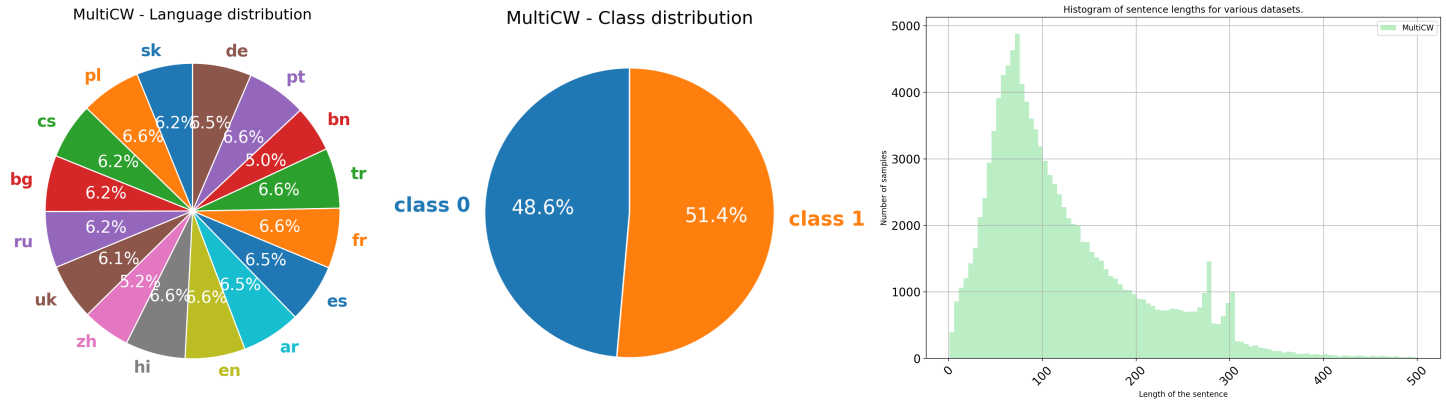

#### Combine all the parts together restricted to 2000 per language and style and class
- By limiting the max number of samples we effectively balance the dataset in terms of number of samples

In [15]:
import os
import pandas as pd
samples_needed = 2000

# List of languages
languages = pd.read_csv(join(multicw_path, 'noisy_part.csv'))['lang'].unique()

def load_and_add_origin(filepath, origin):
    """ Load a CSV and add the 'origin' column """
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        df['origin'] = origin
        if not 'text_en' in df:
            df['text_en'] = ''
        return df
    return None

def intersect_columns(dfs):
    """ Intersect columns for a list of DataFrames """
    common_cols = set(dfs[0].columns)
    for df in dfs[1:]:
        common_cols = common_cols.intersection(set(df.columns))
    common_cols = list(common_cols)  # Convert set to list
    return [df[common_cols] for df in dfs]

def restrict_wiki(wiki: DataFrame, histogram: DataFrame, max_samples=samples_needed):
    """ Restricts the number of Wikipedia samples to 2000 while maintaining the matching ratio to the histogram frequencies. """

    # Step 1: Calculate proportions
    histogram['proportion'] = histogram['frequency'] / histogram['frequency'].sum()

    # Step 2: Determine number of samples per entity-language pair
    histogram['allocated_samples'] = (histogram['proportion'] * max_samples).round().astype(int)

    # Step 3: Sample from Wiki DataFrame
    samples = []
    for _, row in histogram.iterrows():
        entity = row['entity']
        language = row['language']
        allocated_samples = row['allocated_samples']

        if not 'entities' in wiki:
            print(f'Language: {lang}')
            print(wiki.columns)
        # Filter relevant samples
        filtered_samples = wiki[(wiki['entities'] == entity) & (wiki['lang'] == language)]

        samples.append(filtered_samples)

    # Step 4: Combine all sampled data
    final_samples = pd.concat(samples)

    # Ensure the final DataFrame has exactly 2000 rows (optional step for precision adjustments)
    final_samples = final_samples.sample(n=max_samples, random_state=42) if len(final_samples) > max_samples else final_samples

    # Output
    return final_samples

table = []
multicw = []
for lang in languages:
    lang_path = join(multicw_path, lang)

    # Initialize lists to hold DataFrames for noisy_part and struct_part
    noisy_dfs = []
    struc_dfs = []

    # Load noisy files
    noisy_unbalanced = load_and_add_origin(join(lang_path, 'noisy_unbalanced.csv'), 'manual')
    noisy_balanced = load_and_add_origin(join(lang_path, 'noisy_balanced.csv'), 'augmented')

    # Add to list if they exist
    if noisy_unbalanced is not None:
        noisy_dfs.append(noisy_unbalanced)
    if noisy_balanced is not None:
        noisy_dfs.append(noisy_balanced)

    # If there are noisy DataFrames, concatenate them
    if noisy_dfs:
        noisy_dfs = intersect_columns(noisy_dfs)  # Intersect columns before concatenation
        noisy_part = pd.concat(noisy_dfs)
        noisy_part.to_csv(join(lang_path, 'noisy_part.csv'), index=False, header=True)

    # Load struc files
    struc_unbalanced = load_and_add_origin(join(lang_path, 'struc_unbalanced.csv'), 'manual')
    struc_balanced = load_and_add_origin(join(lang_path, 'struc_balanced.csv'), 'augmented')
    wiki = pd.read_csv(join(lang_path, 'wiki.csv'))
    

    # Restrict the number of wiki samples to 2000
    histogram = pd.read_csv(join(lang_path, 'struc_histogram.csv'))
    wiki = restrict_wiki(wiki, histogram).drop('url', axis=1)
    print(f'Restricted wiki samples in {lang} to {wiki.shape[0]} samples.')

    # Add to list if they exist
    if struc_unbalanced is not None:
        struc_dfs.append(struc_unbalanced)
    if struc_balanced is not None:
        struc_dfs.append(struc_balanced)

    # If there are struc DataFrames, concatenate them
    if struc_dfs:
        struc_dfs = intersect_columns(struc_dfs)  # Intersect columns before concatenation
        struc_part = pd.concat(struc_dfs)
        struc_part.to_csv(join(lang_path, 'struc_part.csv'), index=False, header=True)

    # Drop duplicates from both parts of the dataset
    if lang!= 'en': # For English the language specific and English only samples match
        noisy_part = noisy_part.drop_duplicates(subset='text', keep='first')
        struc_part = struc_part.drop_duplicates(subset='text', keep='first')
        noisy_part = noisy_part.dropna(subset='text')
        struc_part = struc_part.dropna(subset='text')

    # Specify the type of the samples in the overall dataset file
    noisy_part['style'] = 'noisy'
    struc_part['style'] = 'struc'

    noisy_part['lang'] = lang
    struc_part['lang'] = lang

    # Restrict to needed number of samples per language and category
    noisy_class_0 = noisy_part.loc[noisy_part['label'] == 0]
    noisy_class_1 = noisy_part.loc[noisy_part['label'] == 1]
    struc_class_0 = wiki
    struc_class_1 = struc_part.loc[struc_part['label'] == 1]

    noisy_class_0 = noisy_class_0[:samples_needed]
    noisy_class_1 = noisy_class_1[:samples_needed]
    struc_class_0 = struc_class_0[:samples_needed]
    struc_class_1 = struc_class_1[:samples_needed]

    multicw.extend([noisy_class_0, noisy_class_1, struc_class_0, struc_class_1])

    # Loop through each unique language in the DataFrame
    table.append({'Language': lang,
                'Noisy (class 0):': noisy_class_0.shape[0],
                'Noisy (class 1):': noisy_class_1.shape[0],
                'Structured (class 0):': struc_class_0.shape[0],
                'Structured (class 1):': struc_class_1.shape[0]})

# Compose the final dataset
final_path = join(multicw_path, 'multicw.csv')
multicw = pd.concat(multicw)

multicw_noisy = multicw.loc[multicw['style'] == 'noisy']
multicw_struc = multicw.loc[multicw['style'] == 'struc']

# Get also the numbers for the final dataset
table.append({'Language': 'Total',
                'Noisy (class 0):': multicw_noisy.loc[multicw_noisy['label'] == 0].shape[0],
                'Noisy (class 1):': multicw_noisy.loc[multicw_noisy['label'] == 1].shape[0],
                'Structured (class 0):': multicw_struc.loc[multicw_struc['label'] == 0].shape[0],
                'Structured (class 1):': multicw_struc.loc[multicw_struc['label'] == 1].shape[0]})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))

multicw.to_csv(final_path, header=True, index=False)
print(f'Final dataset saved to: {final_path}')

Restricted wiki samples in sk to 1928 samples.
Restricted wiki samples in pl to 155 samples.
Restricted wiki samples in cs to 1850 samples.
Restricted wiki samples in bg to 951 samples.
Restricted wiki samples in ru to 1673 samples.
Restricted wiki samples in uk to 1978 samples.
Restricted wiki samples in zh to 1875 samples.
Restricted wiki samples in hi to 1542 samples.
Restricted wiki samples in de to 1657 samples.
Restricted wiki samples in ar to 1671 samples.
Restricted wiki samples in tr to 1645 samples.
Restricted wiki samples in es to 1794 samples.
Restricted wiki samples in nl to 1641 samples.
Restricted wiki samples in my to 89 samples.
Restricted wiki samples in it to 1751 samples.
Restricted wiki samples in mk to 1821 samples.
Restricted wiki samples in bn to 1679 samples.
Restricted wiki samples in en to 1541 samples.
Restricted wiki samples in pt to 1928 samples.
Restricted wiki samples in fr to 1765 samples.
|Language|Noisy (class 0):|Noisy (class 1):|Structured (class 0)

#### Split MultiCW dataset into Train, Dev and Test set:

|Language|Noisy Train:|Noisy Dev:|Noisy Test:|Structured Train:|Structured Dev:|Structured Test:|
|--------|------------|----------|-----------|-----------------|---------------|----------------|
|   sk   |    2100    |    450   |    450    |       2800      |      600      |       600      |
|   pl   |    2451    |    524   |    524    |       2800      |      600      |       600      |
|   cs   |    2103    |    448   |    448    |       2800      |      600      |       600      |
|   bg   |    2452    |    524   |    524    |       2449      |      524      |       524      |
|   ru   |    2103    |    448   |    448    |       2800      |      600      |       600      |
|   uk   |    2094    |    448   |    448    |       2800      |      600      |       600      |
|   zh   |    2093    |    448   |    448    |       2082      |      444      |       444      |
|   hi   |    2443    |    522   |    522    |       2800      |      600      |       600      |
|   en   |    1861    |    396   |    396    |       2800      |      600      |       600      |
|   ar   |    2358    |    504   |    504    |       2800      |      600      |       600      |
|   es   |    2345    |    502   |    502    |       2800      |      600      |       600      |
|   fr   |    2441    |    522   |    522    |       2800      |      600      |       600      |
|   tr   |    2452    |    524   |    524    |       2800      |      600      |       600      |
|   bn   |    2410    |    516   |    516    |       1656      |      295      |       344      |
|   pt   |    2442    |    522   |    522    |       2800      |      600      |       600      |
|   de   |    2346    |    500   |    500    |       2800      |      600      |       600      |


|Train set:|Test set:|Dev set:|Total:|
|----------|---------|--------|------|
|   79081  |  16910  |  16861 |112852|


In [6]:
import pandas as pd

final_path = join(multicw_path, 'multicw-full.csv')

def split_part(df: DataFrame, test_ratio: float, dev_ratio: float):
    # Split based on writing style
    noisy = df[df['style'] == 'noisy']
    struc = df[df['style'] == 'struct']

    # Noisy part
    noisy_size = [int(noisy.shape[0] * test_ratio), int(noisy.shape[0] * dev_ratio)]
    struc_size = [int(struc.shape[0] * test_ratio), int(struc.shape[0] * dev_ratio)]


    # Split each part into train, dev and test
    noisy_train, noisy_dev, noisy_test  = split_origin(noisy, noisy_size[0], noisy_size[1])
    struc_train, struc_dev, struc_test = split_origin(struc, struc_size[0], struc_size[1])

    # Combine sets
    test = [noisy_test, struc_test]
    dev = [noisy_dev, struc_dev]
    train = [noisy_train, struc_train]

    return train, dev, test


def split_origin(df: DataFrame, test_size: int, dev_size: int):
    # Split based on origin. Prioritize manual samples but use all of them.
    manual = df[df['origin'] == 'manual']
    rest = df[df['origin'] != 'manual']
    sorted = pd.concat([manual, rest]).sample(frac=1)

    # Split into classes
    class_0, class_1 = split_class(sorted)

    # Split each class into train, dev and test set
    idx = [int(test_size / 2), int(dev_size / 2)]
    test_0 = class_0.iloc[:idx[0]].copy()
    dev_0 = class_0.iloc[idx[0]: idx[0] + idx[1]].copy()
    train_0 = class_0.iloc[idx[0] + idx[1]:, :].copy()

    test_1 = class_1.iloc[:idx[0]].copy()
    dev_1 = class_1.iloc[idx[0]: idx[0] + idx[1]].copy()
    train_1 = class_1.iloc[idx[0] + idx[1]:, :].copy()

    train = pd.concat([train_0, train_1])
    dev = pd.concat([dev_0, dev_1])
    test = pd.concat([test_0, test_1])

    return train, dev, test

def split_class(df: DataFrame):
    # Split based on label
    class_0 = df[df['label'] == 0]
    class_1 = df[df['label'] == 1]

    return class_0, class_1

# Function to split the dataframe
def split_dataframe(df, test_ratio=0.15, dev_ratio=0.15):
    train_set = []
    test_set = []
    dev_set = []
    stats = []

    for lang in df['lang'].unique():
        # Extract the specific language from the dataframe
        lang_df = df[df['lang'] == lang]

        # Split to train, dev and test
        train, dev, test = split_part(lang_df, test_ratio, dev_ratio)

        # Save statistics
        stats.append({'Language': lang,
                'Noisy Train:': train[0].shape[0],
                'Noisy Dev:': dev[0].shape[0],
                'Noisy Test:': test[0].shape[0],
                'Structured Train:': train[1].shape[0],
                'Structured Dev:': dev[1].shape[0],
                'Structured Test:': test[1].shape[0]})

        # Combine sets
        train_set.append(pd.concat(train))
        dev_set.append(pd.concat(dev))
        test_set.append(pd.concat(test))

    train_set = pd.concat(train_set)
    test_set = pd.concat(test_set)
    dev_set = pd.concat(dev_set)

    total = [{'Train set:': train_set.shape[0],
              'Test set:': test_set.shape[0],
              'Dev set:': dev_set.shape[0],
              'Total:': multicw.shape[0]}]

    table1 = markdown_table(stats).set_params(row_sep = 'markdown').get_markdown()
    print(table1.replace('```',''))

    table2 = markdown_table(total).set_params(row_sep = 'markdown').get_markdown()
    print(table2.replace('```',''))

    return train_set, test_set, dev_set

multicw = pd.read_csv(final_path)
# multicw = multicw.drop('index', axis=1)
train_df, test_df, dev_df = split_dataframe(multicw)

train_df.to_csv(join(multicw_path, 'multicw-train.csv'), index=False)
test_df.to_csv(join(multicw_path, 'multicw-test.csv'), index=False)
dev_df.to_csv(join(multicw_path, 'multicw-dev.csv'), index=False)
print(f'Training, validation and test sets has been saved to {multicw_path}')

|Language|Noisy Train:|Noisy Dev:|Noisy Test:|Structured Train:|Structured Dev:|Structured Test:|
|--------|------------|----------|-----------|-----------------|---------------|----------------|
|   sk   |    2764    |    592   |    592    |       2800      |      600      |       600      |
|   pl   |    2775    |    594   |    594    |       2800      |      600      |       600      |
|   cs   |    2769    |    592   |    592    |       2800      |      600      |       600      |
|   bg   |    2797    |    598   |    598    |       2169      |      462      |       462      |
|   ru   |    2778    |    594   |    594    |       2800      |      600      |       600      |
|   uk   |    2762    |    590   |    590    |       2800      |      600      |       600      |
|   zh   |    2764    |    590   |    590    |       2082      |      444      |       444      |
|   hi   |    2780    |    594   |    594    |       2800      |      600      |       600      |
|   en   |    2800  

#### Statistics:

<table>
<tr>
<td>

|Language|Noisy (class 0):|Noisy (class 1):|Structured (class 0):|Structured (class 1):|
|--------|----------------|----------------|---------------------|---------------------|
|   sk   |      2000      |      2000      |         2000        |         2000        |
|   pl   |      2000      |      2000      |         2000        |         2000        |
|   cs   |      2000      |      2000      |         2000        |         2000        |
|   bg   |      2000      |      2000      |         2000        |         2000        |
|   ru   |      2000      |      2000      |         2000        |         2000        |
|   uk   |      2000      |      2000      |         2000        |         2000        |
|   zh   |      2000      |      2000      |         2000        |         2000        |
|   hi   |      2000      |      2000      |         2000        |         2000        |
|   de   |      2000      |      2000      |         2000        |         2000        |
|   ar   |      2000      |      2000      |         2000        |         2000        |
|   tr   |      2000      |      2000      |         2000        |         2000        |
|   es   |      2000      |      2000      |         2000        |         2000        |
|   nl   |      2000      |      2000      |         1227        |         1227        |
|   my   |      2000      |      2000      |         1297        |         1297        |
|   it   |      2000      |      2000      |         2000        |         2000        |
|   mk   |      2000      |      2000      |         1123        |         1123        |
|   bn   |      2000      |      2000      |         2000        |         2000        |
|   en   |      2000      |      2000      |         2000        |         2000        |
|   pt   |      2000      |      2000      |         2000        |         2000        |
|   fr   |      2000      |      2000      |         2000        |         2000        |
|  Total |      40000     |      40000     |        40000        |        37647        |
                        Final MultiCW dataset statistics.
</td>
<td>

|Language|Noisy (class 0):|Noisy (class 1):|Structured (class 0):|Structured (class 1):|
|--------|----------------|----------------|---------------------|---------------------|
|   nl   |      2000      |      2000      |         1227        |         1227        |
|   my   |      2000      |      2000      |         1297        |         1297        |
|   it   |      2000      |      2000      |         2000        |         2000        |
|   mk   |      2000      |      2000      |         1123        |         1123        |
|  Total |      8000      |      8000      |          0          |         5647        |
**Total: 29647**
                    Out-of-distribution dataset statistics.
</td>
</tr>
</table>


In [6]:
from os.path import join
import pandas as pd
from py_markdown_table.markdown_table import markdown_table

multicw = pd.read_csv(join('Final-dataset', 'multicw.csv'))
multicw['style'] = multicw['style'].replace('structured', 'struc')
multicw_noisy = multicw.loc[multicw['style'] == 'noisy']
multicw_struc = multicw.loc[multicw['style'] == 'struc']

table = []
for lang in multicw['lang'].unique():
    noisy_part = multicw_noisy.loc[multicw_noisy['lang'] == lang]
    struc_part = multicw_struc.loc[multicw_struc['lang'] == lang]
    # Restrict to needed number of samples per language and category
    noisy_class_0 = noisy_part.loc[noisy_part['label'] == 0]
    noisy_class_1 = noisy_part.loc[noisy_part['label'] == 1]
    struc_class_0 = struc_part.loc[struc_part['label'] == 1]
    struc_class_1 = struc_part.loc[struc_part['label'] == 1]

    # Loop through each unique language in the DataFrame
    table.append({'Language': lang,
                'Noisy (class 0):': noisy_class_0.shape[0],
                'Noisy (class 1):': noisy_class_1.shape[0],
                'Structured (class 0):': struc_class_0.shape[0],
                'Structured (class 1):': struc_class_1.shape[0]})

# Get also the numbers for the final dataset
table.append({'Language': 'Total',
                'Noisy (class 0):': multicw_noisy.loc[multicw_noisy['label'] == 0].shape[0],
                'Noisy (class 1):': multicw_noisy.loc[multicw_noisy['label'] == 1].shape[0],
                'Structured (class 0):': multicw_struc.loc[multicw_struc['label'] == 0].shape[0],
                'Structured (class 1):': multicw_struc.loc[multicw_struc['label'] == 1].shape[0]})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))
print(f"Total: {multicw.shape[0]}")

/tmp/ipykernel_9769/4044146426.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  multicw = pd.read_csv(join('Final-dataset', 'multicw.csv'))


|Language|Noisy (class 0):|Noisy (class 1):|Structured (class 0):|Structured (class 1):|
|--------|----------------|----------------|---------------------|---------------------|
|   sk   |      2000      |      2000      |         2000        |         2000        |
|   pl   |      2000      |      2000      |         2000        |         2000        |
|   cs   |      2000      |      2000      |         2000        |         2000        |
|   bg   |      2000      |      2000      |         2000        |         2000        |
|   ru   |      2000      |      2000      |         2000        |         2000        |
|   uk   |      2000      |      2000      |         2000        |         2000        |
|   zh   |      2000      |      2000      |         2000        |         2000        |
|   hi   |      2000      |      2000      |         2000        |         2000        |
|   de   |      2000      |      2000      |         2000        |         2000        |
|   ar   |      2000 

In [18]:
from os.path import join
import pandas as pd
from py_markdown_table.markdown_table import markdown_table

multicw = pd.read_csv(join('Final-dataset', 'multicw-ood.csv'))
multicw_noisy = multicw.loc[multicw['style'] == 'noisy']
multicw_struc = multicw.loc[multicw['style'] == 'struc']

table = []
for lang in multicw['lang'].unique():
    noisy_part = multicw_noisy.loc[multicw_noisy['lang'] == lang]
    struc_part = multicw_struc.loc[multicw_struc['lang'] == lang]
    # Restrict to needed number of samples per language and category
    noisy_class_0 = noisy_part.loc[noisy_part['label'] == 0]
    noisy_class_1 = noisy_part.loc[noisy_part['label'] == 1]
    struc_class_0 = struc_part.loc[struc_part['label'] == 1]
    struc_class_1 = struc_part.loc[struc_part['label'] == 1]

    # Loop through each unique language in the DataFrame
    table.append({'Language': lang,
                'Noisy (class 0):': noisy_class_0.shape[0],
                'Noisy (class 1):': noisy_class_1.shape[0],
                'Structured (class 0):': struc_class_0.shape[0],
                'Structured (class 1):': struc_class_1.shape[0]})

# Get also the numbers for the final dataset
table.append({'Language': 'Total',
                'Noisy (class 0):': multicw_noisy.loc[multicw_noisy['label'] == 0].shape[0],
                'Noisy (class 1):': multicw_noisy.loc[multicw_noisy['label'] == 1].shape[0],
                'Structured (class 0):': multicw_struc.loc[multicw_struc['label'] == 0].shape[0],
                'Structured (class 1):': multicw_struc.loc[multicw_struc['label'] == 1].shape[0]})

markdown = markdown_table(table).set_params(row_sep = 'markdown').get_markdown()
print(markdown.replace('```',''))
print(f"Total: {multicw.shape[0]}")

|Language|Noisy (class 0):|Noisy (class 1):|Structured (class 0):|Structured (class 1):|
|--------|----------------|----------------|---------------------|---------------------|
|   nl   |      2000      |      2000      |         1227        |         1227        |
|   my   |      2000      |      2000      |         1297        |         1297        |
|   it   |      2000      |      2000      |         2000        |         2000        |
|   mk   |      2000      |      2000      |         1123        |         1123        |
|  Total |      8000      |      8000      |          0          |         5647        |
Total: 29647


| Languages: | sk | pl | cs | bg | ru | uk | zh | hi | en | ar | es | fr | tr | bn | pt | de |
|------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Samples:   | 7948 | 7963 | 7953 | 7086 | 7966 | 7942 | 6914 | 7968 | 8000 | 7993 | 7997 | 7962 | 7898 | 6212 | 7961 | 7959 |
| Ratio:     | 6.42% | 6.44% | 6.43% | 5.73% | 6.44% | 6.42% | 5.59% | 6.44% | 6.47% | 6.46% | 6.46% | 6.44% | 6.38% | 5.02% | 6.43% | 6.43% |

MultiCW - Language distribution


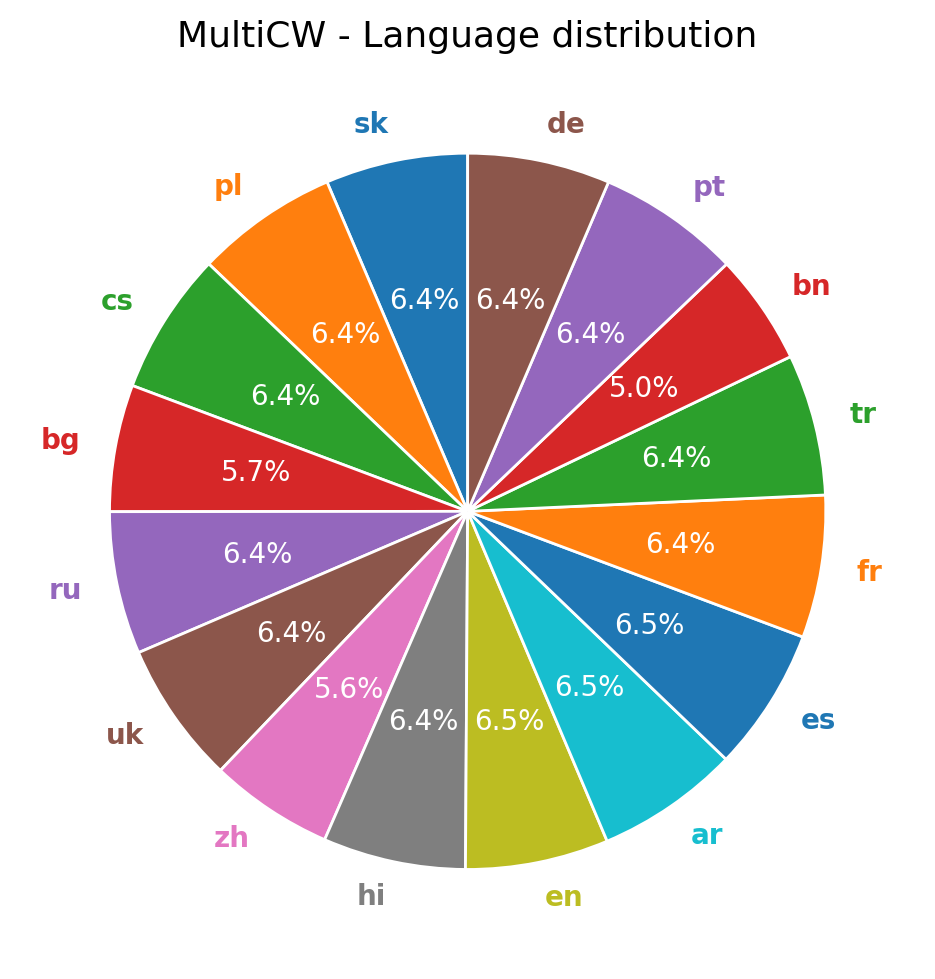

|Class 0:|Class 1:|
|--------|--------|
| 49.18% | 50.82% |
MultiCW - Class distribution


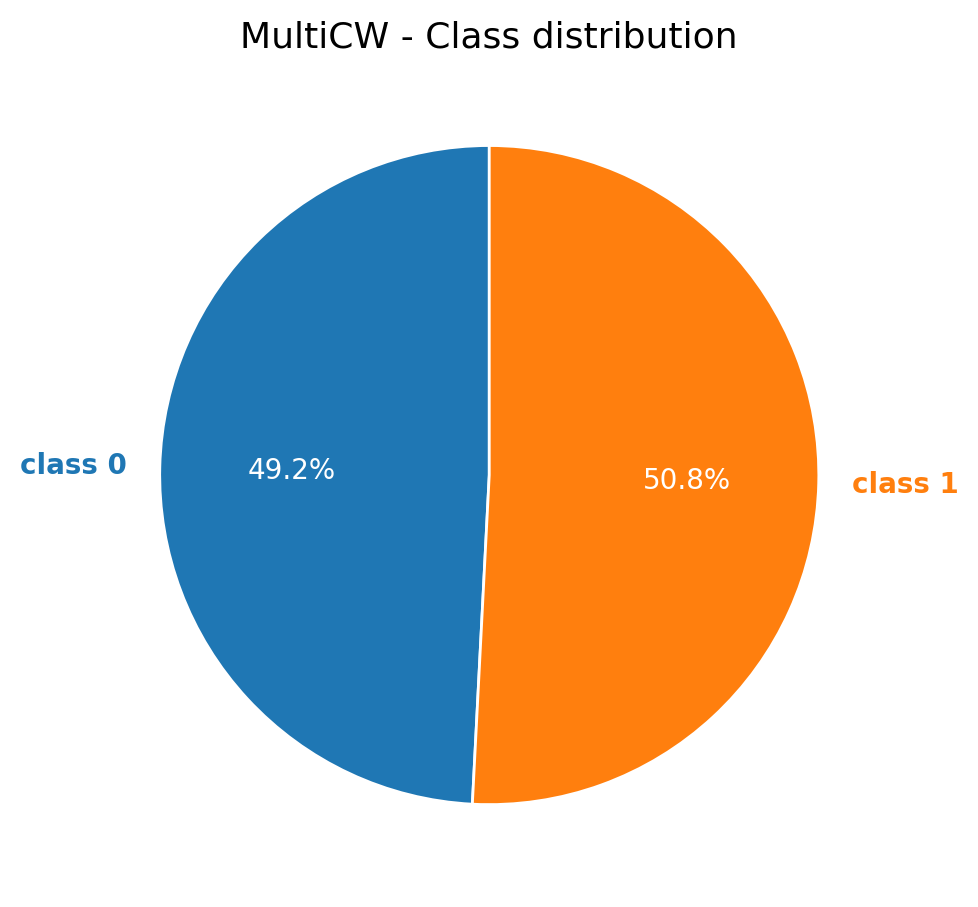

|Dataset|Avg. length:|
|-------|------------|
|MultiCW|   121.28   |


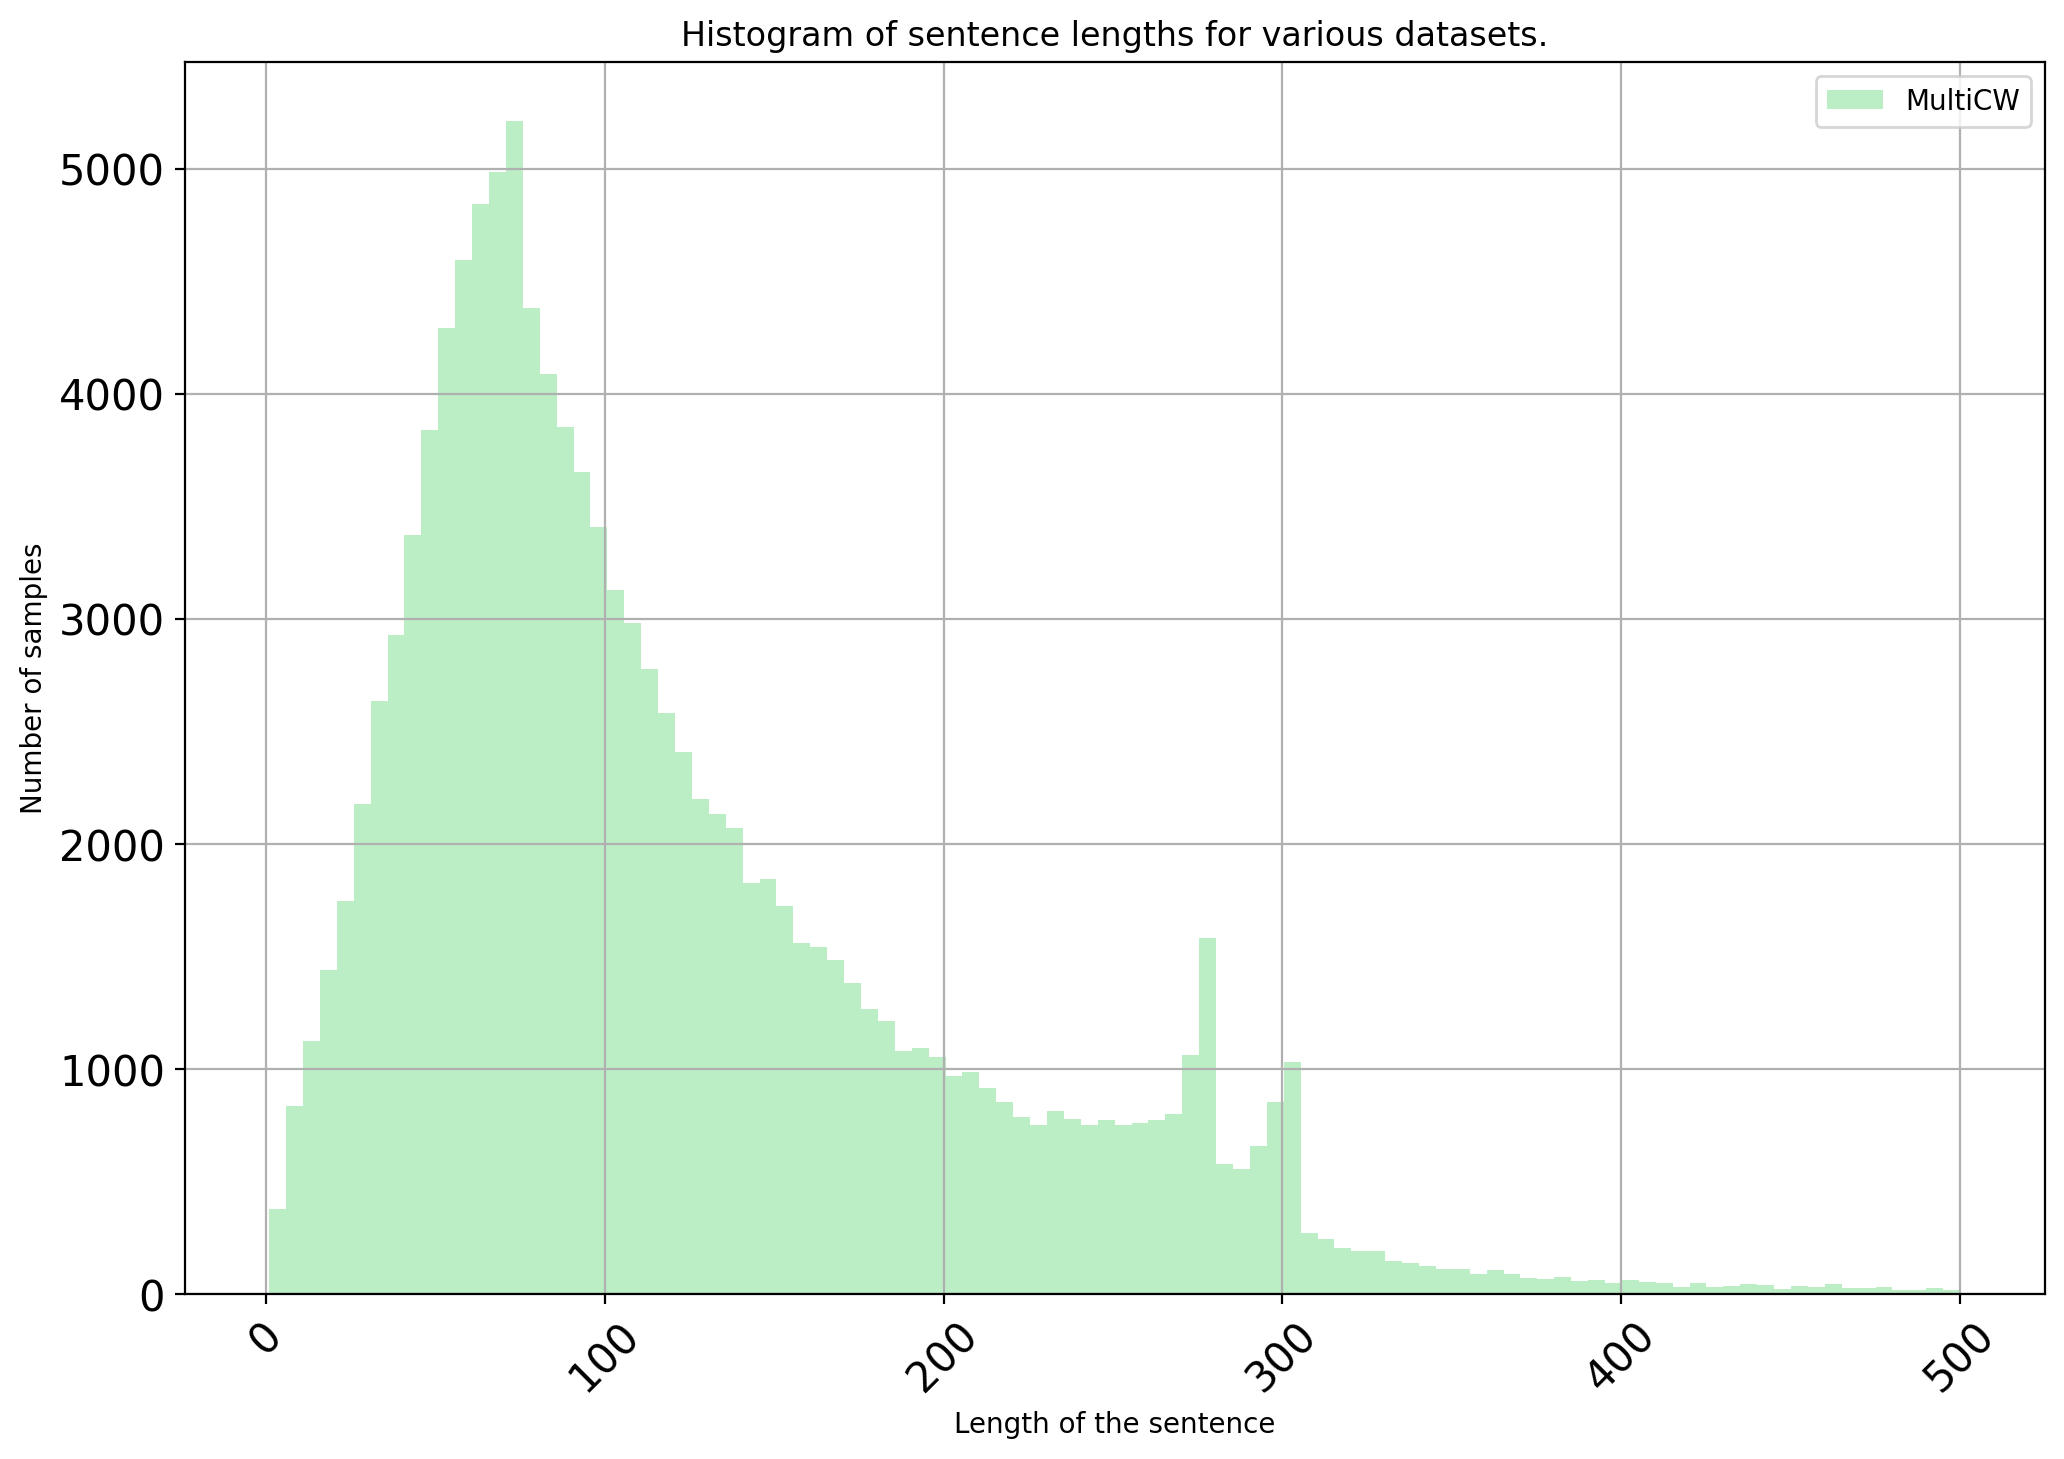

In [7]:
data = lang_distribution(multicw)
pie_chart(title='MultiCW - Language distribution', data=data)

data = class_distribution(multicw)
pie_chart(title='MultiCW - Class distribution', data=data)

histogram({'MultiCW': multicw})